In [1]:
import os
from pathlib import Path
import anndata as an
import numpy as np
import pandas as pd
import deside
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from deside.utility import check_dir, set_fig_style, print_df, get_ccc, non_log2log_cpm, non_log2cpm, read_cancer_purity
from deside.decon_cf import DeSide
from deside.utility.read_file import read_gene_set, ReadH5AD
from deside.plot import plot_corr_two_columns
set_fig_style(font_family='Arial', font_size=8)

2024-06-19 00:07:22.198336: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Initializaing

In [2]:
cell_type2subtypes = {'B Cells': ['Non-plasma B cells', 'Plasma B cells'],
                      'CD4 T': ['CD4 T'], 'CD8 T': ['CD8 T (GZMK high)', 'CD8 T effector'],
                      'DC': ['DC'], 'Endothelial Cells': ['Endothelial Cells'],
                      'Cancer Cells': ['Cancer Cells'],
                      'Fibroblasts': ['CAFs', 'Myofibroblasts'], 'Macrophages': ['Macrophages'],
                      'Mast Cells': ['Mast Cells'], 'NK': ['NK'], 'Neutrophils': ['Neutrophils'],
                      'Double-neg-like T': ['Double-neg-like T'], 'Monocytes': ['Monocytes']}
all_cell_types = sorted([i for v in cell_type2subtypes.values() for i in v])
all_cell_types

['CAFs',
 'CD4 T',
 'CD8 T (GZMK high)',
 'CD8 T effector',
 'Cancer Cells',
 'DC',
 'Double-neg-like T',
 'Endothelial Cells',
 'Macrophages',
 'Mast Cells',
 'Monocytes',
 'Myofibroblasts',
 'NK',
 'Neutrophils',
 'Non-plasma B cells',
 'Plasma B cells']

In [3]:
sorted_cell_type_list2 = ['B Cells', 'CD4 T', 'CD8 T', 'Cancer Cells', 'DC', 'Endothelial Cells', 'Fibroblasts', 'Macrophages', 'Mast Cells', 'NK', 'Neutrophils']
ct_without_neutrophils = [i for i in sorted_cell_type_list2 if i != 'Neutrophils']
algo2cell_type_name_mapping = {
        'CIBERSORT_hnscc': {'B cell': 'B Cells', 'T cells CD4': 'CD4 T', 'T cells CD8': 'CD8 T', 'Dendritic': 'DC',
                            'Malignant': 'Cancer Cells', 'Endothelial': 'Endothelial Cells',
                            'Fibroblast': 'Fibroblasts', 'Macrophage': 'Macrophages', 'Mast': 'Mast Cells',
                            },
        'CIBERSORT_luad': dict(zip(ct_without_neutrophils, ct_without_neutrophils)),
        'DeSide': dict(zip(all_cell_types, all_cell_types)),
        'DeSide_softmax': dict(zip(all_cell_types, all_cell_types)),
        'EPIC_self': {'B.cells': 'B Cells', 'CD4.T': 'CD4 T', 'CD8.T': 'CD8 T',
                      'otherCells': 'Cancer Cells', 'Endothelial.Cells': 'Endothelial Cells',
                      'Fibroblasts': 'Fibroblasts',  'NK': 'NK', 'Macrophages': 'Macrophages',
                      },
        'Scaden_ascites': {'CD4Tcells': 'CD4 T', 'CD8Tcells': 'CD8 T', 'Carcinoma': 'Cancer Cells',
                           'DC': 'DC', 'Fibroblast': 'Fibroblasts', 'NK': 'NK',
                          },
        'Scaden_simu_bulk': dict(zip(sorted_cell_type_list2, sorted_cell_type_list2)),
        'Kassandra_self': {'B_cells': 'B Cells', 'CD4_T_cells': 'CD4 T', 'CD8_T_cells': 'CD8 T',
                           'Endothelium': 'Endothelial Cells', 'Fibroblasts': 'Fibroblasts', 'Macrophages': 'Macrophages',
                           'NK_cells': 'NK', 'Neutrophils': 'Neutrophils', 'Other': 'Cancer Cells'},
}

In [4]:
dataset_dir = '../datasets'
deside_parameters = {'architecture': ([200, 2000, 2000, 2000, 50],
                                      [0.05, 0.05, 0.05, 0.2, 0]),
                     'architecture_for_pathway_network': ([50, 500, 500, 500, 50],
                                                          [0, 0, 0, 0, 0]),
                     'loss_function_alpha': 0.5,  # alpha*mae + (1-alpha)*rmse, mae means mean absolute error
                     'normalization': 'layer_normalization',  # batch_normalization / layer_normalization / None
                     # 1 means to add a normalization layer, input | the first hidden layer | ... | output
                     'normalization_layer': [0, 0, 1, 1, 1, 1],  # 1 more parameter than the number of hidden layers
                     'pathway_network': True,  # using an independent pathway network
                     'last_layer_activation': 'sigmoid',  # sigmoid / softmax
                     'learning_rate': 1e-4,
                     'batch_size': 128}


# read two gene sets as pathway mask
gene_set_file_path1 = os.path.join(dataset_dir, 'gene_set', 'c2.cp.kegg.v2023.1.Hs.symbols.gmt')
gene_set_file_path2 = os.path.join(dataset_dir, 'gene_set', 'c2.cp.reactome.v2023.1.Hs.symbols.gmt')
all_pathway_files = [gene_set_file_path1, gene_set_file_path2]
pathway_mask = read_gene_set(all_pathway_files)  # genes by pathways

## Format the ascites scRNA-seq dataset
- Schelker, M., Feau, S., Du, J., Ranu, N., Klipp, E., MacBeath, G., Schoeberl, B., and Raue, A. (2017). Estimation of immune cell content in tumour tissue using single-cell RNA-seq data. Nat. Commun. 8, 2032.
- Data downloaded from https://figshare.com/s/711d3fb2bd3288c8483a
- Using matlab to output the dataset and annotation informaiton.

In [2]:
ascites_ds = pd.read_csv('./R2Q5/estimation-of-immune-cell-content/data/scaden_ascites_scRNAseq_read_counts.csv', index_col=0).T
ascites_ds.head(2)

Row      A1BG  A1BG-AS1  A1CF  A2M  A2M-AS1  A2ML1  A4GALT  A4GNT  AA06  AAAS  \
7873M       1         0     0    8        0      1       0      0     0     1   
7873M_2     0         0     0    0        0      0       0      0     0    11   

Row      ...  ZWILCH  ZWINT  ZXDA  ZXDB  ZXDC  ZYG11B  ZYX  ZZEF1  ZZZ3  \
7873M    ...       1      0     0     0     0       1   26      5     0   
7873M_2  ...       0      0     0     0     0       1   10      3     0   

Row      bP-21201H5.1  
7873M               0  
7873M_2             0  

[2 rows x 25464 columns]

In [3]:
ascites_ds.shape

(3114, 25464)

In [4]:
with open('./R2Q5/estimation-of-immune-cell-content/data/celltype_tcell.csv') as f_handle:
    x = f_handle.readline()
x = x.strip().split(',')
cell_type = pd.DataFrame(x, columns=['cell_type_id'])
cell_type['cell_type_id'] = cell_type['cell_type_id'].astype('int32')
cell_type

cell_type_id
0                 5
1                 3
2                12
3                12
4                12
...             ...
11754             2
11755             6
11756             2
11757             6
11758            11

[11759 rows x 1 columns]

In [5]:
cell_type['cell_type_id'].unique()

array([ 5,  3, 12,  2,  6,  0,  4, 10,  7,  9,  8, 11], dtype=int32)

In [6]:
type(cell_type.loc[0, 'cell_type_id'])

numpy.int32

In [7]:
cell_type_name = pd.read_csv('./R2Q5/estimation-of-immune-cell-content/data/cell_name.csv')
cell_type_name.columns = range(13)
cell_type_name_dict = cell_type_name.loc[0].to_dict()
cell_type_name_dict

{0: 'Unknown',
 1: 'T cells',
 2: 'CD4+ T cells',
 3: 'CD8+ T cells',
 4: 'regulatory T cells',
 5: 'B cells',
 6: 'Macrophages/Monocytes',
 7: 'Dendritic cells',
 8: 'Natural killer cells',
 9: 'Endothelial cells',
 10: 'Cancer associated fibroblasts',
 11: 'Ovarian carcinoma cells',
 12: 'Melanoma cells'}

In [8]:
cell_type['cell_type'] = cell_type['cell_type_id'].map(cell_type_name_dict)
cell_type.head(2)

cell_type_id     cell_type
0             5       B cells
1             3  CD8+ T cells

In [9]:
cell_type.shape

(11759, 2)

In [10]:
with open('./R2Q5/estimation-of-immune-cell-content/data/id_ascites.csv') as f_handle:
    x = f_handle.readline()
x = x.strip().split(',')
ascites_id = pd.DataFrame(x, columns=['ascites_id'])
ascites_id['ascites_id'] = ascites_id['ascites_id'].astype('int32')
ascites_id

ascites_id
0               0
1               0
2               0
3               0
4               0
...           ...
11754           1
11755           1
11756           1
11757           1
11758           1

[11759 rows x 1 columns]

In [11]:
cell_type = cell_type.merge(ascites_id, left_index=True, right_index=True)
cell_type.head(2)

cell_type_id     cell_type  ascites_id
0             5       B cells           0
1             3  CD8+ T cells           0

In [12]:
sample_id = pd.read_csv('./R2Q5/estimation-of-immune-cell-content/data/sample_id_all_ds.csv').T
sample_id.reset_index(inplace=True)
sample_id.rename(columns={0: 'sample_id'}, inplace=True)
sample_id.head(2)

index    sample_id
0  sample_id1  melanoma_72
1  sample_id2  melanoma_58

In [13]:
cell_type = cell_type.merge(sample_id, left_index=True, right_index=True)
cell_type.head(2)

cell_type_id     cell_type  ascites_id       index    sample_id
0             5       B cells           0  sample_id1  melanoma_72
1             3  CD8+ T cells           0  sample_id2  melanoma_58

In [22]:
cell_type_ascites = cell_type.loc[cell_type['ascites_id'] == 1, :].copy()
print(cell_type_ascites.shape)
cell_type_ascites['ascites_index'] = ascites_ds.index
cell_type_ascites.set_index('ascites_index', inplace=True)
cell_type_ascites.head(3)

(3114, 5)


cell_type_id              cell_type  ascites_id          index  \
ascites_index                                                                   
7873M                     6  Macrophages/Monocytes           1  sample_id8646   
7873M_2                   6  Macrophages/Monocytes           1  sample_id8647   
7873M_3                   7        Dendritic cells           1  sample_id8648   

                   sample_id  
ascites_index                 
7873M          ascites_7873M  
7873M_2        ascites_7873M  
7873M_3        ascites_7873M

In [23]:
cell_type_ascites.groupby('cell_type').count()

cell_type_id  ascites_id  index  sample_id
cell_type                                                                
B cells                                  18          18     18         18
CD4+ T cells                            323         323    323        323
CD8+ T cells                             31          31     31         31
Cancer associated fibroblasts            36          36     36         36
Dendritic cells                         114         114    114        114
Macrophages/Monocytes                  2057        2057   2057       2057
Natural killer cells                    109         109    109        109
Ovarian carcinoma cells                 300         300    300        300
Unknown                                 125         125    125        125
regulatory T cells                        1           1      1          1

In [24]:
cell_type_ascites['dataset_id'] = 'scaden_ascites'
cell_type_mapping = {
    'CD8+ T cells': 'CD8 T',
    'Macrophages/Monocytes': 'Monocytes',
    'Ovarian carcinoma cells': 'Cancer Cells',
    'CD4+ T cells': 'CD4 T',
    'Cancer associated fibroblasts': 'Fibroblasts',
    'Dendritic cells': 'DC',
    'Natural killer cells': 'NK'
}
cell_type_ascites['cell_type'] = cell_type_ascites['cell_type'].map(cell_type_mapping)
cell_type_ascites.head(2)

cell_type_id  cell_type  ascites_id          index  \
ascites_index                                                       
7873M                     6  Monocytes           1  sample_id8646   
7873M_2                   6  Monocytes           1  sample_id8647   

                   sample_id      dataset_id  
ascites_index                                 
7873M          ascites_7873M  scaden_ascites  
7873M_2        ascites_7873M  scaden_ascites

In [25]:
cell_type_ascites = cell_type_ascites.loc[~cell_type_ascites['cell_type'].isnull(), :].copy()
cell_type_ascites.shape

(2970, 6)

In [26]:
ascites_ds = ascites_ds.loc[cell_type_ascites.index, :].copy()
ascites_ds.shape

(2970, 25464)

In [27]:
# ascites_ds.to_csv('./R2Q5/estimation-of-immune-cell-content/data/scaden_ascites_scRNAseq_read_counts_Jun09.csv')
# cell_type_ascites.loc[:, ['cell_type']].to_csv('./R2Q5/estimation-of-immune-cell-content/data/scaden_ascites_scRNAseq_cell_types.csv')

In [28]:
np.all(cell_type_ascites.index == ascites_ds.index)

True

In [17]:
ascites_ds_log_cpm = non_log2log_cpm(ascites_ds, transpose=False)
ascites_ds_log_cpm.head(2)

Row       A1BG  A1BG-AS1  A1CF    A2M  A2M-AS1  A2ML1  A4GALT  A4GNT  AA06  \
7873M    4.805       0.0   0.0  7.759      0.0  4.805     0.0    0.0   0.0   
7873M_2  0.000       0.0   0.0  0.000      0.0  0.000     0.0    0.0   0.0   

Row       AAAS  ...  ZWILCH  ZWINT  ZXDA  ZXDB  ZXDC  ZYG11B    ZYX  ZZEF1  \
7873M    4.805  ...   4.805    0.0   0.0   0.0   0.0   4.805  9.455  7.085   
7873M_2  9.866  ...   0.000    0.0   0.0   0.0   0.0   6.422  9.729  7.996   

Row      ZZZ3  bP-21201H5.1  
7873M     0.0           0.0  
7873M_2   0.0           0.0  

[2 rows x 25464 columns]

In [18]:
ascites_h5ad = an.AnnData(X=ascites_ds_log_cpm, obs=cell_type_ascites, dtype=np.float32)
# ascites_h5ad.write('./R2Q5/estimation-of-immune-cell-content/data/scaden_ascites_scRNAseq_data_log2cpm1p.h5ad', compression=True)

## SC_OV dataset
- Model trained by the dataset D1+D2
- Model trained by the simulated dataset Scaden-Ascites (Scaden bulk)
- Model trained by the dataset generated by the scRNA-seq dataset, Ascites from Scaden (DeSide bulk)

In [2]:
cell_type_name_mapping = {'Malignant': 'Cancer Cells', 'T cells CD8': 'CD8 T', 'T cells CD4': 'CD4 T',
                          'Fibroblast': 'Fibroblasts', 'Macrophage': 'Macrophages', 'B cell': 'B Cells',
                          'Mast': 'Mast Cells', 'Dendritic': 'DC', 'Endothelial': 'Endothelial Cells',
                          'cellFractions.B.Cells': 'B Cells',
                          'cellFractions.Endothelial.Cells': 'Endothelial Cells',
                          'cellFractions.Fibroblasts': 'Fibroblasts', 'cellFractions.Macrophages': 'Macrophages',
                          'cellFractions.NK': 'NK', 'cellFractions.T.Cells': 'T Cells',
                          'cellFractions.CD4.T': 'CD4 T',
                          'cellFractions.CD8.T': 'CD8 T', 'cellFractions.DC': 'DC',
                          'cellFractions.Mast.Cells': 'Mast Cells',
                          'cellFractions.Neutrophils': 'Neutrophils', 'cellFractions.otherCells': 'Cancer Cells',
                          'cellFractions.Monocytes': 'Monocytes', 'Carcinoma': 'Cancer Cells', 'CD8Tcells': 'CD8 T', 'CD4Tcells': 'CD4 T'}

### Ground truth

In [3]:
ds4 = 'SC_ovarian_cancer'
ind_ds_dir = '../datasets/Independent_Test_Set/to_xiongxin/'
cell_prop_true = pd.read_csv(f'{ind_ds_dir}/validation_datasets_cell_values/cell_values/{ds4}.csv', index_col=0)
print_df(cell_prop_true)

  >>  <<  
(7, 8)
         Sample_1976.0  Sample_3250.0  Sample_3250.1  Sample_3266.0  \
B Cells       0.282486            0.0       1.070664      43.618340   
DC            3.389831            0.0       0.000000       9.913259   

         Sample_3281.0  Sample_3288.0  Sample_3288.1  Sample_3290.0  
B Cells            0.0            0.0       0.020437       0.085397  
DC                 0.0            0.0       0.000000       0.000000  


In [4]:
cell_prop_true = cell_prop_true / 100

In [5]:
cell_prop_true.index.unique()

Index(['B Cells', 'DC', 'Fibroblasts', 'Macrophages', 'NK', 'T Cells',
       'Cancer Cells'],
      dtype='object')

In [6]:
cell_prop_true = cell_prop_true.T
cell_prop_true.head(2)

B Cells        DC  Fibroblasts  Macrophages        NK  \
Sample_1976.0  0.002825  0.033898     0.112994     0.409605  0.005650   
Sample_3250.0  0.000000  0.000000     0.043478     0.021739  0.619565   

                T Cells  Cancer Cells  
Sample_1976.0  0.002825      0.432203  
Sample_3250.0  0.000000      0.228261

### Predicted by Scaden-Geistlinger2020_Ovarian_3CA (discard)

In [7]:
# # pred_dir = os.path.join(ind_ds_dir, 'validation_datasets_expression')
# datasets = 'SC_ovarian_cancer'
# cell_prop_pred_scaden_df = pd.read_csv('./R2Q6/scaden/scRNAseq_ds_read_counts/Geistlinger2020_Ovarian_3CA/predicted_results/scaden_Geistlinger2020_Ovarian_3CA_pred_cell_prop_SC_ovarian_cancer.txt', index_col=0, sep='\t')
# # cell_prop_pred_scaden_df = cell_prop_pred_scaden_df.loc[cell_prop_pred_scaden_df['cancer_type'] == 'OV', :].copy()
# cell_prop_pred_scaden_df['algo'] = 'Scaden_OV'
# # cell_prop_pred_scaden_df['datasets'] = datasets
# cell_prop_pred_scaden_df['datasets'] = datasets
# cell_prop_pred_scaden_df.index.name = 'sample_id'
# cell_prop_pred_scaden_df.reset_index(inplace=True)
# cell_prop_pred_scaden_df.head(2)

### Predicted by Scaden-ascites

In [8]:
# pred_dir = os.path.join(ind_ds_dir, 'validation_datasets_expression')
datasets = 'SC_ovarian_cancer'
cell_prop_pred_scaden_df = pd.read_csv('./R2Q6/scaden/scRNAseq_ds_read_counts/scaden_ascites_OV/predicted_results/scaden_ascites_pred_cell_prop_sc_overian.txt', index_col=0, sep='\t')
# cell_prop_pred_scaden_df = cell_prop_pred_scaden_df.loc[cell_prop_pred_scaden_df['cancer_type'] == 'OV', :].copy()
cell_prop_pred_scaden_df['algo'] = 'Scaden_OV-ascites'
# cell_prop_pred_scaden_df['datasets'] = datasets
cell_prop_pred_scaden_df['datasets'] = datasets
cell_prop_pred_scaden_df.rename(columns=cell_type_name_mapping, inplace=True)
cell_prop_pred_scaden_df['T Cells'] = cell_prop_pred_scaden_df[['CD4 T', 'CD8 T']].sum(axis=1)
cell_prop_pred_scaden_df['Macrophages'] = cell_prop_pred_scaden_df['Monocytes']
cell_prop_pred_scaden_df.index.name = 'sample_id'
cell_prop_pred_scaden_df.reset_index(inplace=True)
cell_prop_pred_scaden_df.head(2)

sample_id     CD8 T  Monocytes  Cancer Cells        NK        DC  \
0  Sample_1976.0  0.020503   0.339825      0.490760  0.020865  0.042949   
1  Sample_3250.0  0.077691   0.021596      0.252288  0.329301  0.070649   

      CD4 T  Fibroblasts               algo           datasets   T Cells  \
0  0.018063     0.067035  Scaden_OV-ascites  SC_ovarian_cancer  0.038566   
1  0.211021     0.037453  Scaden_OV-ascites  SC_ovarian_cancer  0.288712   

   Macrophages  
0     0.339825  
1     0.021596

### Predicted by DeSide-D1D2

In [9]:
pred_cell_prop_dir = '../results/whole_workflow_20231110_12ds_subtypes/DeSide_03_new_ds_subtypes_all_range/Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering/'
result_dir = os.path.join(pred_cell_prop_dir, 'SC_OV')
check_dir(result_dir)
y_pred_file_path = os.path.join(result_dir, 'y_predicted_result_sc_ov_deside_d1d2.csv')
if not os.path.exists(y_pred_file_path):
    bulk_tpm_file_path_ds1 = os.path.join(ind_ds_dir, 'validation_datasets_expression', 'SC_ovarian_cancer_expressions.tsv')
    model_dir = os.path.join(pred_cell_prop_dir, f'DeSide_model')

    deside_model = DeSide(model_dir=model_dir)
    deside_model.predict(input_file=bulk_tpm_file_path_ds1,
                         output_file_path=y_pred_file_path,
                         exp_type='TPM', transpose=True, scaling_by_sample=False,
                         scaling_by_constant=True,
                         # new parameters
                         hyper_params=deside_parameters, pathway_mask=pathway_mask)

In [10]:
y_pred = pd.read_csv(y_pred_file_path, index_col=0)
y_pred.head(2)

Plasma B cells  Non-plasma B cells  CD4 T  CD8 T effector  \
Sample_1976.0           0.001               0.000    0.0           0.000   
Sample_3250.0           0.000               0.003    0.0           0.001   

               CD8 T (GZMK high)  Double-neg-like T     DC  Endothelial Cells  \
Sample_1976.0                0.0                0.0  0.006                0.0   
Sample_3250.0                0.0                0.0  0.001                0.0   

               CAFs  Myofibroblasts  Macrophages  Mast Cells     NK  \
Sample_1976.0   0.0           0.001        0.286       0.002  0.003   
Sample_3250.0   0.0           0.009        0.018       0.003  0.852   

               Neutrophils  Monocytes  1-others  Cancer Cells  
Sample_1976.0          0.0      0.034     0.666         0.666  
Sample_3250.0          0.0      0.000     0.111         0.111

In [11]:
t_cells = ['CD4 T', 'CD8 T effector', 'CD8 T (GZMK high)', 'Double-neg-like T']
pred_cell_frac_deside_d1d2 = y_pred.copy()
pred_cell_frac_deside_d1d2['T Cells'] = pred_cell_frac_deside_d1d2[t_cells].sum(axis=1)
pred_cell_frac_deside_d1d2['B Cells'] = pred_cell_frac_deside_d1d2[['Plasma B cells', 'Non-plasma B cells']].sum(axis=1)
pred_cell_frac_deside_d1d2['Fibroblasts'] = pred_cell_frac_deside_d1d2[['CAFs', 'Myofibroblasts']].sum(axis=1)
# pred_cell_frac_deside_ascites_bulk['Macrophages'] = pred_cell_frac_deside_ascites_bulk['Monocytes'].copy()
pred_cell_frac_deside_d1d2['datasets'] = 'SC_ovarian_cancer'
pred_cell_frac_deside_d1d2['algo'] = 'DeSide_D1D2'
pred_cell_frac_deside_d1d2.index.name = 'sample_id'
pred_cell_frac_deside_d1d2.reset_index(inplace=True)
pred_cell_frac_deside_d1d2.head(2)

sample_id  Plasma B cells  Non-plasma B cells  CD4 T  CD8 T effector  \
0  Sample_1976.0           0.001               0.000    0.0           0.000   
1  Sample_3250.0           0.000               0.003    0.0           0.001   

   CD8 T (GZMK high)  Double-neg-like T     DC  Endothelial Cells  CAFs  ...  \
0                0.0                0.0  0.006                0.0   0.0  ...   
1                0.0                0.0  0.001                0.0   0.0  ...   

      NK  Neutrophils  Monocytes  1-others  Cancer Cells  T Cells  B Cells  \
0  0.003          0.0      0.034     0.666         0.666    0.000    0.001   
1  0.852          0.0      0.000     0.111         0.111    0.001    0.003   

   Fibroblasts           datasets         algo  
0        0.001  SC_ovarian_cancer  DeSide_D1D2  
1        0.009  SC_ovarian_cancer  DeSide_D1D2  

[2 rows x 23 columns]

### Predicted by EPIC-Geistlinger2020_Ovarian_3CA (discard)

In [12]:
# pred_by_epic = pd.read_csv('./Yerong/PNAS_3_algorithm_data_240616/predict_kassandra_data-R2Q6/EPIC/Geistlinger2020_Ovarian_3CA_reference_predicted_results/SC_ovarian_cancer.csv', index_col=0)
# # pred_by_epic = pred_by_epic.loc[pred_by_epic['cancer_type'] == 'OV', :].copy()
# pred_by_epic['algo'] = 'EPIC_OV'
# pred_by_epic['datasets'] = datasets
# pred_by_epic.rename(columns=cell_type_name_mapping, inplace=True)
# pred_by_epic.index.name = 'sample_id'
# pred_by_epic.reset_index(inplace=True)
# pred_by_epic.head(2)

### Predicted by EPIC-OV-ascites

In [13]:
pred_by_epic = pd.read_csv('./Yerong/PNAS_3_algorithm_data_240616/predict_kassandra_data-R2Q6/EPIC/scaden_ascites_OV_reference_predicted_results/SC_ovarian_cancer.csv', index_col=0)
# pred_by_epic = pred_by_epic.loc[pred_by_epic['cancer_type'] == 'OV', :].copy()
pred_by_epic['algo'] = 'EPIC_OV-ascites'
pred_by_epic['datasets'] = datasets
pred_by_epic.rename(columns=cell_type_name_mapping, inplace=True)
pred_by_epic['T Cells'] = pred_by_epic[['CD4 T', 'CD8 T']].sum(axis=1)
pred_by_epic['Macrophages'] = pred_by_epic['Monocytes']
pred_by_epic.index.name = 'sample_id'
pred_by_epic.reset_index(inplace=True)
pred_by_epic.head(2)

sample_id         CD4 T         CD8 T            DC  Fibroblasts  \
0  Sample_1976.0  1.448653e-07  1.293847e-03  1.505891e-08     0.004778   
1  Sample_3250.0  4.981384e-07  1.577918e-07  6.422349e-09     0.000031   

   Monocytes        NK  Cancer Cells             algo           datasets  \
0   0.203902  0.032561  7.574652e-01  EPIC_OV-ascites  SC_ovarian_cancer   
1   0.000002  0.999967  6.999999e-09  EPIC_OV-ascites  SC_ovarian_cancer   

        T Cells  Macrophages  
0  1.293992e-03     0.203902  
1  6.559302e-07     0.000002

### Predicted by CIBERSORTx-Geistlinger2020_Ovarian_3CA (discard)

In [14]:
# pred_by_cibersortx = pd.read_csv('./Yerong/PNAS_3_algorithm_data_240616/predict_kassandra_data-R2Q6/CIBERSORT/Geistlinger2020_Ovarian_3CA_reference_predicted_results/SC_ovarian_cancer.csv', index_col=0)
# # pred_by_cibersortx = pred_by_cibersortx.loc[pred_by_cibersortx['cancer_type'] == 'OV', :].copy()
# pred_by_cibersortx['algo'] = 'CIBERSORTx_OV'
# pred_by_cibersortx['datasets'] = datasets
# pred_by_cibersortx.index.name = 'sample_id'
# pred_by_cibersortx.reset_index(inplace=True)
# pred_by_cibersortx.head(2)

### Predicted by CIBERSORTx-OV-ascites

In [15]:
pred_by_cibersortx = pd.read_csv('./Yerong/PNAS_3_algorithm_data_240616/predict_kassandra_data-R2Q6/CIBERSORT/scaden_ascites_OV_reference_predicted_results/SC_ovarian_cancer.csv', index_col=0)
# pred_by_cibersortx = pred_by_cibersortx.loc[pred_by_cibersortx['cancer_type'] == 'OV', :].copy()
pred_by_cibersortx['algo'] = 'CIBERSORTx_OV-ascites'
pred_by_cibersortx['datasets'] = datasets
pred_by_cibersortx['T Cells'] = pred_by_cibersortx[['CD4 T', 'CD8 T']].sum(axis=1)
pred_by_cibersortx['Macrophages'] = pred_by_cibersortx['Monocytes']
pred_by_cibersortx.index.name = 'sample_id'
pred_by_cibersortx.reset_index(inplace=True)
pred_by_cibersortx.head(2)

sample_id     CD4 T     CD8 T  Cancer Cells        DC  Fibroblasts  \
0  Sample_1976.0  0.000000  0.018414      0.305530  0.023763     0.111020   
1  Sample_3250.0  0.070738  0.124625      0.113985  0.035913     0.006515   

   Monocytes        NK  P-value  Correlation      RMSE                   algo  \
0   0.510431  0.030842        0     0.671096  0.746156  CIBERSORTx_OV-ascites   
1   0.079806  0.568418        0     0.687958  0.726590  CIBERSORTx_OV-ascites   

            datasets   T Cells  Macrophages  
0  SC_ovarian_cancer  0.018414     0.510431  
1  SC_ovarian_cancer  0.195363     0.079806

### Predicted by Kassandra

In [16]:
pred_by_kassandra = pd.read_csv('../datasets/Independent_Test_Set/to_xiongxin/validation_datasets_predicted_by_algorithms/predicted_by_algorithms/Kassandra/SC_ovarian_cancer_predicted_by_Kassandra.csv', index_col=0).T
pred_by_kassandra = pred_by_kassandra / 100
pred_by_kassandra.head(2)

B Cells     CD4 T     CD8 T  Endothelial Cells  Fibroblasts  \
Sample_1976.0  0.002734  0.001138  0.001736           0.045234     0.026350   
Sample_3250.0  0.000823  0.004266  0.003886           0.011973     0.000755   

               Lymphocytes  Macrophages  Monocytes        NK  Neutrophils  \
Sample_1976.0     0.015847      0.14780   0.027562  0.004937     0.000372   
Sample_3250.0     0.342266      0.00315   0.000496  0.490847     0.000000   

               Non-plasma B cells  Plasma B cells   T Cells  Cancer Cells  
Sample_1976.0            0.000295        0.002439  0.002874      0.742138  
Sample_3250.0            0.000349        0.000474  0.008152      0.483805

In [17]:
pred_by_kassandra.shape

(8, 14)

In [18]:
# pred_by_kassandra['Macrophages'] = pred_by_cibersortx_ascites_ov['Monocytes']
pred_by_kassandra['T Cells'] = pred_by_kassandra[['CD4 T', 'CD8 T']].sum(axis=1)
pred_by_kassandra['datasets'] = 'SC_ovarian_cancer'
pred_by_kassandra['algo'] = 'Kassandra'
pred_by_kassandra.index.name = 'sample_id'
pred_by_kassandra.reset_index(inplace=True)
pred_by_kassandra.head(2)

sample_id   B Cells     CD4 T     CD8 T  Endothelial Cells  \
0  Sample_1976.0  0.002734  0.001138  0.001736           0.045234   
1  Sample_3250.0  0.000823  0.004266  0.003886           0.011973   

   Fibroblasts  Lymphocytes  Macrophages  Monocytes        NK  Neutrophils  \
0     0.026350     0.015847      0.14780   0.027562  0.004937     0.000372   
1     0.000755     0.342266      0.00315   0.000496  0.490847     0.000000   

   Non-plasma B cells  Plasma B cells   T Cells  Cancer Cells  \
0            0.000295        0.002439  0.002874      0.742138   
1            0.000349        0.000474  0.008152      0.483805   

            datasets       algo  
0  SC_ovarian_cancer  Kassandra  
1  SC_ovarian_cancer  Kassandra

### Combining different parts and comparison

In [19]:
pred_cell_frac_sc_ov = pd.concat([cell_prop_pred_scaden_df, pred_cell_frac_deside_d1d2, pred_by_cibersortx, pred_by_epic, pred_by_kassandra])
pred_cell_frac_sc_ov.head(2)

sample_id     CD8 T  Monocytes  Cancer Cells        NK        DC  \
0  Sample_1976.0  0.020503   0.339825      0.490760  0.020865  0.042949   
1  Sample_3250.0  0.077691   0.021596      0.252288  0.329301  0.070649   

      CD4 T  Fibroblasts               algo           datasets  ...  CAFs  \
0  0.018063     0.067035  Scaden_OV-ascites  SC_ovarian_cancer  ...   NaN   
1  0.211021     0.037453  Scaden_OV-ascites  SC_ovarian_cancer  ...   NaN   

   Myofibroblasts  Mast Cells  Neutrophils  1-others  B Cells  P-value  \
0             NaN         NaN          NaN       NaN      NaN      NaN   
1             NaN         NaN          NaN       NaN      NaN      NaN   

   Correlation  RMSE  Lymphocytes  
0          NaN   NaN          NaN  
1          NaN   NaN          NaN  

[2 rows x 28 columns]

In [20]:
pred_cell_frac_sc_ov = pd.melt(pred_cell_frac_sc_ov, id_vars=['sample_id', 'datasets', 'algo'], value_name='cell_proportion')
pred_cell_frac_sc_ov.rename(columns={'variable': 'cell_type'}, inplace=True)
pred_cell_frac_sc_ov.head(2)

sample_id           datasets               algo cell_type  \
0  Sample_1976.0  SC_ovarian_cancer  Scaden_OV-ascites     CD8 T   
1  Sample_3250.0  SC_ovarian_cancer  Scaden_OV-ascites     CD8 T   

   cell_proportion  
0         0.020503  
1         0.077691

In [21]:
algo_ct2ccc = {}
for (algo, cell_type), group in pred_cell_frac_sc_ov.groupby(['algo', 'cell_type']):
    # print(algo, cell_type)
    if cell_type in cell_prop_true.columns:
        group['cell_proportion_pred'] = group['cell_proportion']
        # if algo not in ['DeSide', 'Scaden_ascites']:
        #     group['cell_proportion_pred'] = group['cell_proportion'] / 100
        group = group.set_index('sample_id')
        current_true = cell_prop_true.loc[:, [cell_type]].copy()
        # print(current_true)
        # print(group)
        group_new = current_true.join(group, how='inner')
        # print(algo, cell_type, group_new.shape)
        # print(group_new)
        algo_ct2ccc[(algo, cell_type)] = get_ccc(group_new[cell_type], group_new['cell_proportion_pred'])
algo_ct2ccc_df_ds4 = pd.DataFrame.from_dict(algo_ct2ccc, orient='index', columns=['CCC'])
# algo_ct2ccc_df = algo_ct2ccc_df.reset_index()
algo_ct2ccc_df_ds4['Algorithm'] = algo_ct2ccc_df_ds4.index.map(lambda x: x[0].replace('_matrix_with_BC', ''))
algo_ct2ccc_df_ds4['Cell type'] = algo_ct2ccc_df_ds4.index.map(lambda x: x[1])
print_df(algo_ct2ccc_df_ds4)

  >>  <<  
(35, 3)
                                            CCC              Algorithm  \
(CIBERSORTx_OV-ascites, B Cells)            NaN  CIBERSORTx_OV-ascites   
(CIBERSORTx_OV-ascites, Cancer Cells)  0.829935  CIBERSORTx_OV-ascites   

                                          Cell type  
(CIBERSORTx_OV-ascites, B Cells)            B Cells  
(CIBERSORTx_OV-ascites, Cancer Cells)  Cancer Cells  


In [22]:
algo_ct2ccc_df_ds4.shape

(35, 3)

In [23]:
algo_ct2ccc_df_ds4

CCC              Algorithm  \
(CIBERSORTx_OV-ascites, B Cells)            NaN  CIBERSORTx_OV-ascites   
(CIBERSORTx_OV-ascites, Cancer Cells)  0.829935  CIBERSORTx_OV-ascites   
(CIBERSORTx_OV-ascites, DC)            0.814367  CIBERSORTx_OV-ascites   
(CIBERSORTx_OV-ascites, Fibroblasts)   0.871810  CIBERSORTx_OV-ascites   
(CIBERSORTx_OV-ascites, Macrophages)   0.976448  CIBERSORTx_OV-ascites   
(CIBERSORTx_OV-ascites, NK)            0.990676  CIBERSORTx_OV-ascites   
(CIBERSORTx_OV-ascites, T Cells)       0.033108  CIBERSORTx_OV-ascites   
(DeSide_D1D2, B Cells)                 0.960113            DeSide_D1D2   
(DeSide_D1D2, Cancer Cells)            0.773765            DeSide_D1D2   
(DeSide_D1D2, DC)                      0.356971            DeSide_D1D2   
(DeSide_D1D2, Fibroblasts)             0.371087            DeSide_D1D2   
(DeSide_D1D2, Macrophages)             0.884828            DeSide_D1D2   
(DeSide_D1D2, NK)                      0.935132            DeSide_D1D2   
(DeSide_D1D2, T Cells)                -0.022317            DeSide_D1D2   
(EPIC_OV-ascites, B Cells)                  NaN        EPIC_OV-ascites   
(EPIC_OV-ascites, Cancer Cells)        0.611684        EPIC_OV-ascites   
(EPIC_OV-ascites, DC)                  0.604290        EPIC_OV-ascites   
(EPIC_OV-ascites, Fibroblasts)         0.547933        EPIC_OV-ascites   
(EPIC_OV-ascites, Macrophages)         0.845378        EPIC_OV-ascites   
(EPIC_OV-ascites, NK)                  0.823920        EPIC_OV-ascites   
(EPIC_OV-ascites, T Cells)            -0.113736        EPIC_OV-ascites   
(Kassandra, B Cells)                   0.858787              Kassandra   
(Kassandra, Cancer Cells)              0.221323              Kassandra   
(Kassandra, DC)                             NaN              Kassandra   
(Kassandra, Fibroblasts)               0.388049              Kassandra   
(Kassandra, Macrophages)               0.361013              Kassandra   
(Kassandra, NK)                        0.956646              Kassandra   
(Kassandra, T Cells)                   0.350387              Kassandra   
(Scaden_OV-ascites, B Cells)                NaN      Scaden_OV-ascites   
(Scaden_OV-ascites, Cancer Cells)      0.952702      Scaden_OV-ascites   
(Scaden_OV-ascites, DC)                0.541511      Scaden_OV-ascites   
(Scaden_OV-ascites, Fibroblasts)       0.974599      Scaden_OV-ascites   
(Scaden_OV-ascites, Macrophages)       0.973192      Scaden_OV-ascites   
(Scaden_OV-ascites, NK)                0.789385      Scaden_OV-ascites   
(Scaden_OV-ascites, T Cells)           0.018930      Scaden_OV-ascites   

                                          Cell type  
(CIBERSORTx_OV-ascites, B Cells)            B Cells  
(CIBERSORTx_OV-ascites, Cancer Cells)  Cancer Cells  
(CIBERSORTx_OV-ascites, DC)                      DC  
(CIBERSORTx_OV-ascites, Fibroblasts)    Fibroblasts  
(CIBERSORTx_OV-ascites, Macrophages)    Macrophages  
(CIBERSORTx_OV-ascites, NK)                      NK  
(CIBERSORTx_OV-ascites, T Cells)            T Cells  
(DeSide_D1D2, B Cells)                      B Cells  
(DeSide_D1D2, Cancer Cells)            Cancer Cells  
(DeSide_D1D2, DC)                                DC  
(DeSide_D1D2, Fibroblasts)              Fibroblasts  
(DeSide_D1D2, Macrophages)              Macrophages  
(DeSide_D1D2, NK)                                NK  
(DeSide_D1D2, T Cells)                      T Cells  
(EPIC_OV-ascites, B Cells)                  B Cells  
(EPIC_OV-ascites, Cancer Cells)        Cancer Cells  
(EPIC_OV-ascites, DC)                            DC  
(EPIC_OV-ascites, Fibroblasts)          Fibroblasts  
(EPIC_OV-ascites, Macrophages)          Macrophages  
(EPIC_OV-ascites, NK)                            NK  
(EPIC_OV-ascites, T Cells)                  T Cells  
(Kassandra, B Cells)                        B Cells  
(Kassandra, Cancer Cells)              Cancer Cells  
(Kassandra, DC)                                  DC  
(Kassandra, Fibroblasts)     

In [24]:
algo_ct2ccc_df_ds4['Algorithm'].unique()

array(['CIBERSORTx_OV-ascites', 'DeSide_D1D2', 'EPIC_OV-ascites',
       'Kassandra', 'Scaden_OV-ascites'], dtype=object)

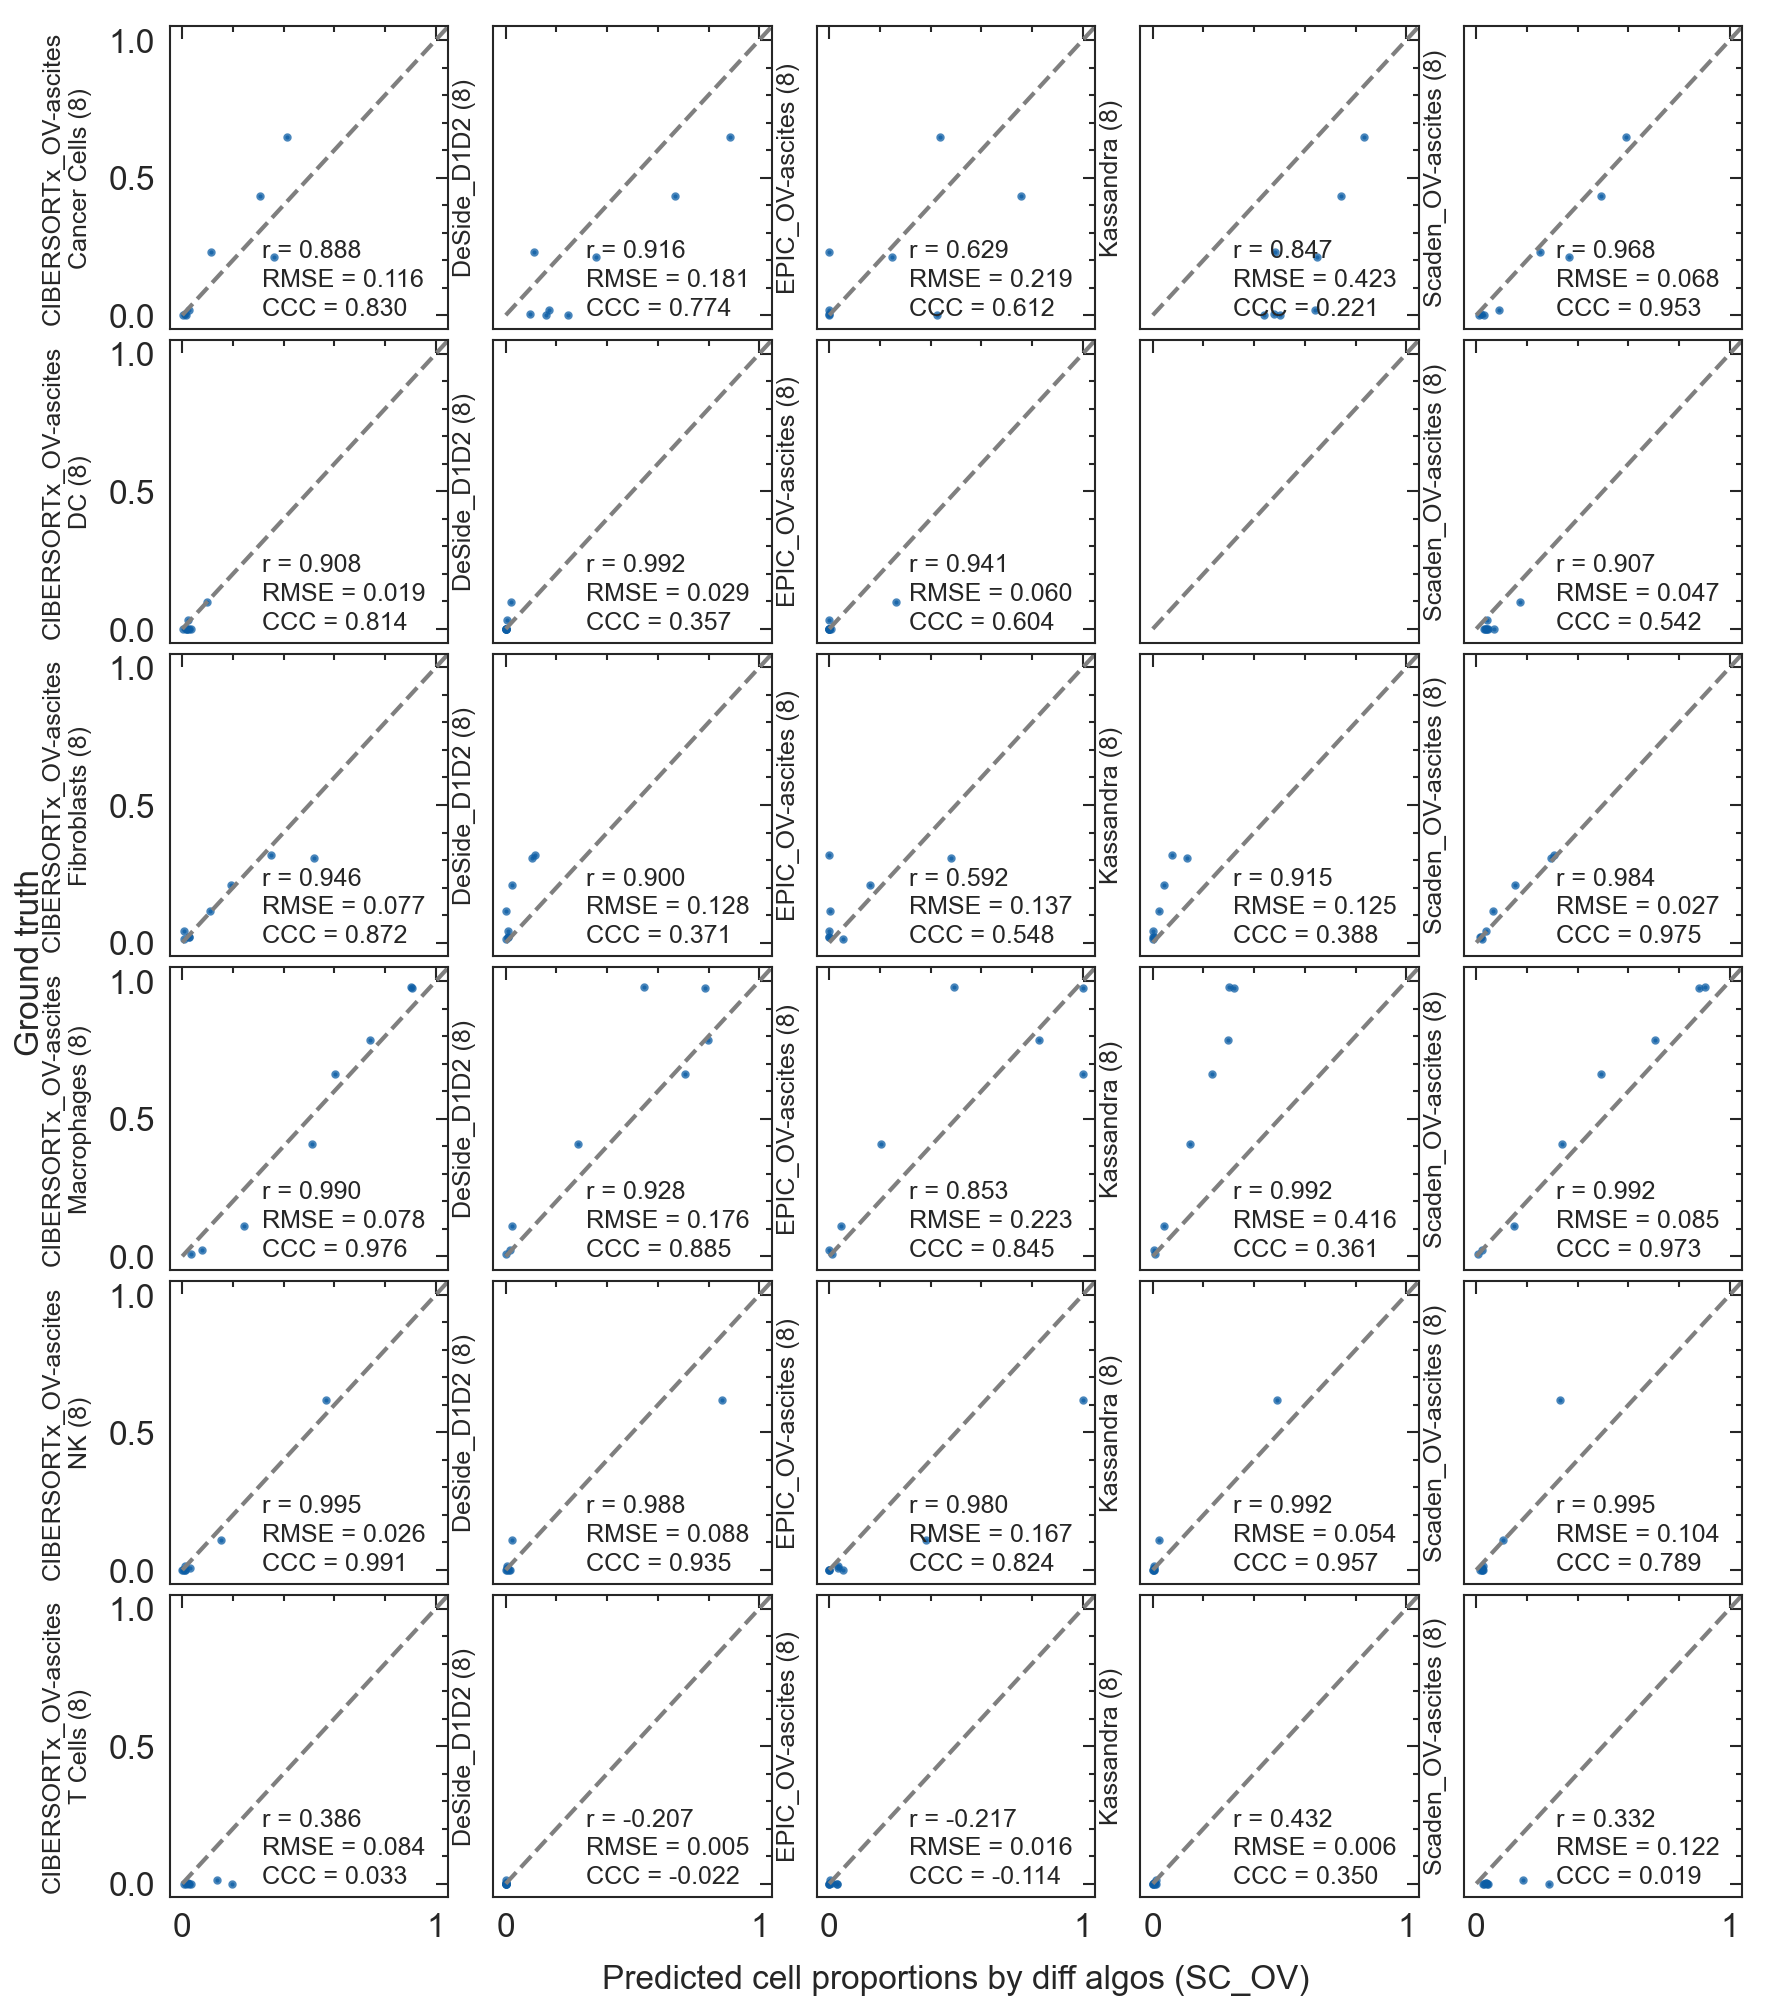

In [28]:
from deside.plot import compare_y_y_pred_plot_cpe

fig_dir = './results/reviewer2_q6/'
cols = ['CIBERSORTx_OV-ascites', 'DeSide_D1D2', 'EPIC_OV-ascites',
       'Kassandra', 'Scaden_OV-ascites']
# cols_mapping = {
#     'Scaden_Scaden-simu(OV-ascites)': 'S_S-simu', 
#     'DeSide_Scaden-simu(OV-ascites)': 'D_S-simu', 
#     'DeSide_DeSide-simu(OV-ascites)': 'D_D-simu',
# }
rows = ['Cancer Cells', 'DC', 'Fibroblasts', 'Macrophages', 'NK', 'T Cells']
n_cols = len(cols)
n_rows = len(rows)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharex='all', sharey='all', figsize=(6.5, 7))
metrics_value = {}
for j in range(n_cols):
    for i in range(n_rows):
        current_algo = cols[j]
        current_ct = rows[i]
        if current_ct in cell_prop_true.columns:
            current_data = pred_cell_frac_sc_ov.loc[(pred_cell_frac_sc_ov['algo'] == current_algo) & (pred_cell_frac_sc_ov['cell_type'] == current_ct), :].copy()
            current_data['cell_prop_pred'] = current_data['cell_proportion']
            current_data.set_index('sample_id', inplace=True)
            # print('current_data', current_data)
            current_true = cell_prop_true.loc[:, [current_ct]].copy()
            current_data = current_true.join(current_data, how='inner')
            # print(current_data.shape)
            if j == 0:
                current_type = current_algo + '\n' + current_ct
            else:
                current_type = current_algo
            try:
                corr, rmse, ccc = compare_y_y_pred_plot_cpe(y_pred=current_data['cell_prop_pred'],
                                                            y_true=current_data[current_ct],
                                                            show_metrics=True, ax=axes[i, j],
                                                            cancer_type=current_type,
                                                            inx=(i, j))
                metrics_value[current_type] = {'corr': corr, 'rmse': rmse, 'ccc': ccc}
            except:
                pass
metrics_value_df = pd.DataFrame.from_dict(metrics_value, orient='index')
metrics_value_df.to_csv(os.path.join(fig_dir, 'pred_cell_prop_vs_ground_truth_SC_OV-3algo-metrics.csv'))

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Predicted cell proportions by diff algos (SC_OV)', labelpad=5)
plt.ylabel("Ground truth", labelpad=15)

plt.tight_layout(h_pad=0.02, w_pad=0.15)
plt.savefig(os.path.join(fig_dir, 'pred_cell_prop_vs_ground_truth-5algo_SC_OV_scaden_OV-ascites.png'), dpi=300)

In [29]:
algo_ct2ccc_df_ds4['Algorithm'].unique()

array(['CIBERSORTx_OV-ascites', 'DeSide_D1D2', 'EPIC_OV-ascites',
       'Kassandra', 'Scaden_OV-ascites'], dtype=object)

In [30]:
selected_colors = [sns.color_palette('tab20')[0]] + [sns.color_palette('tab20')[10]] + \
                  [sns.color_palette('tab20')[2]] + [sns.color_palette('tab20')[4]] + \
                  [sns.color_palette('tab20')[6]]

sns.color_palette(selected_colors)

sns.color_palette(selected_colors)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)]

In [32]:
algos = ['DeSide_D1D2', 'Kassandra', 'EPIC_OV-ascites', 
         'CIBERSORTx_OV-ascites', 'Scaden_OV-ascites']
algo2color = {algos[i]: selected_colors[i] for i in range(5)}

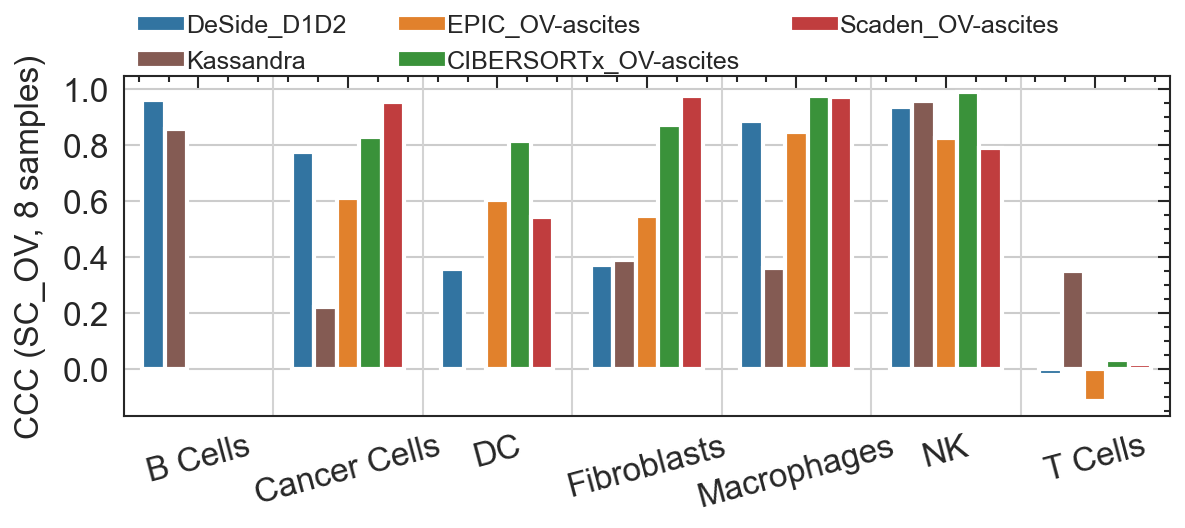

In [37]:
fig_dir = './results/reviewer2_q6/'
check_dir(fig_dir)
fig, ax4 = plt.subplots(1, 1, figsize=(4.5, 1.5))
# ds4
width = 0.75
hue_order_ds4 = algos
g4 = sns.barplot(algo_ct2ccc_df_ds4, x="Cell type", y="CCC", hue="Algorithm", palette=[algo2color[algo] for algo in hue_order_ds4], ax=ax4, hue_order=hue_order_ds4, width=width)
# g4legend = g4.legend()
sns.move_legend(g4, 'upper left',  bbox_to_anchor=(0, 1.22), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
# g4.legend([], [], frameon=False)
g4.set_xlabel('')
g4.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
g4.set_ylabel('CCC ' + '(' + f'SC_OV, {cell_prop_true.shape[0]} samples' ')')
ax4.grid(axis='y')
for _x in range(7):
    ax4.axvline(_x - 0.5, color='lightgray', linewidth=0.5)
ax4.tick_params(axis='x', labelrotation=15, labelsize=8)
# # ds2
# hue_order_ds2 = [i for i in algos if i in algo_ct2ccc_df_ds2['Algorithm'].unique()]
# g5 = sns.barplot(algo_ct2ccc_df_ds2, x="Cell type", y="CCC", hue="Algorithm", palette=[algo2color[algo] for algo in hue_order_ds2], ax=ax5, hue_order=hue_order_ds2)
# # g5legend = g5.legend()
# # sns.move_legend(g5, 'upper left',  bbox_to_anchor=(1, 1), ncol=2, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
# g5.legend([], [], frameon=False)
# g5.set_xlabel('')
# g5.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
# g5.set_ylabel('CCC ' + '(' + ds2 + ')')
# # ax5.yaxis.set_label_position("right")
# # plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'sc_ovarian_cancer_5algos_OV-ascites.svg'), dpi=300)

## SC_GBM dataset
- Model trained by the dataset D1+D2
- Model trained by the simulated dataset Scaden-Ascites (Scaden bulk)
- Model trained by the dataset generated by the scRNA-seq dataset, Ascites from Scaden (DeSide bulk)

### Ground truth

In [38]:
ds4 = 'SC_glioblastoma'
ind_ds_dir = '../datasets/Independent_Test_Set/to_xiongxin/'
cell_prop_true = pd.read_csv(f'{ind_ds_dir}/validation_datasets_cell_values/cell_values/{ds4}.csv', index_col=0)
print_df(cell_prop_true)

  >>  <<  
(3, 28)
              BT1160     BT1187      BT749      BT771      BT786  BT830  \
Macrophages        0  89.954338   0.000000   2.064897   0.471698      0   
Cancer Cells     100   3.652968  99.369085  96.755162  98.584906    100   

                   BT85      BT920  MGH100  MGH101  ...     MGH122     MGH124  \
Macrophages    0.000000   4.318937       0    23.5  ...  17.948718  11.351351   
Cancer Cells  99.591837  95.681063     100    76.5  ...  73.260073  88.378378   

                 MGH125     MGH128     MGH129     MGH136     MGH143  \
Macrophages   10.025063   0.000000   0.000000   0.000000   0.000000   
Cancer Cells  83.208020  86.413043  98.958333  99.134199  99.635036   

                 MGH151     MGH152      MGH66  
Macrophages    0.000000   0.000000   0.229358  
Cancer Cells  74.233129  99.563319  99.770642  

[2 rows x 28 columns]


In [39]:
cell_prop_true = cell_prop_true / 100

In [40]:
cell_prop_true.index.unique()

Index(['Macrophages', 'Cancer Cells', 'T Cells'], dtype='object')

In [41]:
cell_prop_true = cell_prop_true.T
cell_prop_true.head(2)

Macrophages  Cancer Cells   T Cells
BT1160     0.000000       1.00000  0.000000
BT1187     0.899543       0.03653  0.063927

### Predicted by Scaden-GBM

In [43]:
pred_dir = './R2Q6/scaden/scRNAseq_ds_read_counts/gbm_abdelfattah_12/predicted_results/'
ds2file_name = {'SC_glioblastoma': 'scaden_gbm_abdelfattah_12_pred_cell_prop_SC_glioblastoma.txt'}
cell_prop_pred_scaden = []
for ds, file in ds2file_name.items():
    current_result = pd.read_csv(os.path.join(pred_dir, file), index_col=0, sep='\t')
    current_result['datasets'] = ds
    print(ds, current_result.shape)
    cell_prop_pred_scaden.append(current_result)
cell_prop_pred_scaden_df = pd.concat(cell_prop_pred_scaden)
cell_prop_pred_scaden_df['algo'] = 'Scaden_GBM'
name_mapping = cell_type_name_mapping.copy()
name_mapping['index'] = 'sample_id'
cell_prop_pred_scaden_df.reset_index(inplace=True)
cell_prop_pred_scaden_df.rename(columns=name_mapping, inplace=True)
cell_prop_pred_scaden_df['T Cells'] = cell_prop_pred_scaden_df.loc[:, ['CD4 T', 'CD8 T']].sum(axis=1)
# print(cell_prop_pred_scaden_df.head(2))
# cell_prop_pred_scaden_df['Lymphocytes'] = cell_prop_pred_scaden_df.loc[:, ['T Cells', 'NK']].sum(axis=1)
# cell_prop_pred_scaden_df['Macrophages'] = cell_prop_pred_scaden_df['Monocytes'].copy()
cell_prop_pred_scaden_df.head(2)

SC_glioblastoma (28, 14)


sample_id  Mast Cells  Neutrophils        NK     CD4 T  Cancer Cells  \
0    BT1160    0.006677     0.004685  0.009609  0.003870      0.885843   
1    BT1187    0.017253     0.008307  0.015161  0.016581      0.009340   

   Monocytes   B Cells  Endothelial Cells  Macrophages  Double-neg-like T  \
0   0.003624  0.010605           0.009626     0.009144           0.007585   
1   0.026529  0.011552           0.006729     0.766661           0.018671   

   Fibroblasts     CD8 T        DC         datasets        algo   T Cells  
0     0.015053  0.023806  0.009873  SC_glioblastoma  Scaden_GBM  0.027677  
1     0.007701  0.024108  0.071407  SC_glioblastoma  Scaden_GBM  0.040688

### Predicted by DeSide-D1D2

In [44]:
pred_cell_prop_dir = '../results/whole_workflow_20231110_12ds_subtypes/DeSide_03_new_ds_subtypes_all_range/Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering/'
result_dir = os.path.join(pred_cell_prop_dir, 'SC_GBM')
check_dir(result_dir)
y_pred_file_path = os.path.join(result_dir, 'y_predicted_result_sc_gbm_deside_d1d2.csv')
if not os.path.exists(y_pred_file_path):
    bulk_tpm_file_path_ds1 = os.path.join(ind_ds_dir, 'validation_datasets_expression', 'SC_glioblastoma_expressions.tsv')
    model_dir = os.path.join(pred_cell_prop_dir, f'DeSide_model')

    deside_model = DeSide(model_dir=model_dir)
    deside_model.predict(input_file=bulk_tpm_file_path_ds1,
                         output_file_path=y_pred_file_path,
                         exp_type='TPM', transpose=True, scaling_by_sample=False,
                         scaling_by_constant=True,
                         # new parameters
                         hyper_params=deside_parameters, pathway_mask=pathway_mask)

In [45]:
y_pred = pd.read_csv(y_pred_file_path, index_col=0)
y_pred.head(2)

Plasma B cells  Non-plasma B cells  CD4 T  CD8 T effector  \
BT1160             0.0               0.001  0.001             0.0   
BT1187             0.0               0.001  0.005             0.0   

        CD8 T (GZMK high)  Double-neg-like T     DC  Endothelial Cells  CAFs  \
BT1160              0.000              0.000  0.001              0.007   0.0   
BT1187              0.013              0.002  0.159              0.002   0.0   

        Myofibroblasts  Macrophages  Mast Cells   NK  Neutrophils  Monocytes  \
BT1160           0.000        0.000       0.002  0.0        0.000      0.001   
BT1187           0.001        0.639       0.051  0.0        0.002      0.001   

        1-others  Cancer Cells  
BT1160     0.988         0.988  
BT1187     0.124         0.124

In [46]:
t_cells = ['CD4 T', 'CD8 T effector', 'CD8 T (GZMK high)', 'Double-neg-like T']
pred_cell_frac_deside_d1d2 = y_pred.copy()
pred_cell_frac_deside_d1d2['T Cells'] = pred_cell_frac_deside_d1d2[t_cells].sum(axis=1)
# pred_cell_frac_deside_ascites_bulk['Macrophages'] = pred_cell_frac_deside_ascites_bulk['Monocytes'].copy()
pred_cell_frac_deside_d1d2['datasets'] = 'SC_GBM'
pred_cell_frac_deside_d1d2['algo'] = 'DeSide_D1D2'
pred_cell_frac_deside_d1d2.index.name = 'sample_id'
pred_cell_frac_deside_d1d2.reset_index(inplace=True)
pred_cell_frac_deside_d1d2.head(2)

sample_id  Plasma B cells  Non-plasma B cells  CD4 T  CD8 T effector  \
0    BT1160             0.0               0.001  0.001             0.0   
1    BT1187             0.0               0.001  0.005             0.0   

   CD8 T (GZMK high)  Double-neg-like T     DC  Endothelial Cells  CAFs  ...  \
0              0.000              0.000  0.001              0.007   0.0  ...   
1              0.013              0.002  0.159              0.002   0.0  ...   

   Macrophages  Mast Cells   NK  Neutrophils  Monocytes  1-others  \
0        0.000       0.002  0.0        0.000      0.001     0.988   
1        0.639       0.051  0.0        0.002      0.001     0.124   

   Cancer Cells  T Cells  datasets         algo  
0         0.988    0.001    SC_GBM  DeSide_D1D2  
1         0.124    0.020    SC_GBM  DeSide_D1D2  

[2 rows x 21 columns]

### Predicted by EPIC-GBM

In [47]:
pred_by_epic = pd.read_csv('./Yerong/PNAS_3_algorithm_data_240616/predict_kassandra_data-R2Q6/EPIC/gbm_abdelfattah_12_reference_predicted_results/SC_glioblastoma.csv', index_col=0)
pred_by_epic.rename(columns=cell_type_name_mapping, inplace=True)
pred_by_epic.head(2)

B Cells         CD4 T     CD8 T        DC  Endothelial Cells  \
BT1160  0.023018  8.548815e-08  0.000040  0.000020           0.001523   
BT1187  0.000044  3.676394e-03  0.066617  0.318888           0.000002   

        Fibroblasts   Macrophages  Mast Cells  Monocytes       NK  \
BT1160     0.001070  2.117916e-08    0.000160   0.098736  0.00110   
BT1187     0.001508  1.837006e-01    0.122233   0.073283  0.00126   

        Neutrophils  Cancer Cells  
BT1160     0.023561      0.850773  
BT1187     0.228746      0.000041

In [48]:
pred_by_epic.shape

(28, 12)

In [49]:
pred_by_epic.columns.to_list()

['B Cells',
 'CD4 T',
 'CD8 T',
 'DC',
 'Endothelial Cells',
 'Fibroblasts',
 'Macrophages',
 'Mast Cells',
 'Monocytes',
 'NK',
 'Neutrophils',
 'Cancer Cells']

In [50]:
# pred_by_epic['Macrophages'] = pred_by_epic_ascites_ov['Monocytes']
pred_by_epic['T Cells'] = pred_by_epic[['CD4 T', 'CD8 T']].sum(axis=1)
pred_by_epic['datasets'] = 'SC_GBM'
pred_by_epic['algo'] = 'EPIC_GBM'
pred_by_epic.index.name = 'sample_id'
pred_by_epic.reset_index(inplace=True)
pred_by_epic.head(2)

sample_id   B Cells         CD4 T     CD8 T        DC  Endothelial Cells  \
0    BT1160  0.023018  8.548815e-08  0.000040  0.000020           0.001523   
1    BT1187  0.000044  3.676394e-03  0.066617  0.318888           0.000002   

   Fibroblasts   Macrophages  Mast Cells  Monocytes       NK  Neutrophils  \
0     0.001070  2.117916e-08    0.000160   0.098736  0.00110     0.023561   
1     0.001508  1.837006e-01    0.122233   0.073283  0.00126     0.228746   

   Cancer Cells   T Cells datasets      algo  
0      0.850773  0.000040   SC_GBM  EPIC_GBM  
1      0.000041  0.070293   SC_GBM  EPIC_GBM

### Predicted by CIBERSORTx-GBM

In [51]:
pred_by_cibersortx = pd.read_csv('./Yerong/PNAS_3_algorithm_data_240616/predict_kassandra_data-R2Q6/CIBERSORT/gbm_abdelfattah_12_reference_predicted_results/SC_glioblastoma.csv', index_col=0)
pred_by_cibersortx.head(2)

B Cells  CD4 T     CD8 T  Cancer Cells        DC  Double-neg-like T  \
Mixture                                                                         
BT1160   0.019865    0.0  0.015729      0.964407  0.000000                0.0   
BT1187   0.000000    0.0  0.018352      0.000000  0.409706                0.0   

         Endothelial Cells  Fibroblasts  Macrophages  Mast Cells  Monocytes  \
Mixture                                                                       
BT1160                 0.0     0.000000     0.000000    0.000000   0.000000   
BT1187                 0.0     0.003627     0.492488    0.048252   0.027575   

          NK  Neutrophils  P-value  Correlation      RMSE  
Mixture                                                    
BT1160   0.0            0        0     0.419360  0.952839  
BT1187   0.0            0        0     0.800002  0.619948

In [52]:
pred_by_cibersortx.shape

(28, 16)

In [53]:
# pred_by_cibersortx['Macrophages'] = pred_by_cibersortx_ascites_ov['Monocytes']
pred_by_cibersortx['T Cells'] = pred_by_cibersortx[['CD4 T', 'CD8 T', 'Double-neg-like T']].sum(axis=1)
pred_by_cibersortx['datasets'] = 'SC_GBM'
pred_by_cibersortx['algo'] = 'CIBERSORTx_GBM'
pred_by_cibersortx.index.name = 'sample_id'
pred_by_cibersortx.reset_index(inplace=True)
pred_by_cibersortx.head(2)

sample_id   B Cells  CD4 T     CD8 T  Cancer Cells        DC  \
0    BT1160  0.019865    0.0  0.015729      0.964407  0.000000   
1    BT1187  0.000000    0.0  0.018352      0.000000  0.409706   

   Double-neg-like T  Endothelial Cells  Fibroblasts  Macrophages  Mast Cells  \
0                0.0                0.0     0.000000     0.000000    0.000000   
1                0.0                0.0     0.003627     0.492488    0.048252   

   Monocytes   NK  Neutrophils  P-value  Correlation      RMSE   T Cells  \
0   0.000000  0.0            0        0     0.419360  0.952839  0.015729   
1   0.027575  0.0            0        0     0.800002  0.619948  0.018352   

  datasets            algo  
0   SC_GBM  CIBERSORTx_GBM  
1   SC_GBM  CIBERSORTx_GBM

### Predicted by Kassandra

In [54]:
pred_by_kassandra = pd.read_csv('../datasets/Independent_Test_Set/to_xiongxin/validation_datasets_predicted_by_algorithms/predicted_by_algorithms/Kassandra/SC_glioblastoma_predicted_by_Kassandra.csv', index_col=0).T
pred_by_kassandra = pred_by_kassandra / 100
pred_by_kassandra.head(2)

B Cells     CD4 T     CD8 T  Endothelial Cells  Fibroblasts  \
BT1160  0.000411  0.000067  0.000529           0.000166     0.000210   
BT1187  0.001560  0.030189  0.012977           0.000179     0.000675   

        Lymphocytes  Macrophages  Monocytes        NK  Neutrophils  \
BT1160     0.000398     0.000104   0.000559  0.000350     0.000068   
BT1187     0.067433     0.554189   0.085037  0.002875     0.003458   

        Non-plasma B cells  Plasma B cells   T Cells  Cancer Cells  
BT1160            0.000117        0.000294  0.000597      0.997535  
BT1187            0.001171        0.000389  0.043166      0.308861

In [55]:
pred_by_kassandra.shape

(28, 14)

In [56]:
# pred_by_kassandra['Macrophages'] = pred_by_cibersortx_ascites_ov['Monocytes']
pred_by_kassandra['T Cells'] = pred_by_kassandra[['CD4 T', 'CD8 T']].sum(axis=1)
pred_by_kassandra['datasets'] = 'SC_GBM'
pred_by_kassandra['algo'] = 'Kassandra'
pred_by_kassandra.index.name = 'sample_id'
pred_by_kassandra.reset_index(inplace=True)
pred_by_kassandra.head(2)

sample_id   B Cells     CD4 T     CD8 T  Endothelial Cells  Fibroblasts  \
0    BT1160  0.000411  0.000067  0.000529           0.000166     0.000210   
1    BT1187  0.001560  0.030189  0.012977           0.000179     0.000675   

   Lymphocytes  Macrophages  Monocytes        NK  Neutrophils  \
0     0.000398     0.000104   0.000559  0.000350     0.000068   
1     0.067433     0.554189   0.085037  0.002875     0.003458   

   Non-plasma B cells  Plasma B cells   T Cells  Cancer Cells datasets  \
0            0.000117        0.000294  0.000597      0.997535   SC_GBM   
1            0.001171        0.000389  0.043166      0.308861   SC_GBM   

        algo  
0  Kassandra  
1  Kassandra

### Combining different parts and comparison

In [57]:
pred_cell_frac_sc_gbm = pd.concat([cell_prop_pred_scaden_df, pred_cell_frac_deside_d1d2, 
                                   pred_by_cibersortx, pred_by_epic, pred_by_kassandra])
pred_cell_frac_sc_gbm.head(2)

sample_id  Mast Cells  Neutrophils        NK     CD4 T  Cancer Cells  \
0    BT1160    0.006677     0.004685  0.009609  0.003870      0.885843   
1    BT1187    0.017253     0.008307  0.015161  0.016581      0.009340   

   Monocytes   B Cells  Endothelial Cells  Macrophages  ...  \
0   0.003624  0.010605           0.009626     0.009144  ...   
1   0.026529  0.011552           0.006729     0.766661  ...   

   Non-plasma B cells  CD8 T effector  CD8 T (GZMK high)  CAFs Myofibroblasts  \
0                 NaN             NaN                NaN   NaN            NaN   
1                 NaN             NaN                NaN   NaN            NaN   

  1-others  P-value  Correlation  RMSE  Lymphocytes  
0      NaN      NaN          NaN   NaN          NaN  
1      NaN      NaN          NaN   NaN          NaN  

[2 rows x 28 columns]

In [58]:
pred_cell_frac_sc_gbm = pd.melt(pred_cell_frac_sc_gbm, id_vars=['sample_id', 'datasets', 'algo'], value_name='cell_proportion')
pred_cell_frac_sc_gbm.rename(columns={'variable': 'cell_type'}, inplace=True)
pred_cell_frac_sc_gbm.head(2)

sample_id         datasets        algo   cell_type  cell_proportion
0    BT1160  SC_glioblastoma  Scaden_GBM  Mast Cells         0.006677
1    BT1187  SC_glioblastoma  Scaden_GBM  Mast Cells         0.017253

In [59]:
pred_cell_frac_sc_gbm['algo'].unique()

array(['Scaden_GBM', 'DeSide_D1D2', 'CIBERSORTx_GBM', 'EPIC_GBM',
       'Kassandra'], dtype=object)

In [60]:
algo_ct2ccc = {}
for (algo, cell_type), group in pred_cell_frac_sc_gbm.groupby(['algo', 'cell_type']):
    # print(algo, cell_type)
    if cell_type in cell_prop_true.columns:
        group['cell_proportion_pred'] = group['cell_proportion']
        # if algo not in ['DeSide', 'Scaden_ascites']:
        #     group['cell_proportion_pred'] = group['cell_proportion'] / 100
        group = group.set_index('sample_id')
        # print('group', group.shape)
        current_true = cell_prop_true.loc[:, [cell_type]].copy()
        # print(current_true)
        group_new = current_true.join(group, how='inner')
        print(algo, cell_type, group_new.shape)
        # print(group_new)
        algo_ct2ccc[(algo, cell_type)] = get_ccc(group_new[cell_type], group_new['cell_proportion_pred'])
algo_ct2ccc_df_ds4 = pd.DataFrame.from_dict(algo_ct2ccc, orient='index', columns=['CCC'])
# algo_ct2ccc_df = algo_ct2ccc_df.reset_index()
algo_ct2ccc_df_ds4['Algorithm'] = algo_ct2ccc_df_ds4.index.map(lambda x: x[0].replace('_matrix_with_BC', ''))
algo_ct2ccc_df_ds4['Cell type'] = algo_ct2ccc_df_ds4.index.map(lambda x: x[1])
print_df(algo_ct2ccc_df_ds4)

CIBERSORTx_GBM Cancer Cells (28, 6)
CIBERSORTx_GBM Macrophages (28, 6)
CIBERSORTx_GBM T Cells (28, 6)
DeSide_D1D2 Cancer Cells (28, 6)
DeSide_D1D2 Macrophages (28, 6)
DeSide_D1D2 T Cells (28, 6)
EPIC_GBM Cancer Cells (28, 6)
EPIC_GBM Macrophages (28, 6)
EPIC_GBM T Cells (28, 6)
Kassandra Cancer Cells (28, 6)
Kassandra Macrophages (28, 6)
Kassandra T Cells (28, 6)
Scaden_GBM Cancer Cells (28, 6)
Scaden_GBM Macrophages (28, 6)
Scaden_GBM T Cells (28, 6)
  >>  <<  
(15, 3)
                                     CCC       Algorithm     Cell type
(CIBERSORTx_GBM, Cancer Cells)  0.848424  CIBERSORTx_GBM  Cancer Cells
(CIBERSORTx_GBM, Macrophages)   0.808180  CIBERSORTx_GBM   Macrophages


In [61]:
algo_ct2ccc_df_ds4.shape

(15, 3)

In [62]:
algo_ct2ccc_df_ds4

CCC       Algorithm     Cell type
(CIBERSORTx_GBM, Cancer Cells)  0.848424  CIBERSORTx_GBM  Cancer Cells
(CIBERSORTx_GBM, Macrophages)   0.808180  CIBERSORTx_GBM   Macrophages
(CIBERSORTx_GBM, T Cells)       0.959989  CIBERSORTx_GBM       T Cells
(DeSide_D1D2, Cancer Cells)     0.943776     DeSide_D1D2  Cancer Cells
(DeSide_D1D2, Macrophages)      0.953357     DeSide_D1D2   Macrophages
(DeSide_D1D2, T Cells)          0.983514     DeSide_D1D2       T Cells
(EPIC_GBM, Cancer Cells)        0.300148        EPIC_GBM  Cancer Cells
(EPIC_GBM, Macrophages)         0.324351        EPIC_GBM   Macrophages
(EPIC_GBM, T Cells)             0.976386        EPIC_GBM       T Cells
(Kassandra, Cancer Cells)       0.873949       Kassandra  Cancer Cells
(Kassandra, Macrophages)        0.896959       Kassandra   Macrophages
(Kassandra, T Cells)            0.947570       Kassandra       T Cells
(Scaden_GBM, Cancer Cells)      0.848704      Scaden_GBM  Cancer Cells
(Scaden_GBM, Macrophages)       0.976965      Scaden_GBM   Macrophages
(Scaden_GBM, T Cells)           0.892077      Scaden_GBM       T Cells

In [63]:
algo_ct2ccc_df_ds4['Algorithm'].unique()

array(['CIBERSORTx_GBM', 'DeSide_D1D2', 'EPIC_GBM', 'Kassandra',
       'Scaden_GBM'], dtype=object)

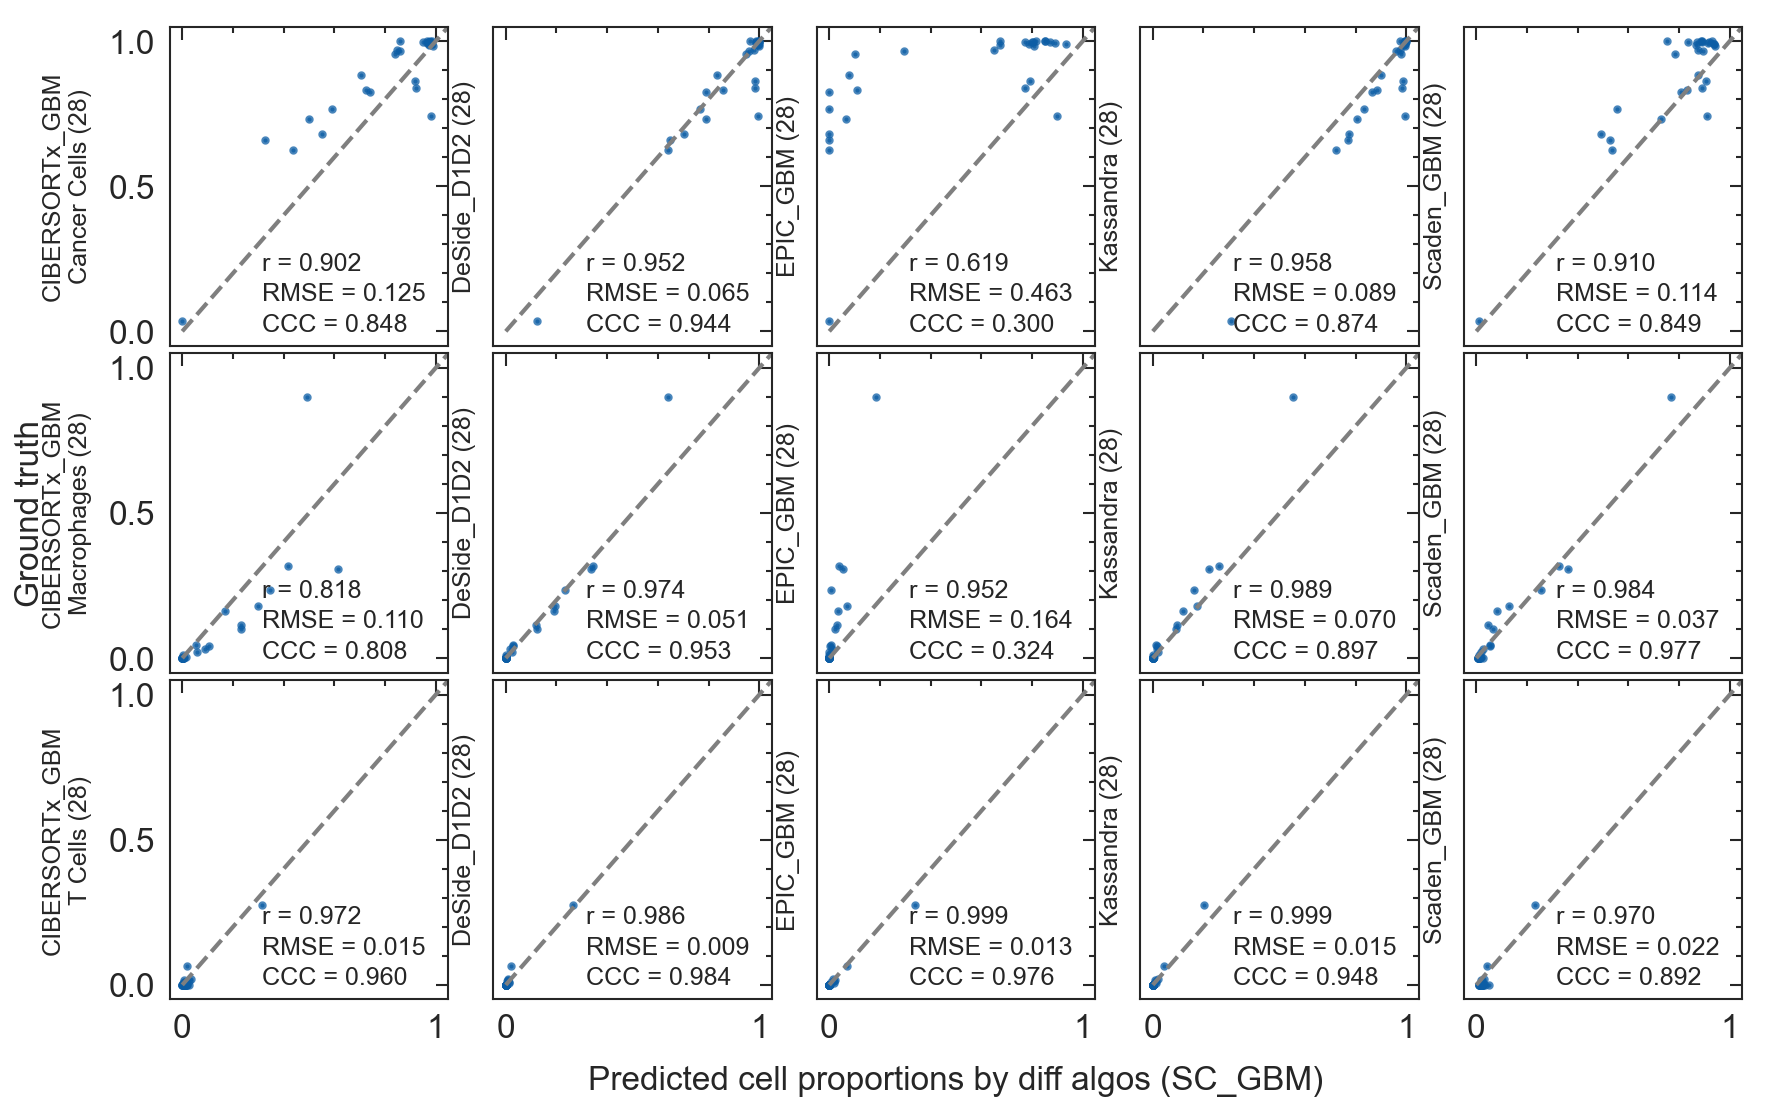

In [66]:
from deside.plot import compare_y_y_pred_plot_cpe

fig_dir = './results/reviewer2_q5/'
cols = ['CIBERSORTx_GBM', 'DeSide_D1D2', 'EPIC_GBM', 'Kassandra', 'Scaden_GBM']
rows = ['Cancer Cells', 'Macrophages', 'T Cells']

n_cols = len(cols)
n_rows = len(rows)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharex='all', sharey='all', figsize=(6.5, 4))
metrics_value = {}
for j in range(n_cols):
    for i in range(n_rows):
        current_algo = cols[j]
        current_ct = rows[i]
        if current_ct in cell_prop_true.columns:
            current_data = pred_cell_frac_sc_gbm.loc[(pred_cell_frac_sc_gbm['algo'] == current_algo) & (pred_cell_frac_sc_gbm['cell_type'] == current_ct), :].copy()
            current_data['cell_prop_pred'] = current_data['cell_proportion']
            current_data.set_index('sample_id', inplace=True)
            # print('current_data', current_data)
            current_true = cell_prop_true.loc[:, [current_ct]].copy()
            current_data = current_true.join(current_data, how='inner')
            # print(current_data.shape)
            if j == 0:
                current_type = current_algo + '\n' + current_ct
            else:
                current_type = current_algo
            corr, rmse, ccc = compare_y_y_pred_plot_cpe(y_pred=current_data['cell_prop_pred'],
                                                        y_true=current_data[current_ct],
                                                        show_metrics=True, ax=axes[i, j],
                                                        cancer_type=current_type,
                                                        inx=(i, j))
            metrics_value[current_type] = {'corr': corr, 'rmse': rmse, 'ccc': ccc}
metrics_value_df = pd.DataFrame.from_dict(metrics_value, orient='index')
metrics_value_df.to_csv(os.path.join(fig_dir, 'pred_cell_prop_vs_ground_truth_SC_GBM-3algo-metrics.csv'))

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Predicted cell proportions by diff algos (SC_GBM)', labelpad=5)
plt.ylabel("Ground truth", labelpad=15)

plt.tight_layout(h_pad=0.02, w_pad=0.15)
plt.savefig(os.path.join(fig_dir, 'pred_cell_prop_vs_ground_truth-3algo_SC_GBM.png'), dpi=300)

In [67]:
algo_ct2ccc_df_ds4['Algorithm'].unique()

array(['CIBERSORTx_GBM', 'DeSide_D1D2', 'EPIC_GBM', 'Kassandra',
       'Scaden_GBM'], dtype=object)

In [68]:
selected_colors = [sns.color_palette('tab20')[0]] + [sns.color_palette('tab20')[10]] + \
                  [sns.color_palette('tab20')[2]] + [sns.color_palette('tab20')[4]] + \
                  [sns.color_palette('tab20')[6]]

sns.color_palette(selected_colors)

sns.color_palette(selected_colors)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)]

In [69]:
algos = ['DeSide_D1D2', 'Kassandra', 'EPIC_GBM', 
         'CIBERSORTx_GBM', 'Scaden_GBM']
algo2color = {algos[i]: selected_colors[i] for i in range(5)}

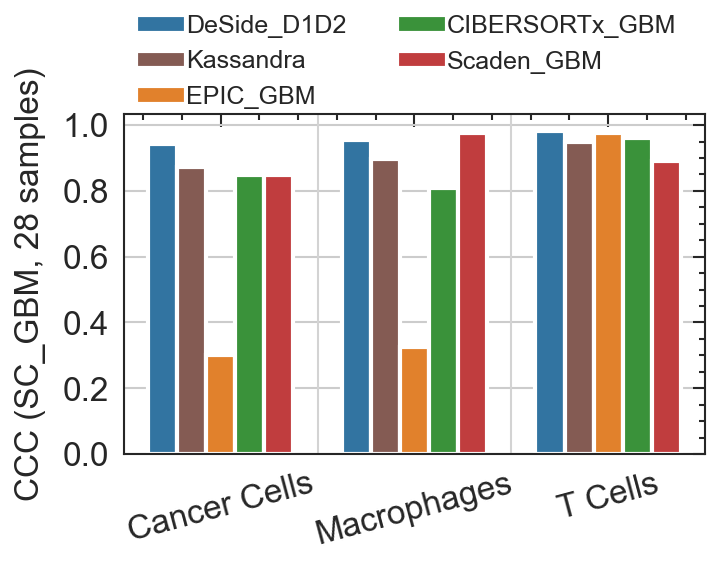

In [73]:
fig_dir = './results/reviewer2_q6/'
fig, ax4 = plt.subplots(1, 1, figsize=(2.5, 1.5))
# ds4
width = 0.75
hue_order_ds4 = algos
g4 = sns.barplot(algo_ct2ccc_df_ds4, x="Cell type", y="CCC", hue="Algorithm", palette=[algo2color[algo] for algo in hue_order_ds4], ax=ax4, hue_order=hue_order_ds4, width=width)
# g4legend = g4.legend()
sns.move_legend(g4, 'upper left',  bbox_to_anchor=(0, 1.33), ncol=2, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
# g4.legend([], [], frameon=False)
g4.set_xlabel('')
g4.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
g4.set_ylabel('CCC ' + '(' + f'SC_GBM, {cell_prop_true.shape[0]} samples' + ')')
ax4.grid(axis='y')
for _x in range(3):
    ax4.axvline(_x - 0.5, color='lightgray', linewidth=0.5)
ax4.tick_params(axis='x', labelrotation=15, labelsize=8)
# # ds2
# hue_order_ds2 = [i for i in algos if i in algo_ct2ccc_df_ds2['Algorithm'].unique()]
# g5 = sns.barplot(algo_ct2ccc_df_ds2, x="Cell type", y="CCC", hue="Algorithm", palette=[algo2color[algo] for algo in hue_order_ds2], ax=ax5, hue_order=hue_order_ds2)
# # g5legend = g5.legend()
# # sns.move_legend(g5, 'upper left',  bbox_to_anchor=(1, 1), ncol=2, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
# g5.legend([], [], frameon=False)
# g5.set_xlabel('')
# g5.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
# g5.set_ylabel('CCC ' + '(' + ds2 + ')')
# # ax5.yaxis.set_label_position("right")
# # plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'sc_gbm_5algos.svg'), dpi=300)

## SC_HNSCC dataset

### Ground truth

In [74]:
ds4 = 'SC_HNSCC'
ind_ds_dir = '../datasets/Independent_Test_Set/to_xiongxin/'
cell_prop_true = pd.read_csv(f'{ind_ds_dir}/validation_datasets_cell_values/cell_values/{ds4}.csv', index_col=0)
print_df(cell_prop_true)

  >>  <<  
(14, 22)
       lymph_node_20  lymph_node_25  lymph_node_26  lymph_node_28  \
CD4 T            0.0      22.068966       0.350877       0.823045   
DC               0.0       0.689655       0.701754       0.000000   

       lymph_node_5  primary_10  primary_12  primary_13  primary_16  \
CD4 T           0.0    2.298851   48.630137    9.756098   31.578947   
DC              0.0    0.000000    0.000000   36.585366    1.228070   

       primary_17  ...  primary_22  primary_23  primary_24  primary_25  \
CD4 T     13.4375  ...    0.000000   47.058824    0.813008   11.325301   
DC         0.0000  ...    0.507614    0.000000    0.000000    1.686747   

       primary_26  primary_28  primary_5  primary_6  primary_7  primary_8  
CD4 T    1.587302         0.0   5.714286        0.0        0.0  18.811881  
DC       0.793651         0.0   0.000000        0.0        0.0   0.000000  

[2 rows x 22 columns]


In [75]:
cell_prop_true = cell_prop_true / 100

In [76]:
cell_prop_true.index.unique()

Index(['CD4 T', 'DC', 'Endothelial Cells', 'Fibroblasts', 'Macrophages',
       'Mast_cells', 'Myofibroblasts', 'Non-plasma B cells', 'Plasma B cells',
       'Cancer Cells', 'CD8 T', 'T Cells', 'B Cells', 'Lymphocytes'],
      dtype='object')

In [77]:
cell_prop_true = cell_prop_true.T
cell_prop_true.head(2)

CD4 T        DC  Endothelial Cells  Fibroblasts  Macrophages  \
lymph_node_20  0.00000  0.000000                0.0     0.000000     0.000000   
lymph_node_25  0.22069  0.006897                0.0     0.031034     0.006897   

               Mast_cells  Myofibroblasts  Non-plasma B cells  Plasma B cells  \
lymph_node_20    0.000000        0.002924            0.000000        0.000000   
lymph_node_25    0.010345        0.331034            0.003448        0.089655   

               Cancer Cells     CD8 T   T Cells   B Cells  Lymphocytes  
lymph_node_20      0.997076  0.000000  0.000000  0.000000     0.000000  
lymph_node_25      0.258621  0.041379  0.262069  0.093103     0.355172

### Predicted by Scaden-HNSCC

In [78]:
pred_dir = './R2Q6/scaden/scRNAseq_ds_read_counts/HNSCC_Kurten2021_3CA/predicted_results/'
ds2file_name = {'SC_HNSCC': 'scaden_HNSCC_Kurten2021_3CA_pred_cell_prop_SC_HNSCC.txt'}
cell_prop_pred_scaden = []
for ds, file in ds2file_name.items():
    current_result = pd.read_csv(os.path.join(pred_dir, file), index_col=0, sep='\t')
    current_result['datasets'] = ds
    print(ds, current_result.shape)
    cell_prop_pred_scaden.append(current_result)
cell_prop_pred_scaden_df = pd.concat(cell_prop_pred_scaden)
cell_prop_pred_scaden_df['algo'] = 'Scaden_HNSCC'
name_mapping = {'T_cell': 'T Cells', 'B_cell': 'B Cells', 'Dendritic': 'DC', 'Macrophage': 'Macrophages', 'Endothelial': 'Endothelial Cells', 'Fibroblast': 'Fibroblasts',
                'Malignant': 'Cancer Cells'}
name_mapping['index'] = 'sample_id'
cell_prop_pred_scaden_df.reset_index(inplace=True)
cell_prop_pred_scaden_df.rename(columns=name_mapping, inplace=True)
# cell_prop_pred_scaden_df['T Cells'] = cell_prop_pred_scaden_df.loc[:, ['CD4 T', 'CD8 T']].sum(axis=1)
# print(cell_prop_pred_scaden_df.head(2))
# cell_prop_pred_scaden_df['Lymphocytes'] = cell_prop_pred_scaden_df.loc[:, ['T Cells', 'NK']].sum(axis=1)
# cell_prop_pred_scaden_df['Macrophages'] = cell_prop_pred_scaden_df['Monocytes'].copy()
cell_prop_pred_scaden_df.head(2)

SC_HNSCC (22, 12)


sample_id  Endothelial Cells  Fibroblasts        DC   B Cells  \
0  lymph_node_20           0.008147     0.020916  0.010915  0.006531   
1  lymph_node_25           0.025601     0.231405  0.036691  0.040598   

   Lymphovascular  Cancer Cells   T Cells  Macrophages    Plasma  Epithelial  \
0        0.024640      0.764298  0.006572     0.005497  0.018444    0.120949   
1        0.033085      0.149734  0.197511     0.034226  0.159348    0.058352   

       Mast  datasets          algo  
0  0.013093  SC_HNSCC  Scaden_HNSCC  
1  0.033448  SC_HNSCC  Scaden_HNSCC

### Predicted by DeSide-D1D2

In [79]:
pred_cell_prop_dir = '../results/whole_workflow_20231110_12ds_subtypes/DeSide_03_new_ds_subtypes_all_range/Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering/'
result_dir = os.path.join(pred_cell_prop_dir, 'SC_HNSCC')
check_dir(result_dir)
y_pred_file_path = os.path.join(result_dir, 'y_predicted_result_sc_hnscc_deside_d1d2.csv')
if not os.path.exists(y_pred_file_path):
    bulk_tpm_file_path_ds1 = os.path.join(ind_ds_dir, 'validation_datasets_expression', 'SC_HNSCC_expressions.tsv')
    model_dir = os.path.join(pred_cell_prop_dir, f'DeSide_model')

    deside_model = DeSide(model_dir=model_dir)
    deside_model.predict(input_file=bulk_tpm_file_path_ds1,
                         output_file_path=y_pred_file_path,
                         exp_type='TPM', transpose=True, scaling_by_sample=False,
                         scaling_by_constant=True,
                         # new parameters
                         hyper_params=deside_parameters, pathway_mask=pathway_mask)

In [80]:
y_pred = pd.read_csv(y_pred_file_path, index_col=0)
y_pred.head(2)

Plasma B cells  Non-plasma B cells  CD4 T  CD8 T effector  \
lymph_node_20           0.000               0.000  0.002           0.000   
lymph_node_25           0.103               0.012  0.020           0.001   

               CD8 T (GZMK high)  Double-neg-like T     DC  Endothelial Cells  \
lymph_node_20              0.000              0.000  0.000              0.002   
lymph_node_25              0.014              0.267  0.008              0.003   

               CAFs  Myofibroblasts  Macrophages  Mast Cells   NK  \
lymph_node_20  0.00           0.002        0.001       0.001  0.0   
lymph_node_25  0.03           0.292        0.000       0.013  0.0   

               Neutrophils  Monocytes  1-others  Cancer Cells  
lymph_node_20          0.0        0.0     0.993         0.993  
lymph_node_25          0.0        0.0     0.236         0.236

In [81]:
t_cells = ['CD4 T', 'CD8 T effector', 'CD8 T (GZMK high)', 'Double-neg-like T']
fib = ['CAFs', 'Myofibroblasts']
b_cells = ['Plasma B cells', 'Non-plasma B cells']
pred_cell_frac_deside_d1d2 = y_pred.copy()
pred_cell_frac_deside_d1d2['B Cells'] = pred_cell_frac_deside_d1d2[b_cells].sum(axis=1)
pred_cell_frac_deside_d1d2['CD8 T'] = pred_cell_frac_deside_d1d2[['CD8 T effector', 'CD8 T (GZMK high)']].sum(axis=1)
pred_cell_frac_deside_d1d2['T Cells'] = pred_cell_frac_deside_d1d2[t_cells].sum(axis=1)
pred_cell_frac_deside_d1d2['Lymphocytes'] = pred_cell_frac_deside_d1d2.loc[:, ['T Cells', 'NK']].sum(axis=1)
pred_cell_frac_deside_d1d2['Fibroblasts'] = pred_cell_frac_deside_d1d2[fib].sum(axis=1)
# pred_cell_frac_deside_ascites_bulk['Macrophages'] = pred_cell_frac_deside_ascites_bulk['Monocytes'].copy()
pred_cell_frac_deside_d1d2['datasets'] = 'SC_HNSCC'
pred_cell_frac_deside_d1d2['algo'] = 'DeSide_D1D2'
pred_cell_frac_deside_d1d2.index.name = 'sample_id'
pred_cell_frac_deside_d1d2.reset_index(inplace=True)
pred_cell_frac_deside_d1d2.head(2)

sample_id  Plasma B cells  Non-plasma B cells  CD4 T  CD8 T effector  \
0  lymph_node_20           0.000               0.000  0.002           0.000   
1  lymph_node_25           0.103               0.012  0.020           0.001   

   CD8 T (GZMK high)  Double-neg-like T     DC  Endothelial Cells  CAFs  ...  \
0              0.000              0.000  0.000              0.002  0.00  ...   
1              0.014              0.267  0.008              0.003  0.03  ...   

   Monocytes  1-others  Cancer Cells  B Cells  CD8 T  T Cells  Lymphocytes  \
0        0.0     0.993         0.993    0.000  0.000    0.002        0.002   
1        0.0     0.236         0.236    0.115  0.015    0.302        0.302   

   Fibroblasts  datasets         algo  
0        0.002  SC_HNSCC  DeSide_D1D2  
1        0.322  SC_HNSCC  DeSide_D1D2  

[2 rows x 25 columns]

### Predicted by EPIC-HNSCC

In [82]:
pred_by_epic = pd.read_csv('./Yerong/PNAS_3_algorithm_data_240616/predict_kassandra_data-R2Q6/EPIC/HNSCC_Kürten2021_3CA_predicted_results/SC_HNSCC.csv', index_col=0)
pred_by_epic.rename(columns=cell_type_name_mapping, inplace=True)
pred_by_epic.head(2)

B Cells        DC  Endothelial Cells  Fibroblasts  \
lymph_node_20  5.299306e-08  0.071350           0.015359     0.006626   
lymph_node_25  1.390950e-02  0.307444           0.078866     0.128230   

               Macrophages  Mast Cells   T Cells  Cancer Cells  
lymph_node_20     0.002042    0.000016  0.002012      0.902594  
lymph_node_25     0.002476    0.009342  0.154753      0.304980

In [83]:
pred_by_epic.shape

(22, 8)

In [84]:
pred_by_epic.columns.to_list()

['B Cells',
 'DC',
 'Endothelial Cells',
 'Fibroblasts',
 'Macrophages',
 'Mast Cells',
 'T Cells',
 'Cancer Cells']

In [85]:
# pred_by_epic['Macrophages'] = pred_by_epic_ascites_ov['Monocytes']
# pred_by_epic['T Cells'] = pred_by_epic[['CD4 T', 'CD8 T']].sum(axis=1)
pred_by_epic['datasets'] = 'SC_HNSCC'
pred_by_epic['algo'] = 'EPIC_HNSCC'
pred_by_epic.index.name = 'sample_id'
pred_by_epic.reset_index(inplace=True)
pred_by_epic.head(2)

sample_id       B Cells        DC  Endothelial Cells  Fibroblasts  \
0  lymph_node_20  5.299306e-08  0.071350           0.015359     0.006626   
1  lymph_node_25  1.390950e-02  0.307444           0.078866     0.128230   

   Macrophages  Mast Cells   T Cells  Cancer Cells  datasets        algo  
0     0.002042    0.000016  0.002012      0.902594  SC_HNSCC  EPIC_HNSCC  
1     0.002476    0.009342  0.154753      0.304980  SC_HNSCC  EPIC_HNSCC

### Predicted by CIBERSORTx-HNSCC

In [86]:
pred_by_cibersortx = pd.read_csv('../datasets/Independent_Test_Set/to_xiongxin/validation_datasets_predicted_by_algorithms/predicted_by_algorithms/HNSC_matrix_with_BC_CIBERSORTX/SC_HNSCC_predicted_by_HNSC_matrix_with_BC_CIBERSORTX.csv', index_col=0).T
pred_by_cibersortx.head(2)

CD8 T     CD4 T  Fibroblasts  Macrophages   B Cells  \
lymph_node_20  0.000116  0.019960     0.142266     0.000000  0.001585   
lymph_node_25  0.153927  2.690862     5.455307     0.078891  0.877057   

               Cancer Cells  Mast Cells        DC  Endothelial Cells   T Cells  
lymph_node_20     99.732351    0.000477  0.096198           0.007047  0.020076  
lymph_node_25     90.158997    0.104075  0.439148           0.041737  2.844789

In [87]:
pred_by_cibersortx = pred_by_cibersortx / 100
pred_by_cibersortx.head(2)

CD8 T     CD4 T  Fibroblasts  Macrophages   B Cells  \
lymph_node_20  0.000001  0.000200     0.001423     0.000000  0.000016   
lymph_node_25  0.001539  0.026909     0.054553     0.000789  0.008771   

               Cancer Cells  Mast Cells        DC  Endothelial Cells   T Cells  
lymph_node_20      0.997324    0.000005  0.000962           0.000070  0.000201  
lymph_node_25      0.901590    0.001041  0.004391           0.000417  0.028448

In [88]:
pred_by_cibersortx.shape

(22, 10)

In [89]:
# pred_by_cibersortx['Macrophages'] = pred_by_cibersortx_ascites_ov['Monocytes']
# pred_by_cibersortx['T Cells'] = pred_by_cibersortx[['CD4 T', 'CD8 T']].sum(axis=1)
pred_by_cibersortx['datasets'] = 'SC_HNSCC'
pred_by_cibersortx['algo'] = 'CIBERSORTx_HNSCC'
pred_by_cibersortx.index.name = 'sample_id'
pred_by_cibersortx.reset_index(inplace=True)
pred_by_cibersortx.head(2)

sample_id     CD8 T     CD4 T  Fibroblasts  Macrophages   B Cells  \
0  lymph_node_20  0.000001  0.000200     0.001423     0.000000  0.000016   
1  lymph_node_25  0.001539  0.026909     0.054553     0.000789  0.008771   

   Cancer Cells  Mast Cells        DC  Endothelial Cells   T Cells  datasets  \
0      0.997324    0.000005  0.000962           0.000070  0.000201  SC_HNSCC   
1      0.901590    0.001041  0.004391           0.000417  0.028448  SC_HNSCC   

               algo  
0  CIBERSORTx_HNSCC  
1  CIBERSORTx_HNSCC

### Predicted by Kassandra

In [90]:
pred_by_kassandra = pd.read_csv('../datasets/Independent_Test_Set/to_xiongxin/validation_datasets_predicted_by_algorithms/predicted_by_algorithms/Kassandra/SC_HNSCC_predicted_by_Kassandra.csv', index_col=0).T
pred_by_kassandra = pred_by_kassandra / 100
pred_by_kassandra.head(2)

B Cells     CD4 T     CD8 T  Endothelial Cells  Fibroblasts  \
lymph_node_20  0.000128  0.000014  0.000307           0.001555     0.002950   
lymph_node_25  0.036146  0.172337  0.032045           0.000014     0.024349   

               Lymphocytes  Macrophages  Monocytes        NK  Neutrophils  \
lymph_node_20     0.000199      0.00005   0.000294  0.000049     0.000000   
lymph_node_25     0.221286      0.00545   0.001904  0.001032     0.000135   

               Non-plasma B cells  Plasma B cells   T Cells  Cancer Cells  
lymph_node_20            0.000092        0.000036  0.000321      0.994653  
lymph_node_25            0.002445        0.033701  0.204383      0.726588

In [91]:
pred_by_kassandra.shape

(22, 14)

In [92]:
# pred_by_kassandra['Macrophages'] = pred_by_cibersortx_ascites_ov['Monocytes']
# pred_by_kassandra['T Cells'] = pred_by_kassandra[['CD4 T', 'CD8 T']].sum(axis=1)
pred_by_kassandra['datasets'] = 'SC_HNSCC'
pred_by_kassandra['algo'] = 'Kassandra'
pred_by_kassandra.index.name = 'sample_id'
pred_by_kassandra.reset_index(inplace=True)
pred_by_kassandra.head(2)

sample_id   B Cells     CD4 T     CD8 T  Endothelial Cells  \
0  lymph_node_20  0.000128  0.000014  0.000307           0.001555   
1  lymph_node_25  0.036146  0.172337  0.032045           0.000014   

   Fibroblasts  Lymphocytes  Macrophages  Monocytes        NK  Neutrophils  \
0     0.002950     0.000199      0.00005   0.000294  0.000049     0.000000   
1     0.024349     0.221286      0.00545   0.001904  0.001032     0.000135   

   Non-plasma B cells  Plasma B cells   T Cells  Cancer Cells  datasets  \
0            0.000092        0.000036  0.000321      0.994653  SC_HNSCC   
1            0.002445        0.033701  0.204383      0.726588  SC_HNSCC   

        algo  
0  Kassandra  
1  Kassandra

### Combining different parts and comparison

In [93]:
pred_cell_frac_sc_hnscc = pd.concat([cell_prop_pred_scaden_df, pred_cell_frac_deside_d1d2,
                                    pred_by_cibersortx, pred_by_epic, pred_by_kassandra])
pred_cell_frac_sc_hnscc.head(2)

sample_id  Endothelial Cells  Fibroblasts        DC   B Cells  \
0  lymph_node_20           0.008147     0.020916  0.010915  0.006531   
1  lymph_node_25           0.025601     0.231405  0.036691  0.040598   

   Lymphovascular  Cancer Cells   T Cells  Macrophages    Plasma  ...  \
0        0.024640      0.764298  0.006572     0.005497  0.018444  ...   
1        0.033085      0.149734  0.197511     0.034226  0.159348  ...   

   Double-neg-like T  CAFs Myofibroblasts Mast Cells  NK  Neutrophils  \
0                NaN   NaN            NaN        NaN NaN          NaN   
1                NaN   NaN            NaN        NaN NaN          NaN   

   Monocytes  1-others  CD8 T  Lymphocytes  
0        NaN       NaN    NaN          NaN  
1        NaN       NaN    NaN          NaN  

[2 rows x 29 columns]

In [94]:
pred_cell_frac_sc_hnscc = pd.melt(pred_cell_frac_sc_hnscc, id_vars=['sample_id', 'datasets', 'algo'], value_name='cell_proportion')
pred_cell_frac_sc_hnscc.rename(columns={'variable': 'cell_type'}, inplace=True)
pred_cell_frac_sc_hnscc.head(2)

sample_id  datasets          algo          cell_type  cell_proportion
0  lymph_node_20  SC_HNSCC  Scaden_HNSCC  Endothelial Cells         0.008147
1  lymph_node_25  SC_HNSCC  Scaden_HNSCC  Endothelial Cells         0.025601

In [95]:
pred_cell_frac_sc_hnscc['algo'].unique()

array(['Scaden_HNSCC', 'DeSide_D1D2', 'CIBERSORTx_HNSCC', 'EPIC_HNSCC',
       'Kassandra'], dtype=object)

In [96]:
algo_ct2ccc = {}
for (algo, cell_type), group in pred_cell_frac_sc_hnscc.groupby(['algo', 'cell_type']):
    # print(algo, cell_type)
    if cell_type in cell_prop_true.columns:
        group['cell_proportion_pred'] = group['cell_proportion']
        # if algo not in ['DeSide', 'Scaden_ascites']:
        #     group['cell_proportion_pred'] = group['cell_proportion'] / 100
        group = group.set_index('sample_id')
        # print('group', group.shape)
        current_true = cell_prop_true.loc[:, [cell_type]].copy()
        # print(current_true)
        group_new = current_true.join(group, how='inner')
        print(algo, cell_type, group_new.shape)
        # print(group_new)
        algo_ct2ccc[(algo, cell_type)] = get_ccc(group_new[cell_type], group_new['cell_proportion_pred'])
algo_ct2ccc_df_ds4 = pd.DataFrame.from_dict(algo_ct2ccc, orient='index', columns=['CCC'])
# algo_ct2ccc_df = algo_ct2ccc_df.reset_index()
algo_ct2ccc_df_ds4['Algorithm'] = algo_ct2ccc_df_ds4.index.map(lambda x: x[0].replace('_matrix_with_BC', ''))
algo_ct2ccc_df_ds4['Cell type'] = algo_ct2ccc_df_ds4.index.map(lambda x: x[1])
print_df(algo_ct2ccc_df_ds4)

CIBERSORTx_HNSCC B Cells (22, 6)
CIBERSORTx_HNSCC CD4 T (22, 6)
CIBERSORTx_HNSCC CD8 T (22, 6)
CIBERSORTx_HNSCC Cancer Cells (22, 6)
CIBERSORTx_HNSCC DC (22, 6)
CIBERSORTx_HNSCC Endothelial Cells (22, 6)
CIBERSORTx_HNSCC Fibroblasts (22, 6)
CIBERSORTx_HNSCC Lymphocytes (22, 6)
CIBERSORTx_HNSCC Macrophages (22, 6)
CIBERSORTx_HNSCC Myofibroblasts (22, 6)
CIBERSORTx_HNSCC Non-plasma B cells (22, 6)
CIBERSORTx_HNSCC Plasma B cells (22, 6)
CIBERSORTx_HNSCC T Cells (22, 6)
DeSide_D1D2 B Cells (22, 6)
DeSide_D1D2 CD4 T (22, 6)
DeSide_D1D2 CD8 T (22, 6)
DeSide_D1D2 Cancer Cells (22, 6)
DeSide_D1D2 DC (22, 6)
DeSide_D1D2 Endothelial Cells (22, 6)
DeSide_D1D2 Fibroblasts (22, 6)
DeSide_D1D2 Lymphocytes (22, 6)
DeSide_D1D2 Macrophages (22, 6)
DeSide_D1D2 Myofibroblasts (22, 6)
DeSide_D1D2 Non-plasma B cells (22, 6)
DeSide_D1D2 Plasma B cells (22, 6)
DeSide_D1D2 T Cells (22, 6)
EPIC_HNSCC B Cells (22, 6)
EPIC_HNSCC CD4 T (22, 6)
EPIC_HNSCC CD8 T (22, 6)
EPIC_HNSCC Cancer Cells (22, 6)
EPIC_HNSCC D

In [97]:
algo_ct2ccc_df_ds4.shape

(65, 3)

In [98]:
algo_ct2ccc_df_ds4

CCC         Algorithm  \
(CIBERSORTx_HNSCC, B Cells)         0.175003  CIBERSORTx_HNSCC   
(CIBERSORTx_HNSCC, CD4 T)           0.157267  CIBERSORTx_HNSCC   
(CIBERSORTx_HNSCC, CD8 T)           0.178973  CIBERSORTx_HNSCC   
(CIBERSORTx_HNSCC, Cancer Cells)    0.056598  CIBERSORTx_HNSCC   
(CIBERSORTx_HNSCC, DC)              0.155063  CIBERSORTx_HNSCC   
...                                      ...               ...   
(Scaden_HNSCC, Macrophages)         0.935370      Scaden_HNSCC   
(Scaden_HNSCC, Myofibroblasts)           NaN      Scaden_HNSCC   
(Scaden_HNSCC, Non-plasma B cells)       NaN      Scaden_HNSCC   
(Scaden_HNSCC, Plasma B cells)           NaN      Scaden_HNSCC   
(Scaden_HNSCC, T Cells)             0.989250      Scaden_HNSCC   

                                             Cell type  
(CIBERSORTx_HNSCC, B Cells)                    B Cells  
(CIBERSORTx_HNSCC, CD4 T)                        CD4 T  
(CIBERSORTx_HNSCC, CD8 T)                        CD8 T  
(CIBERSORTx_HNSCC, Cancer Cells)          Cancer Cells  
(CIBERSORTx_HNSCC, DC)                              DC  
...                                                ...  
(Scaden_HNSCC, Macrophages)                Macrophages  
(Scaden_HNSCC, Myofibroblasts)          Myofibroblasts  
(Scaden_HNSCC, Non-plasma B cells)  Non-plasma B cells  
(Scaden_HNSCC, Plasma B cells)          Plasma B cells  
(Scaden_HNSCC, T Cells)                        T Cells  

[65 rows x 3 columns]

Kassandra DC


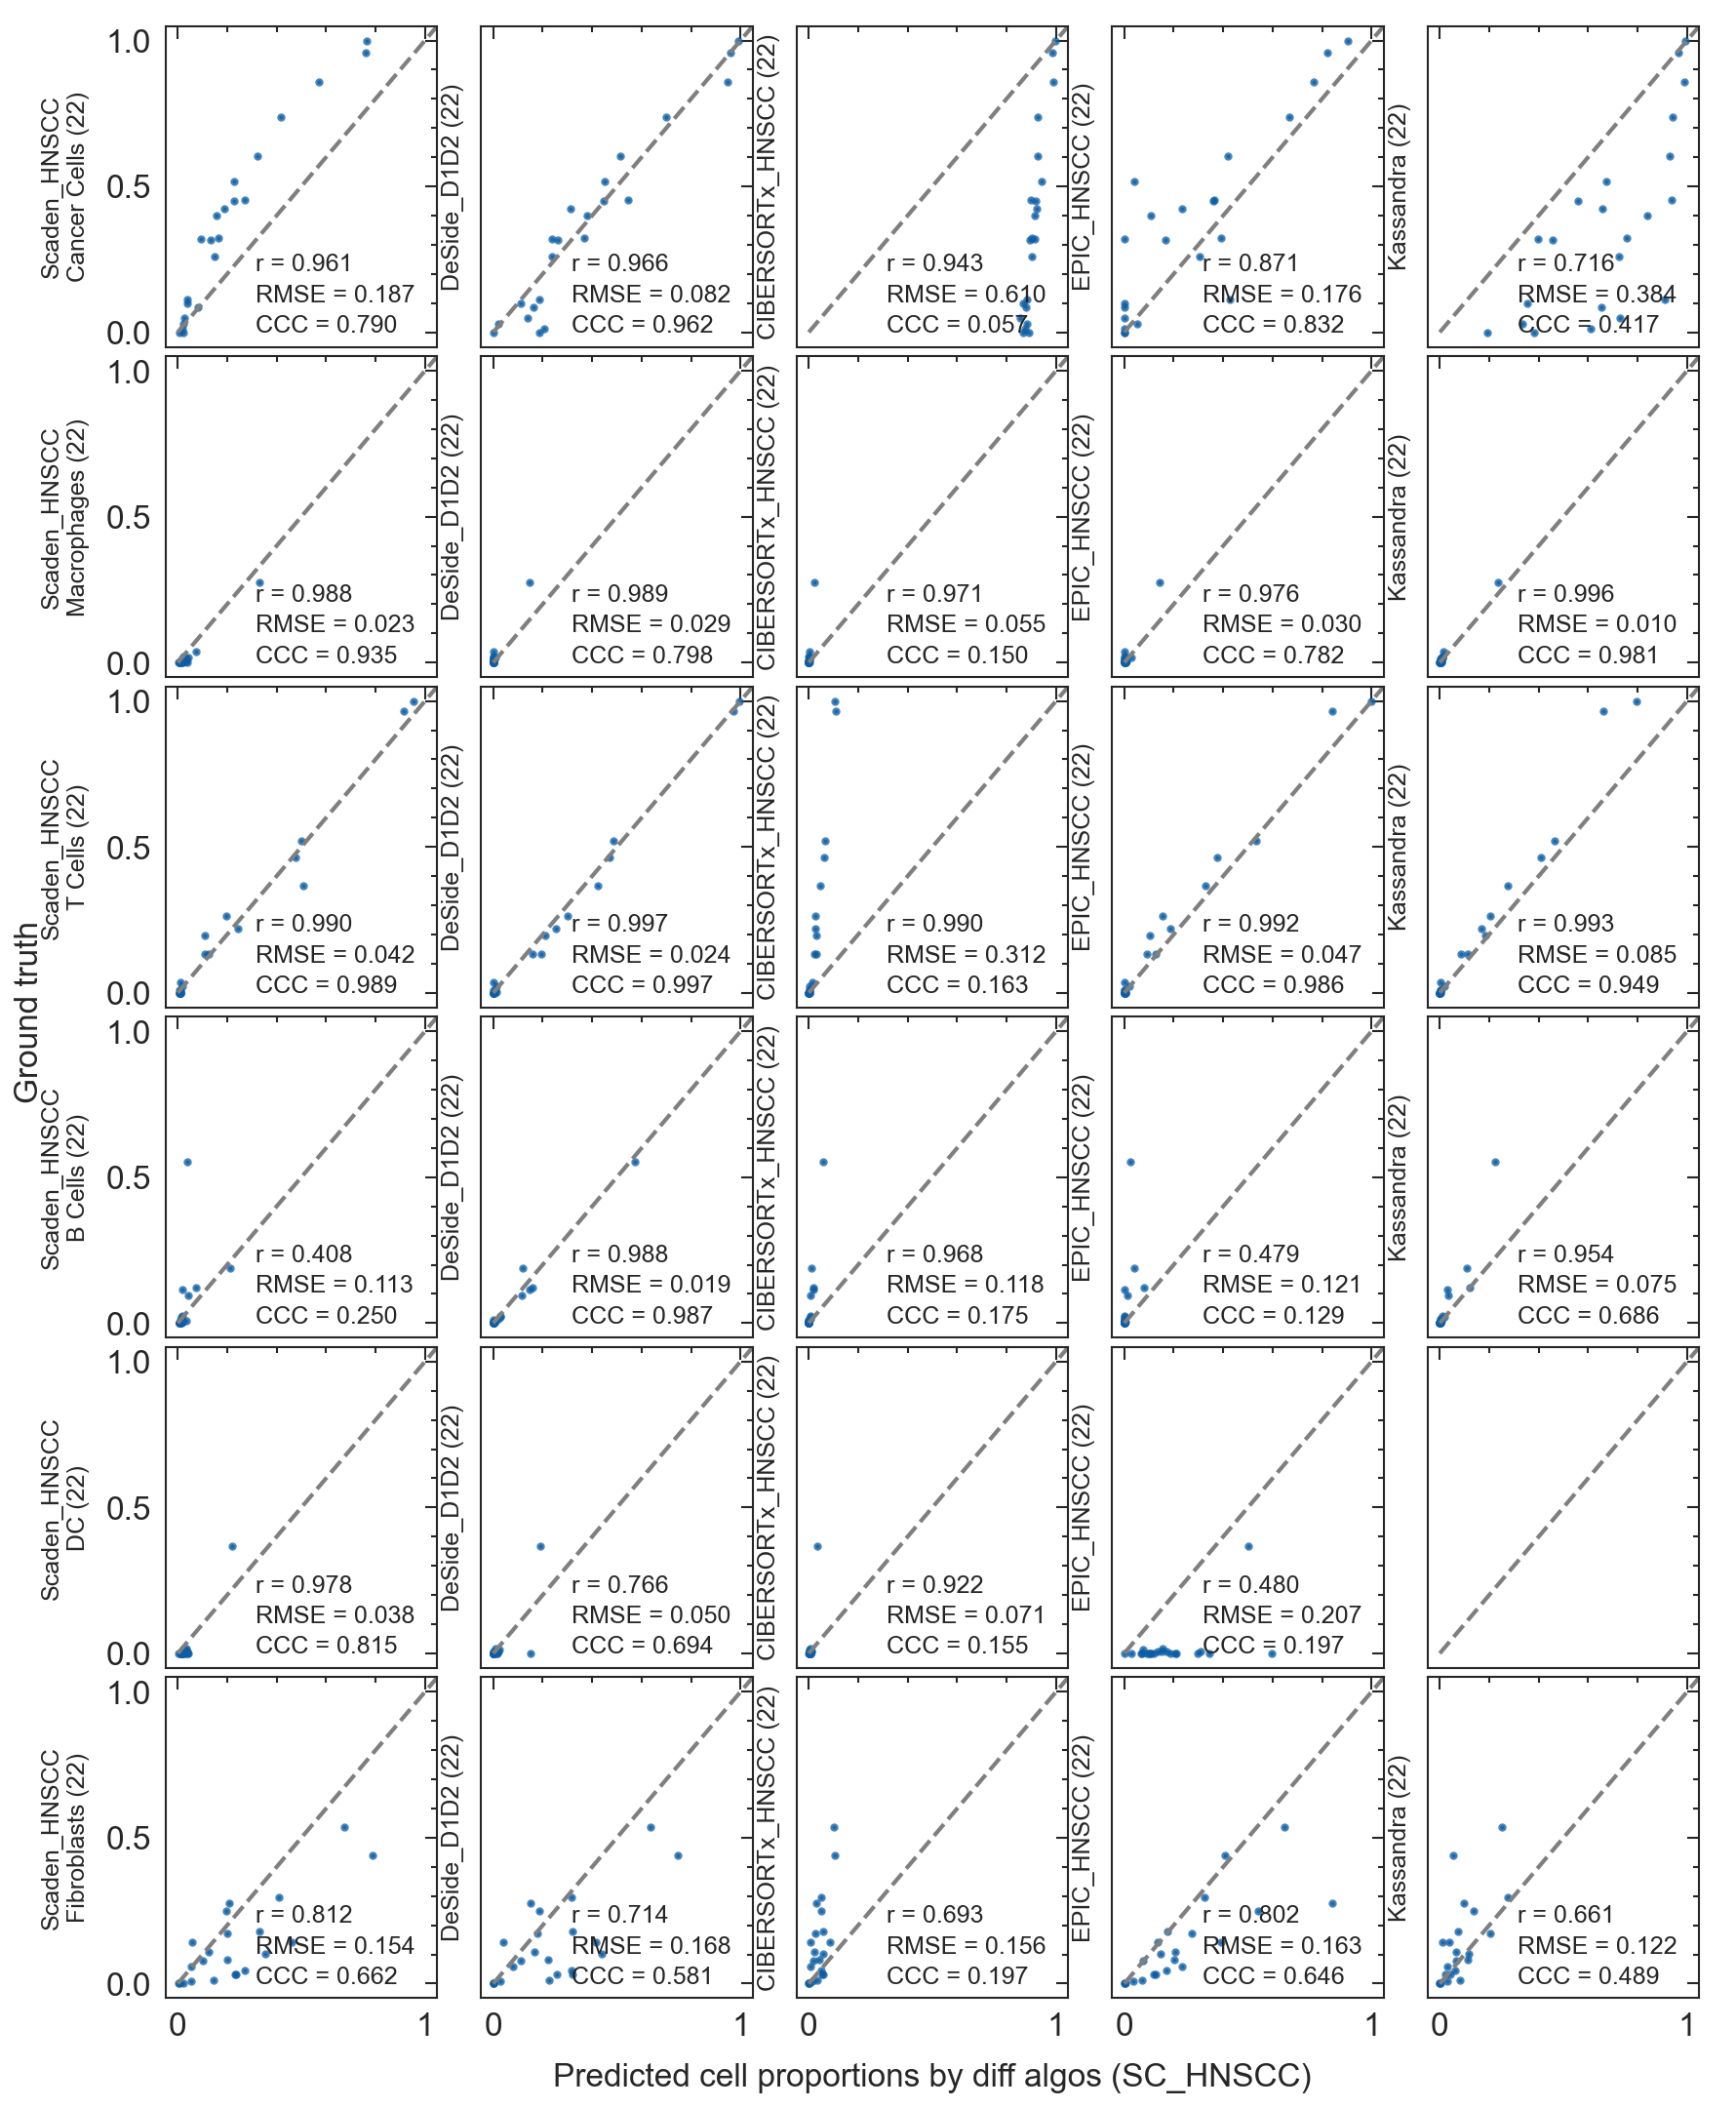

In [100]:
from deside.plot import compare_y_y_pred_plot_cpe

fig_dir = './results/reviewer2_q5/'
cols = ['Scaden_HNSCC', 'DeSide_D1D2', 'CIBERSORTx_HNSCC', 'EPIC_HNSCC', 'Kassandra']

rows = ['Cancer Cells', 'Macrophages', 'T Cells', 'B Cells', 'DC', 'Fibroblasts']
n_cols = len(cols)
n_rows = len(rows)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharex='all', sharey='all', figsize=(6.5, 7.5))
metrics_value = {}
for j in range(n_cols):
    for i in range(n_rows):
        current_algo = cols[j]
        current_ct = rows[i]
        if current_ct in cell_prop_true.columns:
            current_data = pred_cell_frac_sc_hnscc.loc[(pred_cell_frac_sc_hnscc['algo'] == current_algo) & (pred_cell_frac_sc_hnscc['cell_type'] == current_ct), :].copy()
            current_data['cell_prop_pred'] = current_data['cell_proportion']
            current_data.set_index('sample_id', inplace=True)
            # print('current_data', current_data)
            current_true = cell_prop_true.loc[:, [current_ct]].copy()
            current_data = current_true.join(current_data, how='inner')
            # print(current_data.shape)
            if j == 0:
                current_type = current_algo + '\n' + current_ct
            else:
                current_type = current_algo
            try:
                corr, rmse, ccc = compare_y_y_pred_plot_cpe(y_pred=current_data['cell_prop_pred'],
                                                            y_true=current_data[current_ct],
                                                            show_metrics=True, ax=axes[i, j],
                                                            cancer_type=current_type,
                                                            inx=(i, j))
                metrics_value[current_type] = {'corr': corr, 'rmse': rmse, 'ccc': ccc}
            except:
                print(current_algo, current_ct)
metrics_value_df = pd.DataFrame.from_dict(metrics_value, orient='index')
metrics_value_df.to_csv(os.path.join(fig_dir, 'pred_cell_prop_vs_ground_truth_SC_HNSCC-3algo-metrics.csv'))

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Predicted cell proportions by diff algos (SC_HNSCC)', labelpad=5)
plt.ylabel("Ground truth", labelpad=15)

plt.tight_layout(h_pad=0.02, w_pad=0.15)
plt.savefig(os.path.join(fig_dir, 'pred_cell_prop_vs_ground_truth-5algo_SC_HNSCC.png'), dpi=300)

In [101]:
algo_ct2ccc_df_ds4['Algorithm'].unique()

array(['CIBERSORTx_HNSCC', 'DeSide_D1D2', 'EPIC_HNSCC', 'Kassandra',
       'Scaden_HNSCC'], dtype=object)

In [102]:
selected_colors = [sns.color_palette('tab20')[0]] + [sns.color_palette('tab20')[10]] + \
                  [sns.color_palette('tab20')[2]] + [sns.color_palette('tab20')[4]] + \
                  [sns.color_palette('tab20')[6]]

sns.color_palette(selected_colors)

sns.color_palette(selected_colors)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)]

In [103]:
algos = ['DeSide_D1D2', 'Kassandra', 'EPIC_HNSCC', 
         'CIBERSORTx_HNSCC', 'Scaden_HNSCC']
algo2color = {algos[i]: selected_colors[i] for i in range(5)}

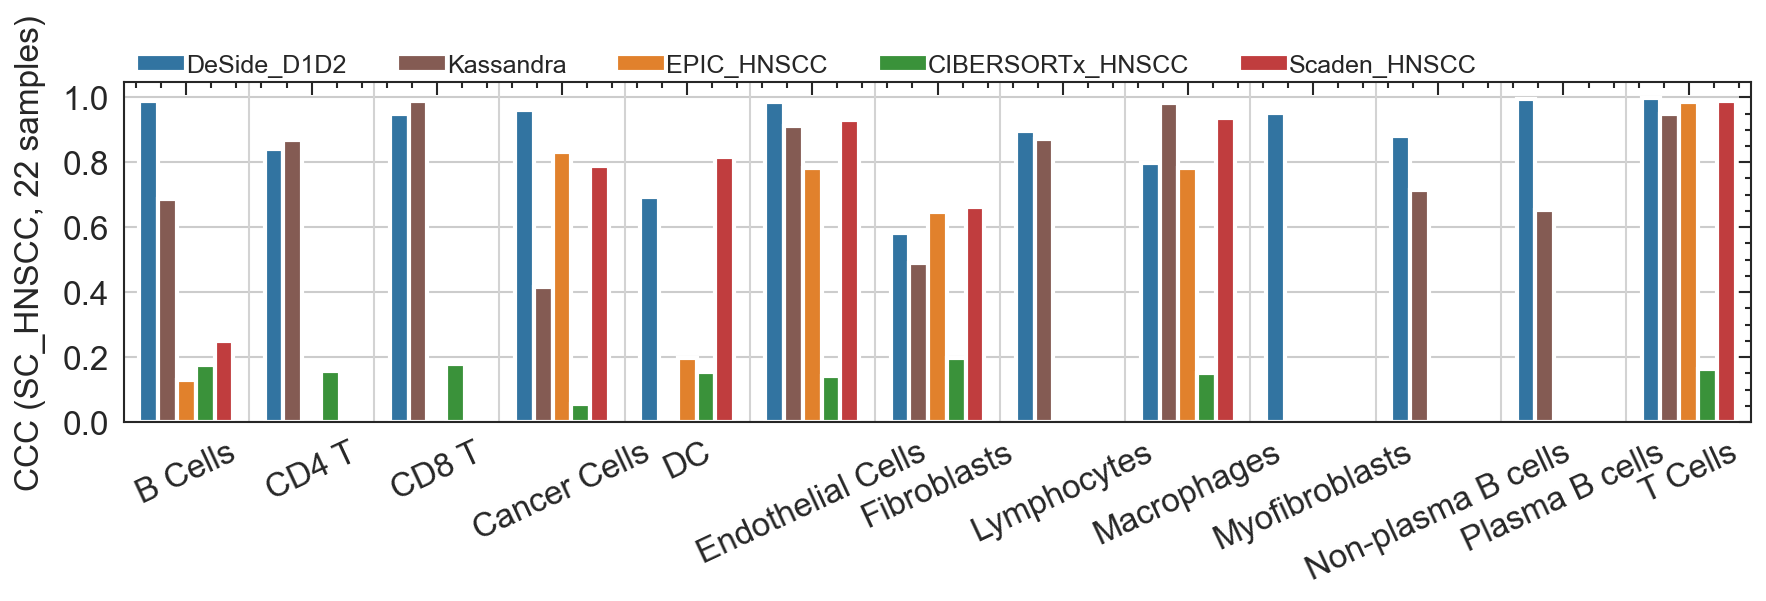

In [104]:
fig_dir = './results/reviewer2_q6/'
fig, ax4 = plt.subplots(1, 1, figsize=(7, 1.5))
# ds4
width = 0.75
hue_order_ds4 = algos
g4 = sns.barplot(algo_ct2ccc_df_ds4, x="Cell type", y="CCC", hue="Algorithm", palette=[algo2color[algo] for algo in hue_order_ds4], ax=ax4, hue_order=hue_order_ds4, width=width)
# g4legend = g4.legend()
sns.move_legend(g4, 'upper left',  bbox_to_anchor=(0, 1.12), ncol=5, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
# g4.legend([], [], frameon=False)
g4.set_xlabel('')
g4.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
g4.set_ylabel('CCC ' + '(' + f'SC_HNSCC, {cell_prop_true.shape[0]} samples' + ')')
ax4.grid(axis='y')
for _x in range(13):
    ax4.axvline(_x - 0.5, color='lightgray', linewidth=0.5)
ax4.tick_params(axis='x', labelrotation=25, labelsize=8)
# # ds2
# hue_order_ds2 = [i for i in algos if i in algo_ct2ccc_df_ds2['Algorithm'].unique()]
# g5 = sns.barplot(algo_ct2ccc_df_ds2, x="Cell type", y="CCC", hue="Algorithm", palette=[algo2color[algo] for algo in hue_order_ds2], ax=ax5, hue_order=hue_order_ds2)
# # g5legend = g5.legend()
# # sns.move_legend(g5, 'upper left',  bbox_to_anchor=(1, 1), ncol=2, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
# g5.legend([], [], frameon=False)
# g5.set_xlabel('')
# g5.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
# g5.set_ylabel('CCC ' + '(' + ds2 + ')')
# # ax5.yaxis.set_label_position("right")
# # plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'sc_hnscc_5algos.svg'), dpi=300)

## Comparing with CPE across 19 cancer types

### Ascites-OV

In [52]:
ds = 'Scaden-simu(OV-ascites)'
ccc_deside_scaden_simu_ascites = pd.read_csv(f'../results/whole_workflow_20240517_use_scaden_ascites_bulk/DeSide_01_scaden_ascites_ds_deside_model/ascite_scaden/predicted_cell_fraction_tcga/pred_cancer_cell_prop_vs_cpe-deside-metrics.csv', index_col=0)
ccc_deside_scaden_simu_ascites.index.name = 'cancer_type'
ccc_deside_scaden_simu_ascites['model'] = f'DeSide_{ds}'
print(ccc_deside_scaden_simu_ascites.shape)
ccc_deside_scaden_simu_ascites.head(2)

(19, 4)


corr      rmse       ccc                           model
cancer_type                                                              
ACC          0.705985  0.371188  0.083436  DeSide_Scaden-simu(OV-ascites)
BLCA         0.684749  0.132604  0.650189  DeSide_Scaden-simu(OV-ascites)

In [53]:
ds = 'OV-ascites'
ccc_scaden_scaden_simu_ascites = pd.read_csv(f'./R2Q6/scaden/scRNAseq_ds_read_counts/merged_pred_results/pred_cancer_cell_prop_vs_cpe-Scaden_scaden_ascites_OV-metrics.csv', index_col=0)
ccc_scaden_scaden_simu_ascites.index.name = 'cancer_type'
ccc_scaden_scaden_simu_ascites['model'] = f'Scaden_{ds}'
print(ccc_scaden_scaden_simu_ascites.shape)
ccc_scaden_scaden_simu_ascites.head(2)

(19, 4)


corr      rmse       ccc              model
cancer_type                                                 
ACC          0.616410  0.574710  0.021978  Scaden_OV-ascites
BLCA         0.667762  0.134578  0.589109  Scaden_OV-ascites

In [54]:
ds = 'D1D2'
deside_d1d2 = pd.read_csv(f'../results/whole_workflow_20231110_12ds_subtypes/DeSide_03_new_ds_subtypes_all_range/Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering/predicted_cell_fraction_tcga/pred_cancer_cell_prop_vs_cpe-DeSide_D1D2-metrics.csv', index_col=0)
deside_d1d2.index.name = 'cancer_type'
deside_d1d2['model'] = f'DeSide_{ds}'
print(deside_d1d2.shape)
deside_d1d2.head(2)

(19, 4)


corr      rmse       ccc        model
cancer_type                                           
ACC          0.784109  0.134205  0.555562  DeSide_D1D2
BLCA         0.722290  0.130579  0.681812  DeSide_D1D2

In [55]:
ds = 'OV-ascites'
epic_ov_ascites = pd.read_csv(f'./Yerong/PNAS_3_algorithm_data_240616/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-EPIC_scaden_ascites_OV-metrics.csv', index_col=0)
epic_ov_ascites.index.name = 'cancer_type'
epic_ov_ascites['model'] = f'EPIC_{ds}'
print(epic_ov_ascites.shape)
epic_ov_ascites.head(2)

(19, 4)


corr      rmse       ccc            model
cancer_type                                               
ACC          0.326491  0.159738  0.275909  EPIC_OV-ascites
BLCA         0.578131  0.296012  0.380665  EPIC_OV-ascites

In [56]:
# ds = 'OV-ascites'
cibersortx_ov_ascites = pd.read_csv(f'./Yerong/PNAS_3_algorithm_data_240616/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-CIBERSORTX_scaden_ascites_OV-metrics.csv', index_col=0)
cibersortx_ov_ascites.index.name = 'cancer_type'
cibersortx_ov_ascites['model'] = f'CIBERSORTx_{ds}'
print(cibersortx_ov_ascites.shape)
cibersortx_ov_ascites.head(2)

(19, 4)


corr      rmse       ccc                  model
cancer_type                                                     
ACC          0.492988  0.641299  0.030736  CIBERSORTx_OV-ascites
BLCA         0.672304  0.200686  0.523823  CIBERSORTx_OV-ascites

In [57]:
# ds = 'OV-ascites'
music_ov_ascites = pd.read_csv(f'./Yerong/PNAS_3_algorithm_data_240616/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-MuSiC_scaden_ascites_OV-metrics.csv', index_col=0)
music_ov_ascites.index.name = 'cancer_type'
music_ov_ascites['model'] = f'MuSiC_{ds}'
print(music_ov_ascites.shape)
music_ov_ascites.head(2)

(19, 4)


corr      rmse       ccc             model
cancer_type                                                
ACC         -0.086091  0.609905 -0.011498  MuSiC_OV-ascites
BLCA         0.297271  0.584658  0.043680  MuSiC_OV-ascites

### Geistlinger2020_Ovarian_3CA

In [58]:
ds_ct = 'OV'
ds_name = 'Geistlinger2020_Ovarian_3CA'
ds = 'Scaden-simu(OV)'
ccc_deside_scaden_simu_ov = pd.read_csv(f'../results/whole_workflow_20240606_scaden_generated_bulk/DeSide_scaden_bulk_Geistlinger2020_Ovarian_3CA/Geistlinger2020_Ovarian_3CA_scaden_bulk/predicted_cell_fraction_tcga/pred_cancer_cell_prop_vs_cpe-deside-metrics.csv', index_col=0)
ccc_deside_scaden_simu_ov.index.name = 'cancer_type'
ccc_deside_scaden_simu_ov['model'] = f'DeSide_{ds}'
ccc_deside_scaden_simu_ov.head(2)

corr      rmse       ccc                   model
cancer_type                                                      
ACC          0.752812  0.356274  0.153969  DeSide_Scaden-simu(OV)
BLCA         0.698630  0.174817  0.578306  DeSide_Scaden-simu(OV)

In [59]:
# ds = f'DeSide-simu({ds_ct})'
ccc_deside_deside_simu_ov = pd.read_csv(f'../results/whole_workflow_20240605_trained_by_single_scRNAseq_dataset/DeSide_Geistlinger2020_Ovarian_3CA_ds_sigmoid/Mixed_N30K_segment_filtered_Geistlinger2020_Ovarian_3CA/predicted_cell_fraction_tcga/pred_cancer_cell_prop_vs_cpe-deside-metrics.csv', index_col=0)
ccc_deside_deside_simu_ov.index.name = 'cancer_type'
ccc_deside_deside_simu_ov['model'] = f'DeSide_{ds_ct}'
ccc_deside_deside_simu_ov.head(2)

corr      rmse       ccc      model
cancer_type                                         
ACC          0.606250  0.384564  0.109088  DeSide_OV
BLCA         0.694268  0.176266  0.567883  DeSide_OV

In [60]:
# ds = f'Scaden-simu({ds_ct})'
algo = 'Scaden'
ccc_scaden_scaden_simu_ov = pd.read_csv(f'./R2Q6/scaden/scRNAseq_ds_read_counts/merged_pred_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_scaden_scaden_simu_ov.index.name = 'cancer_type'
ccc_scaden_scaden_simu_ov['model'] = f'Scaden_{ds_ct}'
ccc_scaden_scaden_simu_ov.head(2)

corr      rmse       ccc      model
cancer_type                                         
ACC          0.753121  0.636276  0.028326  Scaden_OV
BLCA         0.688139  0.279772  0.273956  Scaden_OV

In [61]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'EPIC'
ccc_epic_ov = pd.read_csv(f'./Yerong/PNAS_3_algorithm_data_240616/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_epic_ov.index.name = 'cancer_type'
ccc_epic_ov['model'] = f'{algo}_{ds_ct}'
ccc_epic_ov.head(2)

corr      rmse       ccc    model
cancer_type                                       
ACC          0.404948  0.235526  0.200652  EPIC_OV
BLCA         0.670849  0.202525  0.557796  EPIC_OV

In [62]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'MuSiC'
ccc_music_ov = pd.read_csv(f'./Yerong/PNAS_3_algorithm_data_240616/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_music_ov.index.name = 'cancer_type'
ccc_music_ov['model'] = f'{algo}_{ds_ct}'
ccc_music_ov.head(2)

corr      rmse       ccc     model
cancer_type                                        
ACC          0.748613  0.562314  0.049968  MuSiC_OV
BLCA         0.637292  0.367766  0.235947  MuSiC_OV

In [63]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'CIBERSORTX'
ccc_cibersortx_ov = pd.read_csv(f'./Yerong/PNAS_3_algorithm_data_240616/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_cibersortx_ov.index.name = 'cancer_type'
ccc_cibersortx_ov['model'] = f'CIBERSORTx_{ds_ct}'
ccc_cibersortx_ov.head(2)

corr      rmse       ccc          model
cancer_type                                             
ACC          0.819872  0.362207  0.169484  CIBERSORTx_OV
BLCA         0.695465  0.180340  0.594858  CIBERSORTx_OV

### luad_kim_05

In [64]:
ds_ct = 'LUAD'
ds_name = 'luad_kim_05'
ds = f'Scaden-simu({ds_ct})'
ccc_deside_scaden_simu_luad = pd.read_csv(f'../results/whole_workflow_20240606_scaden_generated_bulk/DeSide_scaden_bulk_{ds_name}/{ds_name}_scaden_bulk/predicted_cell_fraction_tcga/pred_cancer_cell_prop_vs_cpe-deside-metrics.csv', index_col=0)
ccc_deside_scaden_simu_luad.index.name = 'cancer_type'
ccc_deside_scaden_simu_luad['model'] = f'DeSide_{ds}'
ccc_deside_scaden_simu_luad.head(2)

corr      rmse       ccc                     model
cancer_type                                                        
ACC          0.521682  0.420728  0.055234  DeSide_Scaden-simu(LUAD)
BLCA         0.669833  0.138574  0.649624  DeSide_Scaden-simu(LUAD)

In [65]:
# ds = f'DeSide-simu({ds_ct})'
ccc_deside_deside_simu_luad = pd.read_csv(f'../results/whole_workflow_20240605_trained_by_single_scRNAseq_dataset/DeSide_{ds_name}_ds_sigmoid/Mixed_N30K_segment_filtered_{ds_name}/predicted_cell_fraction_tcga/pred_cancer_cell_prop_vs_cpe-deside-metrics.csv', index_col=0)
ccc_deside_deside_simu_luad.index.name = 'cancer_type'
ccc_deside_deside_simu_luad['model'] = f'DeSide_{ds_ct}'
ccc_deside_deside_simu_luad.head(2)

corr      rmse       ccc        model
cancer_type                                           
ACC          0.708065  0.307215  0.145088  DeSide_LUAD
BLCA         0.724599  0.132063  0.696084  DeSide_LUAD

In [66]:
# ds = f'Scaden-simu({ds_ct})'
algo = 'Scaden'
ccc_scaden_scaden_simu_luad = pd.read_csv(f'./R2Q6/scaden/scRNAseq_ds_read_counts/merged_pred_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_scaden_scaden_simu_luad.index.name = 'cancer_type'
ccc_scaden_scaden_simu_luad['model'] = f'Scaden_{ds_ct}'
ccc_scaden_scaden_simu_luad.head(2)

corr      rmse       ccc        model
cancer_type                                           
ACC          0.661034  0.682469  0.014891  Scaden_LUAD
BLCA         0.686515  0.213297  0.431247  Scaden_LUAD

In [67]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'EPIC'
ccc_epic_luad = pd.read_csv(f'./Yerong/PNAS_3_algorithm_data_240616/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_epic_luad.index.name = 'cancer_type'
ccc_epic_luad['model'] = f'{algo}_{ds_ct}'
ccc_epic_luad.head(2)

corr      rmse       ccc      model
cancer_type                                         
ACC         -0.039375  0.553432 -0.007890  EPIC_LUAD
BLCA         0.200747  0.619265  0.031505  EPIC_LUAD

In [68]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'MuSiC'
ccc_music_luad = pd.read_csv(f'./Yerong/PNAS_3_algorithm_data_240616/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_music_luad.index.name = 'cancer_type'
ccc_music_luad['model'] = f'{algo}_{ds_ct}'
ccc_music_luad.head(2)

corr      rmse       ccc       model
cancer_type                                          
ACC          0.132221  0.583144  0.018131  MuSiC_LUAD
BLCA         0.486618  0.408787  0.185138  MuSiC_LUAD

In [69]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'CIBERSORTX'
ccc_cibersortx_luad = pd.read_csv(f'./Yerong/PNAS_3_algorithm_data_240616/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_cibersortx_luad.index.name = 'cancer_type'
ccc_cibersortx_luad['model'] = f'CIBERSORTx_{ds_ct}'
ccc_cibersortx_luad.head(2)

corr      rmse       ccc            model
cancer_type                                               
ACC         -0.163530  0.894662 -0.000747  CIBERSORTx_LUAD
BLCA         0.526199  0.376479  0.201367  CIBERSORTx_LUAD

### prad_cheng_08

In [70]:
ds_ct = 'PRAD'
ds_name = 'prad_cheng_08'
ds = f'Scaden-simu({ds_ct})'
ccc_deside_scaden_simu_prad = pd.read_csv(f'../results/whole_workflow_20240606_scaden_generated_bulk/DeSide_scaden_bulk_{ds_name}/{ds_name}_scaden_bulk/predicted_cell_fraction_tcga/pred_cancer_cell_prop_vs_cpe-deside-metrics.csv', index_col=0)
ccc_deside_scaden_simu_prad.index.name = 'cancer_type'
ccc_deside_scaden_simu_prad['model'] = f'DeSide_{ds}'
ccc_deside_scaden_simu_prad.head(2)

corr      rmse       ccc                     model
cancer_type                                                        
ACC          0.798842  0.484682  0.064647  DeSide_Scaden-simu(PRAD)
BLCA         0.606209  0.288045  0.222786  DeSide_Scaden-simu(PRAD)

In [71]:
# ds = f'DeSide-simu({ds_ct})'
ccc_deside_deside_simu_prad = pd.read_csv(f'../results/whole_workflow_20240605_trained_by_single_scRNAseq_dataset/DeSide_{ds_name}_ds_sigmoid/Mixed_N30K_segment_filtered_{ds_name}/predicted_cell_fraction_tcga/pred_cancer_cell_prop_vs_cpe-deside-metrics.csv', index_col=0)
ccc_deside_deside_simu_prad.index.name = 'cancer_type'
ccc_deside_deside_simu_prad['model'] = f'DeSide_{ds_ct}'
ccc_deside_deside_simu_prad.head(2)

corr      rmse       ccc        model
cancer_type                                           
ACC          0.797949  0.401896  0.117057  DeSide_PRAD
BLCA         0.749327  0.129262  0.696861  DeSide_PRAD

In [72]:
# ds = f'Scaden-simu({ds_ct})'
algo = 'Scaden'
ccc_scaden_scaden_simu_prad = pd.read_csv(f'./R2Q6/scaden/scRNAseq_ds_read_counts/merged_pred_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_scaden_scaden_simu_prad.index.name = 'cancer_type'
ccc_scaden_scaden_simu_prad['model'] = f'Scaden_{ds_ct}'
ccc_scaden_scaden_simu_prad.head(2)

corr      rmse       ccc        model
cancer_type                                           
ACC          0.842887  0.562532  0.051092  Scaden_PRAD
BLCA         0.513162  0.552590  0.053106  Scaden_PRAD

In [73]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'EPIC'
ccc_epic_prad = pd.read_csv(f'./Yerong/PNAS_3_algorithm_data_240616/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_epic_prad.index.name = 'cancer_type'
ccc_epic_prad['model'] = f'{algo}_{ds_ct}'
ccc_epic_prad.head(2)

corr      rmse       ccc      model
cancer_type                                         
ACC          0.105442  0.453070  0.027166  EPIC_PRAD
BLCA         0.318811  0.487921  0.100320  EPIC_PRAD

In [74]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'MuSiC'
ccc_music_prad = pd.read_csv(f'./Yerong/PNAS_3_algorithm_data_240616/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_music_prad.index.name = 'cancer_type'
ccc_music_prad['model'] = f'{algo}_{ds_ct}'
ccc_music_prad.head(2)

corr      rmse       ccc       model
cancer_type                                          
ACC          0.245725  0.882351  0.001860  MuSiC_PRAD
BLCA         0.331118  0.675287  0.019643  MuSiC_PRAD

In [75]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'CIBERSORTX'
ccc_cibersortx_prad = pd.read_csv(f'./Yerong/PNAS_3_algorithm_data_240616/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_cibersortx_prad.index.name = 'cancer_type'
ccc_cibersortx_prad['model'] = f'CIBERSORTx_{ds_ct}'
ccc_cibersortx_prad.head(2)

corr      rmse       ccc            model
cancer_type                                               
ACC          0.072216  0.893776  0.000382  CIBERSORTx_PRAD
BLCA         0.445409  0.624746  0.037718  CIBERSORTx_PRAD

### gbm_abdelfattah_12

In [76]:
ds_ct = 'GBM'
ds_name = 'gbm_abdelfattah_12'
ds = f'Scaden-simu({ds_ct})'
ccc_deside_scaden_simu_gbm = pd.read_csv(f'../results/whole_workflow_20240606_scaden_generated_bulk/DeSide_scaden_bulk_{ds_name}/{ds_name}_scaden_bulk/predicted_cell_fraction_tcga/pred_cancer_cell_prop_vs_cpe-deside-metrics.csv', index_col=0)
ccc_deside_scaden_simu_gbm.index.name = 'cancer_type'
ccc_deside_scaden_simu_gbm['model'] = f'DeSide_{ds}'
ccc_deside_scaden_simu_gbm.head(2)

corr      rmse       ccc                    model
cancer_type                                                       
ACC          0.815705  0.282268  0.216419  DeSide_Scaden-simu(GBM)
BLCA         0.622047  0.296568  0.232038  DeSide_Scaden-simu(GBM)

In [77]:
# ds = f'DeSide-simu({ds_ct})'
ccc_deside_deside_simu_gbm = pd.read_csv(f'../results/whole_workflow_20240605_trained_by_single_scRNAseq_dataset/DeSide_{ds_name}_ds_sigmoid/Mixed_N30K_segment_filtered_{ds_name}/predicted_cell_fraction_tcga/pred_cancer_cell_prop_vs_cpe-deside-metrics.csv', index_col=0)
ccc_deside_deside_simu_gbm.index.name = 'cancer_type'
ccc_deside_deside_simu_gbm['model'] = f'DeSide_{ds_ct}'
ccc_deside_deside_simu_gbm.head(2)

corr      rmse       ccc       model
cancer_type                                          
ACC          0.785800  0.218390  0.333387  DeSide_GBM
BLCA         0.693337  0.180289  0.488077  DeSide_GBM

In [78]:
# ds = f'Scaden-simu({ds_ct})'
algo = 'Scaden'
ccc_scaden_scaden_simu_gbm = pd.read_csv(f'./R2Q6/scaden/scRNAseq_ds_read_counts/merged_pred_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_scaden_scaden_simu_gbm.index.name = 'cancer_type'
ccc_scaden_scaden_simu_gbm['model'] = f'Scaden_{ds_ct}'
ccc_scaden_scaden_simu_gbm.head(2)

corr      rmse       ccc       model
cancer_type                                          
ACC          0.796797  0.662687  0.028036  Scaden_GBM
BLCA         0.549931  0.588064  0.028084  Scaden_GBM

In [79]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'EPIC'
ccc_epic_gbm = pd.read_csv(f'./Yerong/PNAS_3_algorithm_data_240616/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_epic_gbm.index.name = 'cancer_type'
ccc_epic_gbm['model'] = f'{algo}_{ds_ct}'
ccc_epic_gbm.head(2)

corr      rmse       ccc     model
cancer_type                                        
ACC          0.461102  0.332272  0.180020  EPIC_GBM
BLCA         0.499565  0.509064  0.148567  EPIC_GBM

In [80]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'MuSiC'
ccc_music_gbm = pd.read_csv(f'./Yerong/PNAS_3_algorithm_data_240616/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_music_gbm.index.name = 'cancer_type'
ccc_music_gbm['model'] = f'{algo}_{ds_ct}'
ccc_music_gbm.head(2)

corr      rmse       ccc      model
cancer_type                                         
ACC          0.656152  0.594783  0.037613  MuSiC_GBM
BLCA         0.549348  0.576822  0.046703  MuSiC_GBM

In [81]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'CIBERSORTX'
ccc_cibersortx_gbm = pd.read_csv(f'./Yerong/PNAS_3_algorithm_data_240616/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_cibersortx_gbm.index.name = 'cancer_type'
ccc_cibersortx_gbm['model'] = f'CIBERSORTx_{ds_ct}'
ccc_cibersortx_gbm.head(2)

corr      rmse       ccc           model
cancer_type                                              
ACC          0.659423  0.664402  0.037216  CIBERSORTx_GBM
BLCA         0.246789  0.714815  0.010058  CIBERSORTx_GBM

### HNSCC_Kurten2021_3CA

In [82]:
ds_ct = 'HNSCC'
ds_name = 'HNSCC_Kurten2021_3CA'
ds = f'Scaden-simu({ds_ct})'
ccc_deside_scaden_simu_hnscc = pd.read_csv(f'../results/whole_workflow_20240606_scaden_generated_bulk/DeSide_scaden_bulk_{ds_name}/{ds_name}_scaden_bulk/predicted_cell_fraction_tcga/pred_cancer_cell_prop_vs_cpe-deside-metrics.csv', index_col=0)
ccc_deside_scaden_simu_hnscc.index.name = 'cancer_type'
ccc_deside_scaden_simu_hnscc['model'] = f'DeSide_{ds}'
ccc_deside_scaden_simu_hnscc.head(2)

corr      rmse       ccc                      model
cancer_type                                                         
ACC          0.766515  0.316420  0.143356  DeSide_Scaden-simu(HNSCC)
BLCA         0.503561  0.190649  0.370314  DeSide_Scaden-simu(HNSCC)

In [83]:
# ds = f'DeSide-simu({ds_ct})'
ccc_deside_deside_simu_hnscc = pd.read_csv(f'../results/whole_workflow_20240605_trained_by_single_scRNAseq_dataset/DeSide_{ds_name}_ds_sigmoid/Mixed_N30K_segment_filtered_{ds_name}/predicted_cell_fraction_tcga/pred_cancer_cell_prop_vs_cpe-deside-metrics.csv', index_col=0)
ccc_deside_deside_simu_hnscc.index.name = 'cancer_type'
ccc_deside_deside_simu_hnscc['model'] = f'DeSide_{ds_ct}'
ccc_deside_deside_simu_hnscc.head(2)

corr      rmse       ccc         model
cancer_type                                            
ACC          0.564109  0.459217  0.062482  DeSide_HNSCC
BLCA         0.654089  0.154787  0.615650  DeSide_HNSCC

In [84]:
# ds = f'Scaden-simu({ds_ct})'
algo = 'Scaden'
ccc_scaden_scaden_simu_hnscc = pd.read_csv(f'./R2Q6/scaden/scRNAseq_ds_read_counts/merged_pred_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_scaden_scaden_simu_hnscc.index.name = 'cancer_type'
ccc_scaden_scaden_simu_hnscc['model'] = f'Scaden_{ds_ct}'
ccc_scaden_scaden_simu_hnscc.head(2)

corr      rmse       ccc         model
cancer_type                                            
ACC          0.523127  0.757459  0.012077  Scaden_HNSCC
BLCA         0.346453  0.433900  0.066359  Scaden_HNSCC

In [85]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'EPIC'
ccc_epic_hnscc = pd.read_csv(f'./Yerong/PNAS_3_algorithm_data_240616/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_epic_hnscc.index.name = 'cancer_type'
ccc_epic_hnscc['model'] = f'{algo}_{ds_ct}'
ccc_epic_hnscc.head(2)

corr      rmse       ccc       model
cancer_type                                          
ACC          0.415825  0.174939  0.311203  EPIC_HNSCC
BLCA         0.679546  0.178571  0.594321  EPIC_HNSCC

In [86]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'MuSiC'
ccc_music_hnscc = pd.read_csv(f'./Yerong/PNAS_3_algorithm_data_240616/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_{ds_name}-metrics.csv', index_col=0)
ccc_music_hnscc.index.name = 'cancer_type'
ccc_music_hnscc['model'] = f'{algo}_{ds_ct}'
ccc_music_hnscc.head(2)

corr      rmse       ccc        model
cancer_type                                           
ACC          0.349917  0.842674  0.004957  MuSiC_HNSCC
BLCA         0.320267  0.491330  0.069185  MuSiC_HNSCC

In [87]:
# ds = f'EPIC-simu({ds_ct})'
algo = 'CIBERSORTX'
ccc_cibersortx_hnscc = pd.read_csv(f'./Yerong/PNAS_3_algorithm_data_240616/3_algo_unified_predict-R2Q5/merged_results/pred_cancer_cell_prop_vs_cpe-{algo}_HNSCC_CIBERSORTX_example-metrics.csv', index_col=0)
ccc_cibersortx_hnscc.index.name = 'cancer_type'
ccc_cibersortx_hnscc['model'] = f'CIBERSORTx_{ds_ct}'
ccc_cibersortx_hnscc.head(2)

corr      rmse       ccc             model
cancer_type                                                
ACC         -0.159402  0.892646 -0.001656  CIBERSORTx_HNSCC
BLCA         0.192214  0.387621  0.102814  CIBERSORTx_HNSCC

### Comparison

In [88]:
ccc_all = pd.concat([
    # ccc_deside_deside_simu_ascites, ccc_deside_scaden_simu_ascites, ccc_scaden_scaden_simu_ascites,
    ccc_scaden_scaden_simu_luad,    ccc_epic_luad,   ccc_music_luad,   ccc_cibersortx_luad,
    ccc_scaden_scaden_simu_gbm,     ccc_epic_gbm,    ccc_music_gbm,    ccc_cibersortx_gbm,
    ccc_scaden_scaden_simu_prad,    ccc_epic_prad,   ccc_music_prad,   ccc_cibersortx_prad,
    ccc_scaden_scaden_simu_ov,      ccc_epic_ov,     ccc_music_ov,     ccc_cibersortx_ov,
    ccc_scaden_scaden_simu_ascites, epic_ov_ascites, music_ov_ascites, cibersortx_ov_ascites,
    ccc_scaden_scaden_simu_hnscc,   ccc_epic_hnscc,  ccc_music_hnscc,  ccc_cibersortx_hnscc,
    deside_d1d2])
ccc_all.reset_index(inplace=True)
ccc_all.sort_values(by='ccc', ascending=False, inplace=True)
print(ccc_all.shape)
ccc_all.head(2)

(475, 5)


cancer_type      corr      rmse       ccc        model
469        LUSC  0.794992  0.101592  0.780789  DeSide_D1D2
468        LUAD  0.782562  0.095784  0.774914  DeSide_D1D2

In [89]:
ccc_all['model'].unique()

array(['DeSide_D1D2', 'Scaden_LUAD', 'EPIC_OV', 'Scaden_OV-ascites',
       'CIBERSORTx_OV', 'EPIC_HNSCC', 'EPIC_OV-ascites',
       'CIBERSORTx_OV-ascites', 'CIBERSORTx_LUAD', 'Scaden_HNSCC',
       'CIBERSORTx_PRAD', 'Scaden_GBM', 'CIBERSORTx_GBM', 'Scaden_OV',
       'EPIC_PRAD', 'CIBERSORTx_HNSCC', 'MuSiC_HNSCC', 'MuSiC_OV',
       'MuSiC_LUAD', 'EPIC_GBM', 'Scaden_PRAD', 'MuSiC_GBM',
       'MuSiC_OV-ascites', 'MuSiC_PRAD', 'EPIC_LUAD'], dtype=object)

In [90]:
color_2 = [sns.color_palette("tab10")[i] for i in range(5)]
sns.color_palette(color_2)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

In [91]:
fig_dir = './results/reviewer2_q6/'
check_dir(fig_dir)
cancer_types = ccc_all['cancer_type'].unique()

In [92]:
cancer_types

array(['LUSC', 'LUAD', 'KIRP', 'BLCA', 'LGG', 'KICH', 'HNSC', 'BRCA',
       'CESC', 'COAD', 'GBM', 'LIHC', 'ACC', 'OV', 'READ', 'UCEC', 'PRAD',
       'KIRC', 'THCA'], dtype=object)

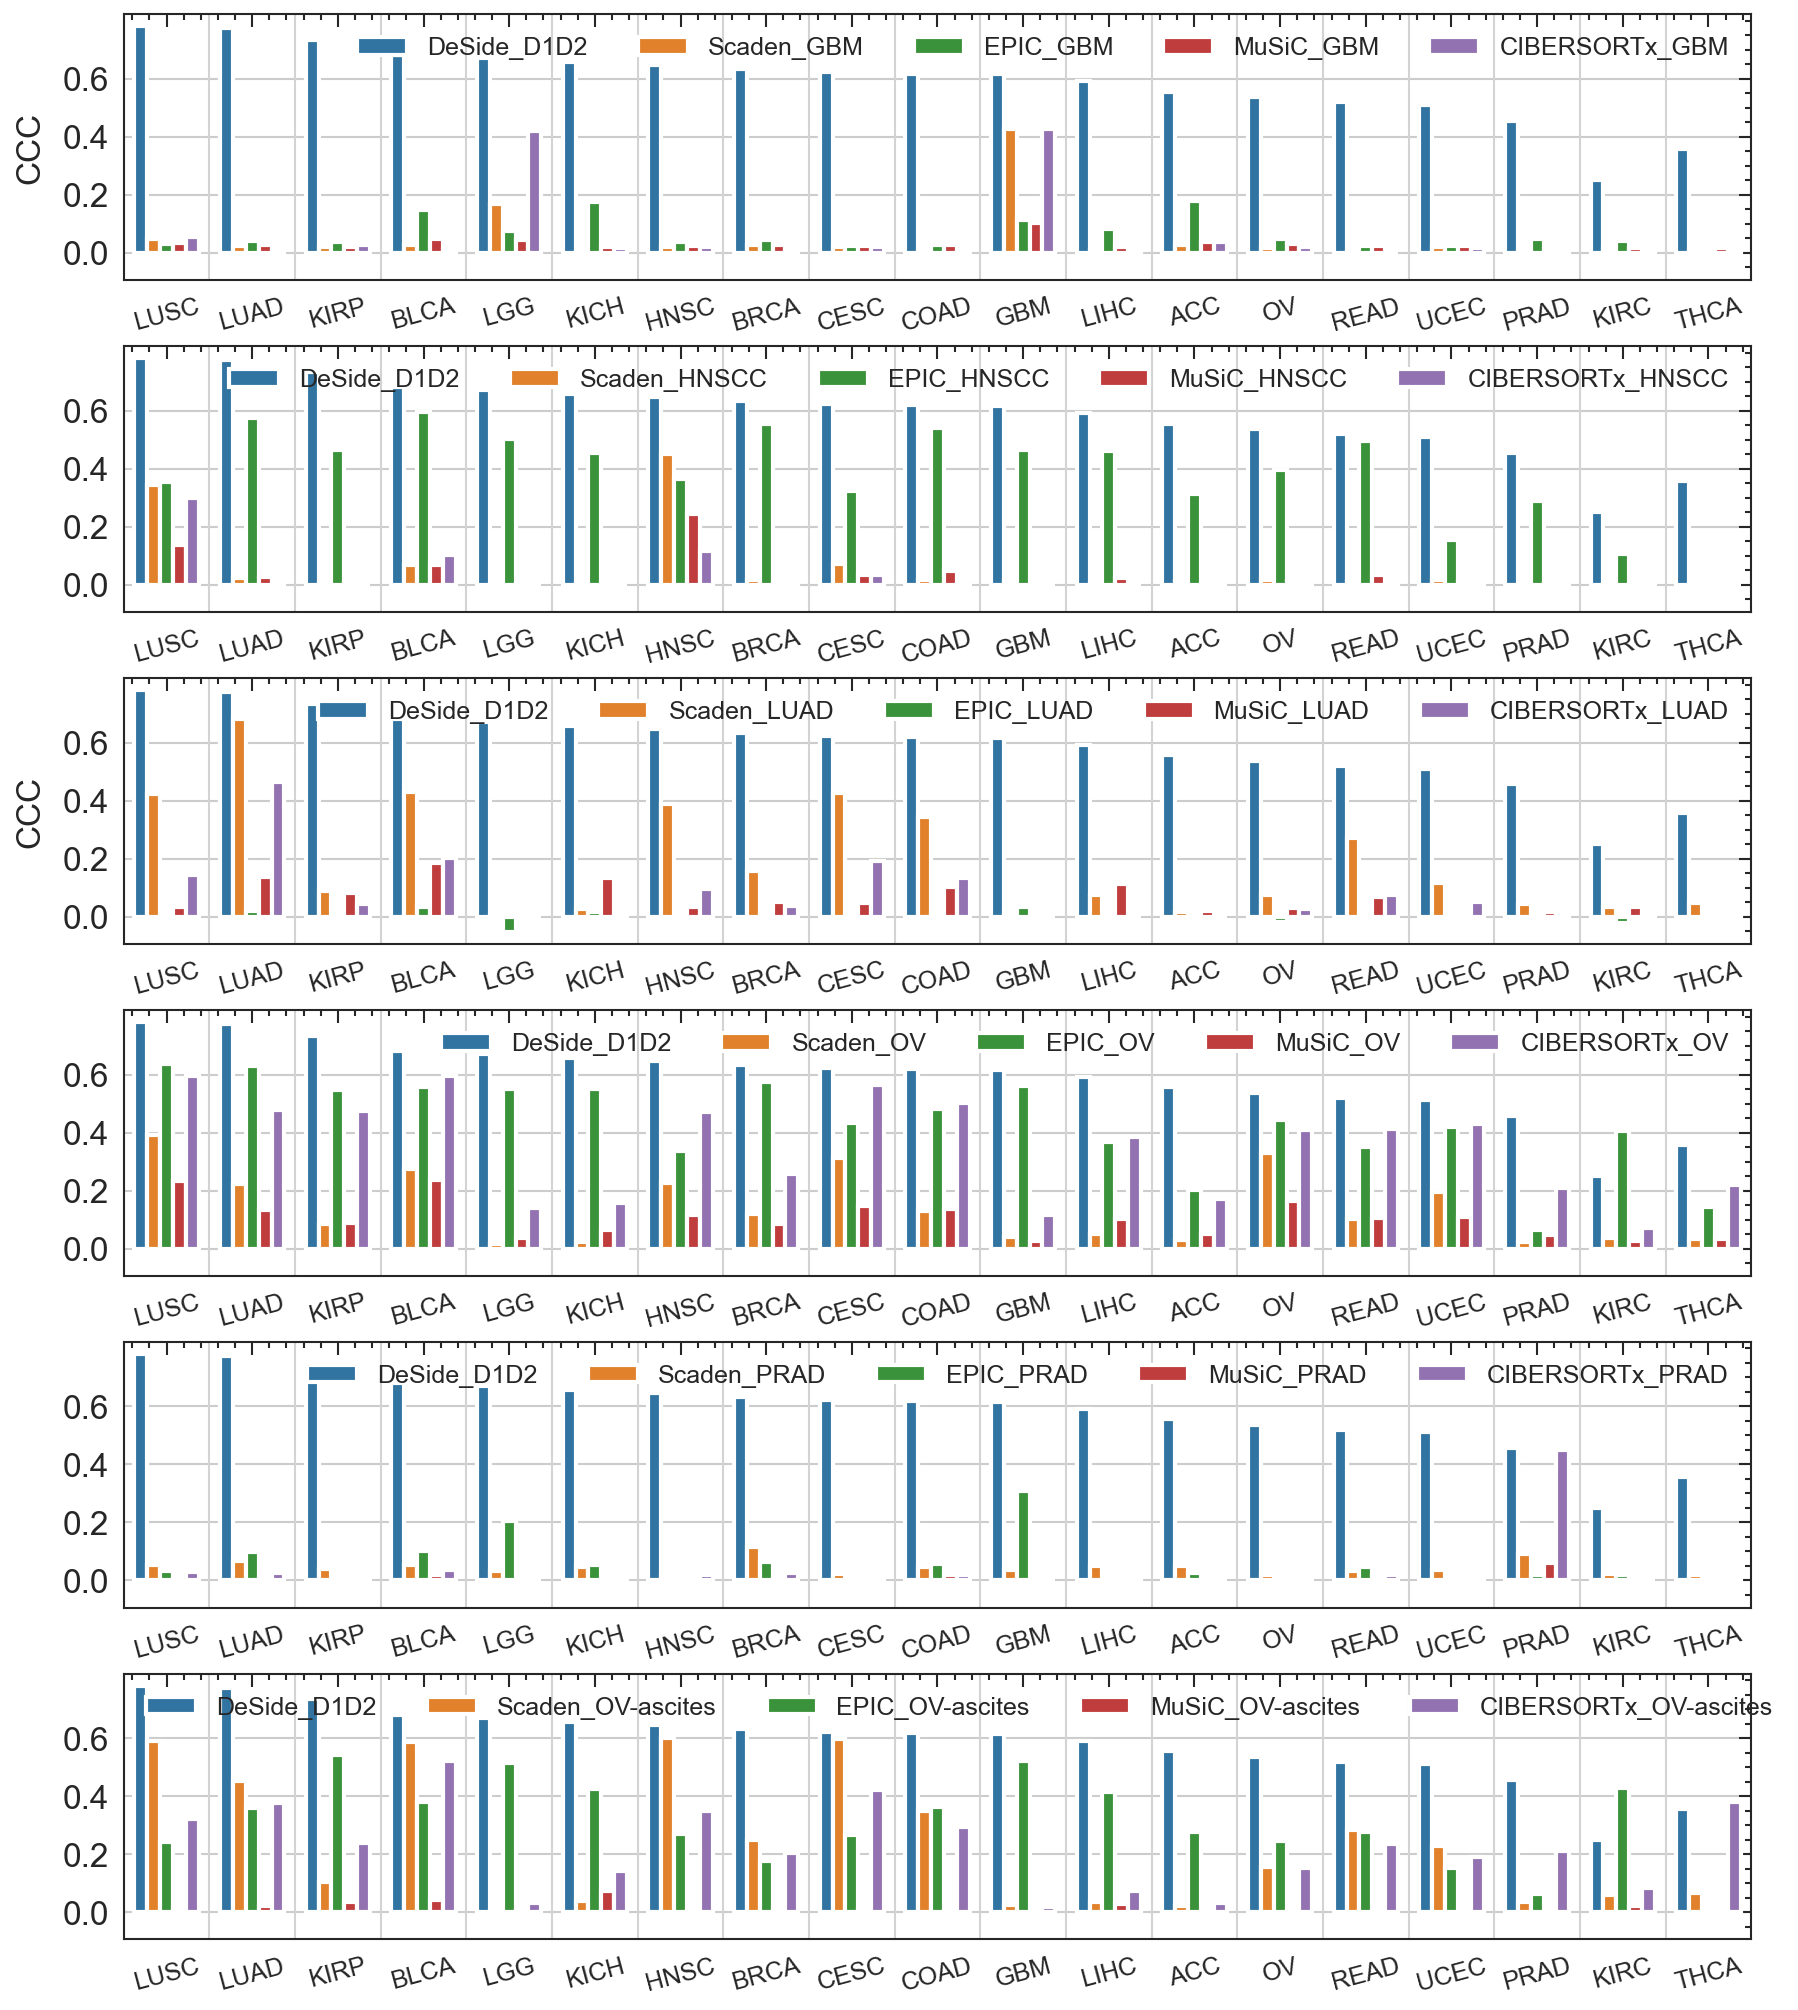

In [93]:
fig, axes = plt.subplots(figsize=(7, 8.5), nrows=6, ncols=1, sharey=True)
plt.subplots_adjust(# left=0.1, bottom=0.1,  right=0.9,  top=0.9, 
                    wspace=0.02, 
                    hspace=0.25)
width = 0.75
ct = 'GBM'
m1 = [f'DeSide_D1D2', f'Scaden_{ct}', f'EPIC_{ct}', f'MuSiC_{ct}', f'CIBERSORTx_{ct}']
g1 = sns.barplot(data=ccc_all.loc[ccc_all['model'].isin(m1), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[0], width=width, order=cancer_types, palette=color_2, 
                 hue_order=m1)
g1.legend(fontsize=6, ncol=5)
# g1.legend([],[], frameon=False)
# sns.move_legend(g1, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes[0].grid(axis='y')
for _x in range(19):
    axes[0].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g1.get_xticklabels():
    item.set_rotation(15)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes[0].set_yticks([0.0, 0.2, 0.4, 0.6])
axes[0].set_xlabel('')
axes[0].set_ylabel('CCC')

ct = 'HNSCC'
m2 = [f'DeSide_D1D2', f'Scaden_{ct}', f'EPIC_{ct}', f'MuSiC_{ct}', f'CIBERSORTx_{ct}']
g2 = sns.barplot(data=ccc_all.loc[ccc_all['model'].isin(m2), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[1], width=width, order=cancer_types, palette=color_2, 
                 hue_order=m2)
g2.legend(fontsize=6, ncol=5)
# g2.legend([],[], frameon=False)
# sns.move_legend(g2, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes[1].grid(axis='y')
for _x in range(19):
    axes[1].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g2.get_xticklabels():
    item.set_rotation(15)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes[1].set_yticks([0.0, 0.2, 0.4, 0.6])
axes[1].set_xlabel('')
axes[1].set_ylabel('')

ct = 'LUAD'
m3 = [f'DeSide_D1D2', f'Scaden_{ct}', f'EPIC_{ct}', f'MuSiC_{ct}', f'CIBERSORTx_{ct}']
g3 = sns.barplot(data=ccc_all.loc[ccc_all['model'].isin(m3), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[2], width=width, order=cancer_types, palette=color_2, 
                 hue_order=m3)
g3.legend(fontsize=6, ncol=5)
# g1.legend([],[], frameon=False)
# sns.move_legend(g1, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes[2].grid(axis='y')
for _x in range(19):
    axes[2].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g3.get_xticklabels():
    item.set_rotation(15)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes[2].set_yticks([0.0, 0.2, 0.4, 0.6])
axes[2].set_xlabel('')
axes[2].set_ylabel('CCC')

ct = 'OV'
m4 = [f'DeSide_D1D2', f'Scaden_{ct}', f'EPIC_{ct}', f'MuSiC_{ct}', f'CIBERSORTx_{ct}']
g4 = sns.barplot(data=ccc_all.loc[ccc_all['model'].isin(m4), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[3], width=width, order=cancer_types, palette=color_2, 
                 hue_order=m4)
g4.legend(fontsize=6, ncol=5)
# g2.legend([],[], frameon=False)
# sns.move_legend(g2, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes[3].grid(axis='y')
for _x in range(19):
    axes[3].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g4.get_xticklabels():
    item.set_rotation(15)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes[3].set_yticks([0.0, 0.2, 0.4, 0.6])
axes[3].set_xlabel('')
axes[3].set_ylabel('')

ct = 'PRAD'
m5 = [f'DeSide_D1D2', f'Scaden_{ct}', f'EPIC_{ct}', f'MuSiC_{ct}', f'CIBERSORTx_{ct}']
g5 = sns.barplot(data=ccc_all.loc[ccc_all['model'].isin(m5), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[4], width=width, order=cancer_types, palette=color_2, 
                 hue_order=m5)
g5.legend(fontsize=6, ncol=5)
# g2.legend([],[], frameon=False)
# sns.move_legend(g2, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes[4].grid(axis='y')
for _x in range(19):
    axes[4].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g5.get_xticklabels():
    item.set_rotation(15)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes[4].set_yticks([0.0, 0.2, 0.4, 0.6])
axes[4].set_xlabel('')
axes[4].set_ylabel('')

ct = 'OV-ascites'
m5 = [f'DeSide_D1D2', f'Scaden_{ct}', f'EPIC_{ct}', f'MuSiC_{ct}', f'CIBERSORTx_{ct}']
g6 = sns.barplot(data=ccc_all.loc[ccc_all['model'].isin(m5), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[5], width=width, order=cancer_types, palette=color_2, 
                 hue_order=m5)
g6.legend(fontsize=6, ncol=5)
# g2.legend([],[], frameon=False)
# sns.move_legend(g2, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes[5].grid(axis='y')
for _x in range(19):
    axes[5].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g6.get_xticklabels():
    item.set_rotation(15)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes[5].set_yticks([0.0, 0.2, 0.4, 0.6])
axes[5].set_xlabel('')
axes[5].set_ylabel('')


plt.savefig(os.path.join(fig_dir, 'ccc_value_comparison_across_diff_5algo_6ds_updaate.png'), dpi=300)

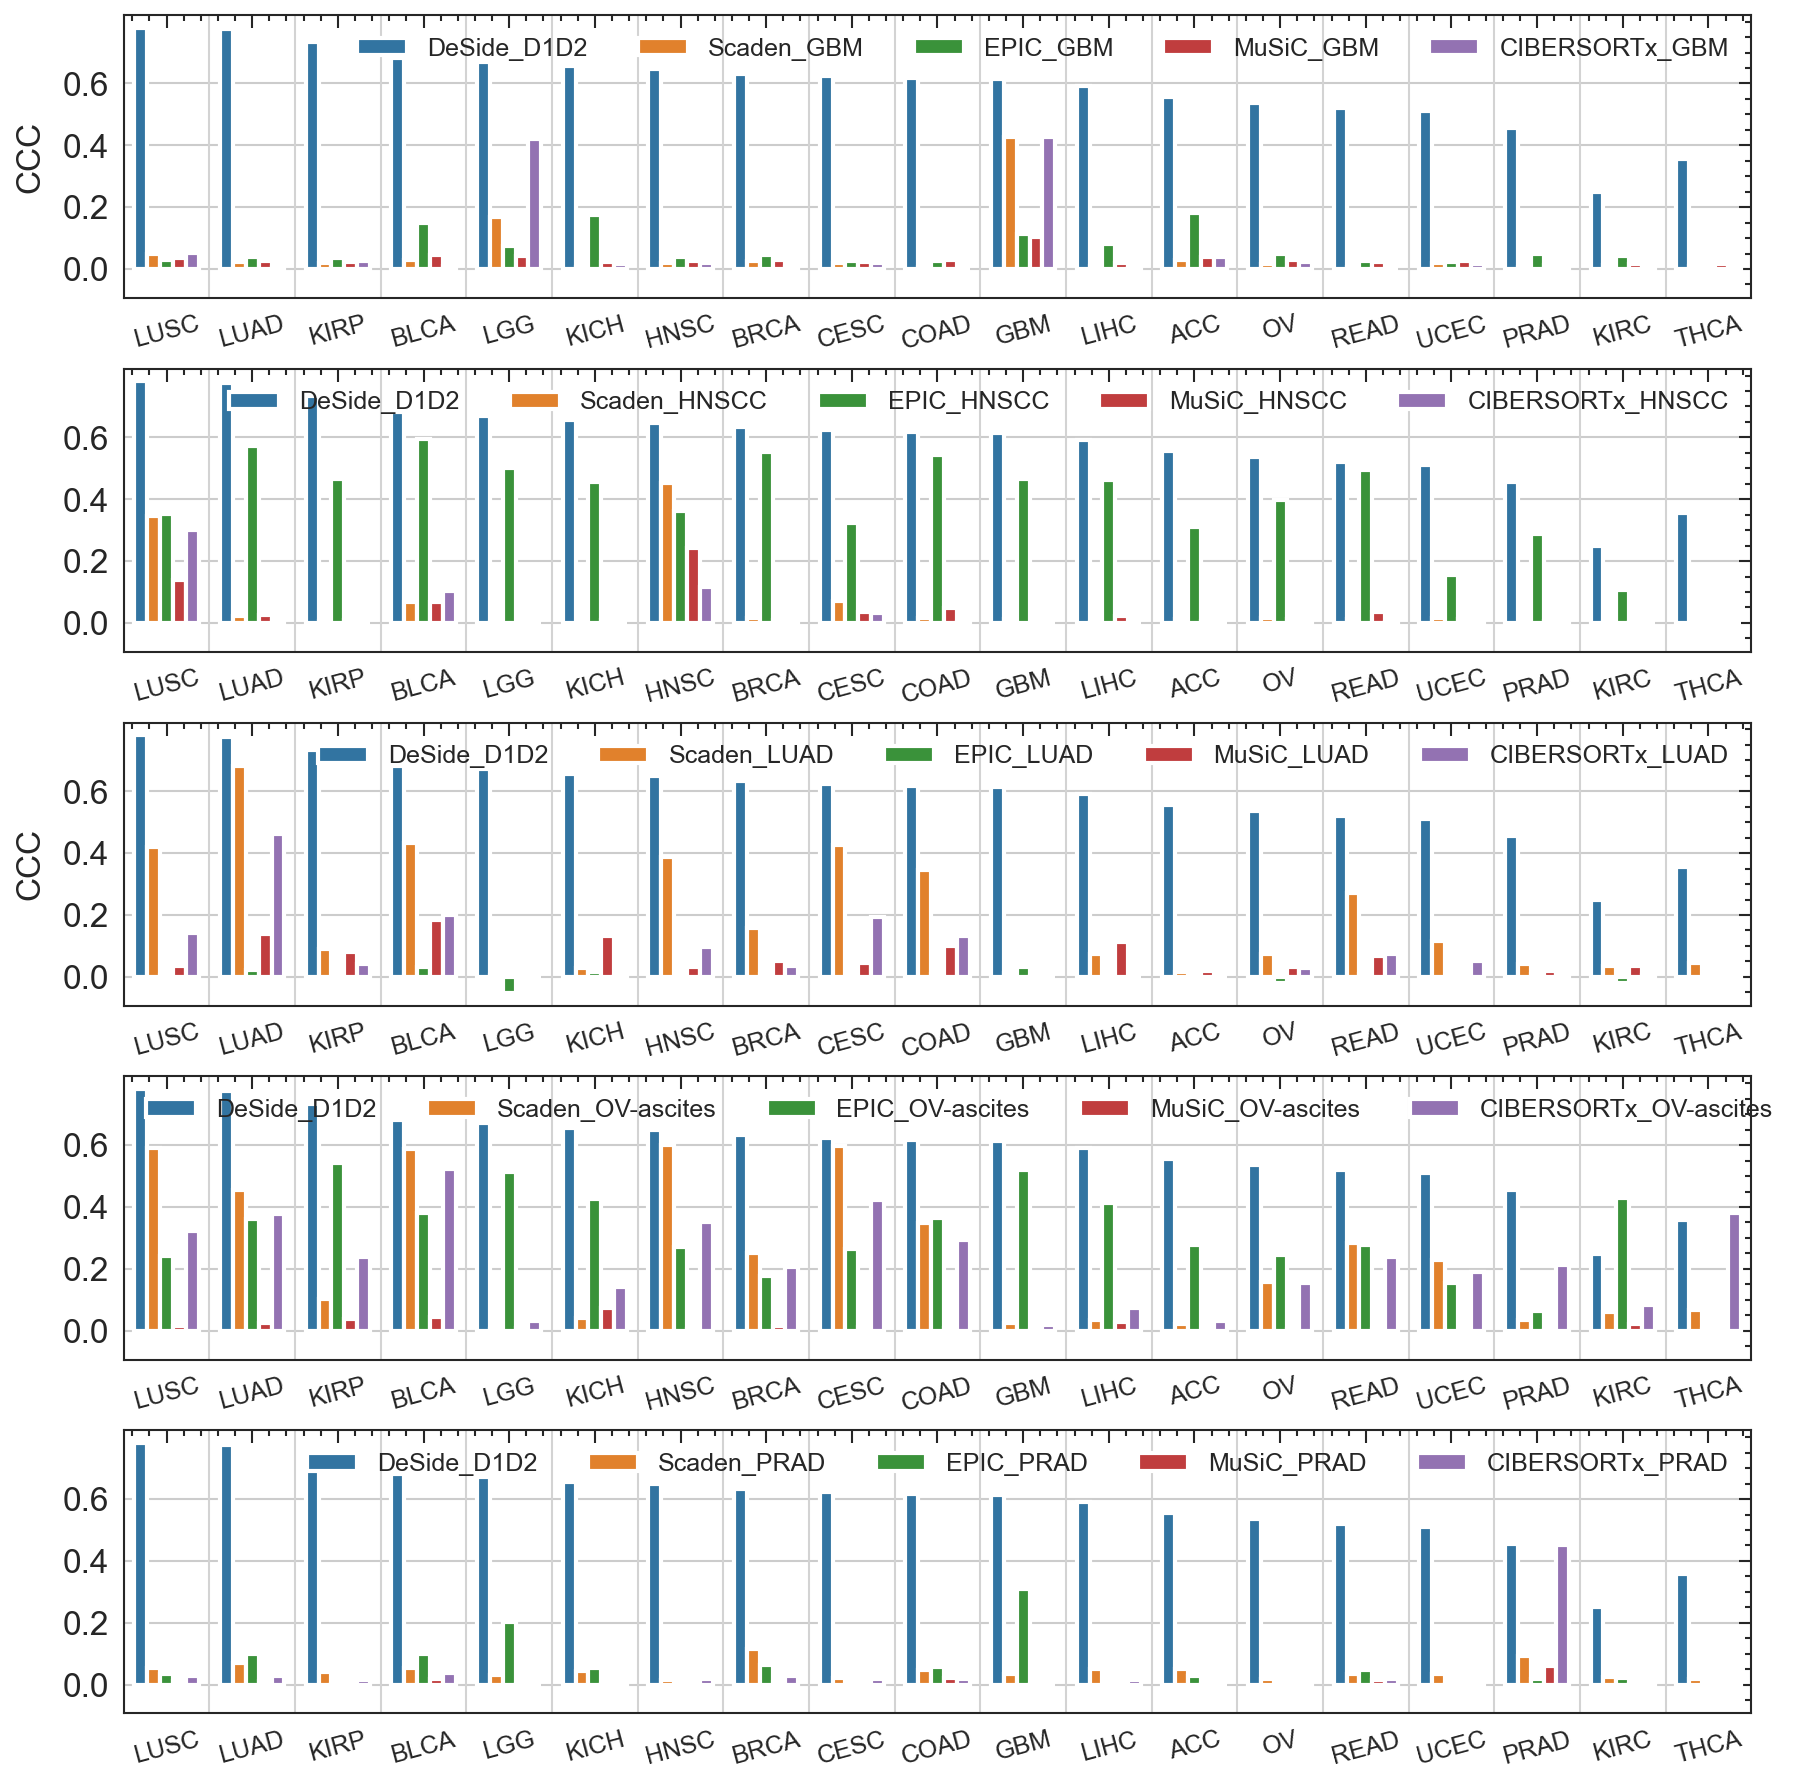

In [94]:
fig, axes = plt.subplots(figsize=(7, 7.5), nrows=5, ncols=1, sharey=True)
plt.subplots_adjust(# left=0.1, bottom=0.1,  right=0.9,  top=0.9, 
                    wspace=0.02, 
                    hspace=0.25)
width = 0.75
ct = 'GBM'
m1 = [f'DeSide_D1D2', f'Scaden_{ct}', f'EPIC_{ct}', f'MuSiC_{ct}', f'CIBERSORTx_{ct}']
g1 = sns.barplot(data=ccc_all.loc[ccc_all['model'].isin(m1), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[0], width=width, order=cancer_types, palette=color_2, 
                 hue_order=m1)
g1.legend(fontsize=6, ncol=5)
# g1.legend([],[], frameon=False)
# sns.move_legend(g1, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes[0].grid(axis='y')
for _x in range(19):
    axes[0].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g1.get_xticklabels():
    item.set_rotation(15)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes[0].set_yticks([0.0, 0.2, 0.4, 0.6])
axes[0].set_xlabel('')
axes[0].set_ylabel('CCC')

ct = 'HNSCC'
m2 = [f'DeSide_D1D2', f'Scaden_{ct}', f'EPIC_{ct}', f'MuSiC_{ct}', f'CIBERSORTx_{ct}']
g2 = sns.barplot(data=ccc_all.loc[ccc_all['model'].isin(m2), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[1], width=width, order=cancer_types, palette=color_2, 
                 hue_order=m2)
g2.legend(fontsize=6, ncol=5)
# g2.legend([],[], frameon=False)
# sns.move_legend(g2, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes[1].grid(axis='y')
for _x in range(19):
    axes[1].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g2.get_xticklabels():
    item.set_rotation(15)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes[1].set_yticks([0.0, 0.2, 0.4, 0.6])
axes[1].set_xlabel('')
axes[1].set_ylabel('')

ct = 'LUAD'
m3 = [f'DeSide_D1D2', f'Scaden_{ct}', f'EPIC_{ct}', f'MuSiC_{ct}', f'CIBERSORTx_{ct}']
g3 = sns.barplot(data=ccc_all.loc[ccc_all['model'].isin(m3), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[2], width=width, order=cancer_types, palette=color_2, 
                 hue_order=m3)
g3.legend(fontsize=6, ncol=5)
# g1.legend([],[], frameon=False)
# sns.move_legend(g1, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes[2].grid(axis='y')
for _x in range(19):
    axes[2].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g3.get_xticklabels():
    item.set_rotation(15)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes[2].set_yticks([0.0, 0.2, 0.4, 0.6])
axes[2].set_xlabel('')
axes[2].set_ylabel('CCC')

ct = 'OV-ascites'
m4 = [f'DeSide_D1D2', f'Scaden_{ct}', f'EPIC_{ct}', f'MuSiC_{ct}', f'CIBERSORTx_{ct}']
g4 = sns.barplot(data=ccc_all.loc[ccc_all['model'].isin(m4), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[3], width=width, order=cancer_types, palette=color_2, 
                 hue_order=m4)
g4.legend(fontsize=6, ncol=5)
# g2.legend([],[], frameon=False)
# sns.move_legend(g2, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes[3].grid(axis='y')
for _x in range(19):
    axes[3].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g4.get_xticklabels():
    item.set_rotation(15)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes[3].set_yticks([0.0, 0.2, 0.4, 0.6])
axes[3].set_xlabel('')
axes[3].set_ylabel('')

ct = 'PRAD'
m5 = [f'DeSide_D1D2', f'Scaden_{ct}', f'EPIC_{ct}', f'MuSiC_{ct}', f'CIBERSORTx_{ct}']
g5 = sns.barplot(data=ccc_all.loc[ccc_all['model'].isin(m5), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[4], width=width, order=cancer_types, palette=color_2, 
                 hue_order=m5)
g5.legend(fontsize=6, ncol=5)
# g2.legend([],[], frameon=False)
# sns.move_legend(g2, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes[4].grid(axis='y')
for _x in range(19):
    axes[4].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g5.get_xticklabels():
    item.set_rotation(15)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes[4].set_yticks([0.0, 0.2, 0.4, 0.6])
axes[4].set_xlabel('')
axes[4].set_ylabel('')

# ct = 'OV-ascites'
# m5 = [f'DeSide_D1D2', f'Scaden_{ct}', f'EPIC_{ct}', f'MuSiC_{ct}', f'CIBERSORTx_{ct}']
# g6 = sns.barplot(data=ccc_all.loc[ccc_all['model'].isin(m5), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[5], width=width, order=cancer_types, palette=color_2, 
#                  hue_order=m5)
# g6.legend(fontsize=6, ncol=5)
# # g2.legend([],[], frameon=False)
# # sns.move_legend(g2, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
# axes[5].grid(axis='y')
# for _x in range(19):
#     axes[5].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
# for item in g6.get_xticklabels():
#     item.set_rotation(15)
#     item.set_fontsize(6)
# # ax.legend(fontsize=6, loc='best')
# axes[5].set_yticks([0.0, 0.2, 0.4, 0.6])
# axes[5].set_xlabel('')
# axes[5].set_ylabel('')


plt.savefig(os.path.join(fig_dir, 'ccc_value_comparison_across_diff_5algo_5ds_updaate.png'), dpi=300)

In [95]:
ccc_all.shape

(475, 5)

In [96]:
ccc_all['dataset'] = ccc_all['model'].map(lambda x: x.split('_')[1])
ccc_all.head(2)

cancer_type      corr      rmse       ccc        model dataset
469        LUSC  0.794992  0.101592  0.780789  DeSide_D1D2    D1D2
468        LUAD  0.782562  0.095784  0.774914  DeSide_D1D2    D1D2

In [97]:
ccc_all_ref_based = ccc_all.loc[ccc_all['cancer_type'].isin(['LUAD', 'HNSC', 'OV', 'GBM', 'PRAD'])].copy()
ccc_all_ref_based_luad = ccc_all_ref_based.loc[(ccc_all_ref_based['cancer_type'] == 'LUAD') & (ccc_all_ref_based['dataset'] == 'LUAD'), :].copy()
ccc_all_ref_based_ov = ccc_all_ref_based.loc[(ccc_all_ref_based['cancer_type'] == 'OV') & (ccc_all_ref_based['dataset'] == 'OV-ascites'), :].copy()
ccc_all_ref_based_hnsc = ccc_all_ref_based.loc[(ccc_all_ref_based['cancer_type'] == 'HNSC') & (ccc_all_ref_based['dataset'] == 'HNSCC'), :].copy()
ccc_all_ref_based_gbm = ccc_all_ref_based.loc[(ccc_all_ref_based['cancer_type'] == 'GBM') & (ccc_all_ref_based['dataset'] == 'GBM'), :].copy()
ccc_all_ref_based_prad = ccc_all_ref_based.loc[(ccc_all_ref_based['cancer_type'] == 'PRAD') & (ccc_all_ref_based['dataset'] == 'PRAD'), :].copy()
ccc_all_ref_based_d1d2 = ccc_all_ref_based.loc[ccc_all_ref_based['dataset'] == 'D1D2', :].copy()
ccc_all_ref_based_df = pd.concat([ccc_all_ref_based_luad, ccc_all_ref_based_ov, ccc_all_ref_based_hnsc, ccc_all_ref_based_gbm, ccc_all_ref_based_prad, ccc_all_ref_based_d1d2])

print(ccc_all_ref_based_df.shape)
ccc_all_ref_based_df.head(2)

(25, 6)


cancer_type      corr      rmse       ccc            model dataset
12        LUAD  0.710786  0.112789  0.680749      Scaden_LUAD    LUAD
69        LUAD  0.486400  0.164495  0.463197  CIBERSORTx_LUAD    LUAD

In [111]:
ccc_all_ref_based_df['algo'] = ccc_all_ref_based_df['model'].map(lambda x: x.split('_')[0] + '(CDR)' if x != 'DeSide_D1D2' else x.split('_')[0])
ccc_all_ref_based_df

cancer_type      corr      rmse       ccc                  model  \
12         LUAD  0.710786  0.112789  0.680749            Scaden_LUAD   
69         LUAD  0.486400  0.164495  0.463197        CIBERSORTx_LUAD   
50         LUAD  0.428566  0.373838  0.138179             MuSiC_LUAD   
31         LUAD  0.154268  0.586997  0.020767              EPIC_LUAD   
337          OV  0.481374  0.255993  0.245348        EPIC_OV-ascites   
318          OV  0.473537  0.193038  0.157822      Scaden_OV-ascites   
375          OV  0.541035  0.274498  0.154106  CIBERSORTx_OV-ascites   
356          OV  0.115408  0.715249  0.004772       MuSiC_OV-ascites   
386        HNSC  0.647742  0.160629  0.451604           Scaden_HNSCC   
405        HNSC  0.446855  0.200160  0.363163             EPIC_HNSCC   
424        HNSC  0.383427  0.268204  0.243477            MuSiC_HNSCC   
443        HNSC  0.234600  0.264888  0.117659       CIBERSORTx_HNSCC   
81          GBM  0.707196  0.176217  0.427947             Scaden_GBM   
138         GBM  0.686375  0.181993  0.426092         CIBERSORTx_GBM   
100         GBM  0.344156  0.445496  0.113588               EPIC_GBM   
119         GBM  0.565823  0.420696  0.102429              MuSiC_GBM   
224        PRAD  0.487822  0.124015  0.450619        CIBERSORTx_PRAD   
167        PRAD  0.331672  0.341290  0.092622            Scaden_PRAD   
205        PRAD  0.348172  0.490702  0.061347             MuSiC_PRAD   
186        PRAD  0.147191  0.664246  0.019021              EPIC_PRAD   
468        LUAD  0.782562  0.095784  0.774914            DeSide_D1D2   
462        HNSC  0.705001  0.116143  0.647951            DeSide_D1D2   
461         GBM  0.766513  0.118917  0.614651            DeSide_D1D2   
470          OV  0.678799  0.114463  0.536794            DeSide_D1D2   
471        PRAD  0.537522  0.119526  0.455687            DeSide_D1D2   

        dataset             algo  
12         LUAD      Scaden(CDR)  
69         LUAD  CIBERSORTx(CDR)  
50         LUAD       MuSiC(CDR)  
31         LUAD        EPIC(CDR)  
337  OV-ascites        EPIC(CDR)  
318  OV-ascites      Scaden(CDR)  
375  OV-ascites  CIBERSORTx(CDR)  
356  OV-ascites       MuSiC(CDR)  
386       HNSCC      Scaden(CDR)  
405       HNSCC        EPIC(CDR)  
424       HNSCC       MuSiC(CDR)  
443       HNSCC  CIBERSORTx(CDR)  
81          GBM      Scaden(CDR)  
138         GBM  CIBERSORTx(CDR)  
100         GBM        EPIC(CDR)  
119         GBM       MuSiC(CDR)  
224        PRAD  CIBERSORTx(CDR)  
167        PRAD      Scaden(CDR)  
205        PRAD       MuSiC(CDR)  
186        PRAD        EPIC(CDR)  
468        D1D2           DeSide  
462        D1D2           DeSide  
461        D1D2           DeSide  
470        D1D2           DeSide  
471        D1D2           DeSide

In [112]:
selected_colors = [sns.color_palette('tab20')[0]] +  \
                  [sns.color_palette('tab20')[2]] + [sns.color_palette('tab20')[4]] + \
                  [sns.color_palette('tab20')[6]] + [sns.color_palette('tab20')[8]]

sns.color_palette(selected_colors)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

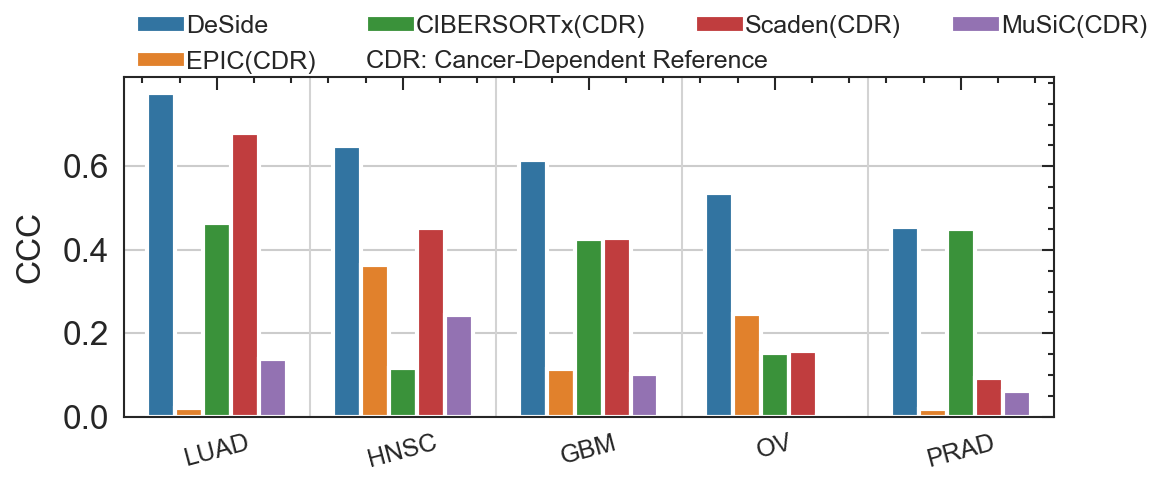

In [127]:
fig, axes = plt.subplots(figsize=(4, 1.5), nrows=1, ncols=1, sharey=True)
plt.subplots_adjust(# left=0.1, bottom=0.1,  right=0.9,  top=0.9, 
                    wspace=0.02, 
                    hspace=0.25)
width = 0.75
ct = 'GBM'
m1 = [f'DeSide', f'EPIC(CDR)', f'CIBERSORTx(CDR)', f'Scaden(CDR)', f'MuSiC(CDR)']
ref_cancer_types = ['LUAD', 'HNSC', 'GBM',  'OV', 'PRAD']
g1 = sns.barplot(data=ccc_all_ref_based_df, x='cancer_type', y='ccc', hue='algo', ax=axes, width=width, order=ref_cancer_types, palette=selected_colors, 
                 hue_order=m1)
# g1.legend(fontsize=6, ncol=5)
# g1.legend([],[], frameon=False)
sns.move_legend(g1, "upper left", bbox_to_anchor=(0, 1.22), ncol=4, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes.grid(axis='y')
for _x in range(5):
    axes.axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g1.get_xticklabels():
    item.set_rotation(15)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes.text(0.8, 0.835, 'CDR: Cancer-Dependent Reference', fontsize=6)
axes.set_yticks([0.0, 0.2, 0.4, 0.6])
axes.set_xlabel('')
axes.set_ylabel('CCC', fontsize=8)
plt.savefig(os.path.join(fig_dir, 'ccc_value_comparison_across_diff_5algo_ref_based.svg'), dpi=300)

In [101]:
ccc_all2 = pd.concat([
    # ccc_deside_deside_simu_ascites, ccc_deside_scaden_simu_ascites, ccc_scaden_scaden_simu_ascites,
    ccc_deside_scaden_simu_luad, ccc_scaden_scaden_simu_luad, 
    ccc_deside_scaden_simu_gbm,  ccc_scaden_scaden_simu_gbm,  
    ccc_deside_scaden_simu_prad, ccc_scaden_scaden_simu_prad, 
    ccc_deside_scaden_simu_ascites, ccc_scaden_scaden_simu_ascites,   
    ccc_deside_scaden_simu_hnscc, ccc_scaden_scaden_simu_hnscc,])
ccc_all2.reset_index(inplace=True)
ccc_all2.sort_values(by='ccc', ascending=False, inplace=True)
print(ccc_all2.shape)
ccc_all2.head(2)

(190, 5)


cancer_type      corr      rmse       ccc                           model
31         LUAD  0.710786  0.112789  0.680749                     Scaden_LUAD
115        BLCA  0.684749  0.132604  0.650189  DeSide_Scaden-simu(OV-ascites)

In [102]:
ccc_all2['model'].unique()

array(['Scaden_LUAD', 'DeSide_Scaden-simu(OV-ascites)',
       'DeSide_Scaden-simu(HNSCC)', 'DeSide_Scaden-simu(LUAD)',
       'Scaden_OV-ascites', 'DeSide_Scaden-simu(GBM)', 'Scaden_HNSCC',
       'Scaden_GBM', 'DeSide_Scaden-simu(PRAD)', 'Scaden_PRAD'],
      dtype=object)

In [103]:
color_2 = [sns.color_palette("tab10")[i] for i in range(2)]
sns.color_palette(color_2)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725)]

In [104]:
fig_dir = './results/reviewer2_q5/'
check_dir(fig_dir)
cancer_types = ccc_all2['cancer_type'].unique()

In [105]:
cancer_types

array(['LUAD', 'BLCA', 'LUSC', 'COAD', 'HNSC', 'CESC', 'GBM', 'READ',
       'LGG', 'LIHC', 'BRCA', 'KICH', 'KIRP', 'UCEC', 'THCA', 'OV', 'ACC',
       'KIRC', 'PRAD'], dtype=object)

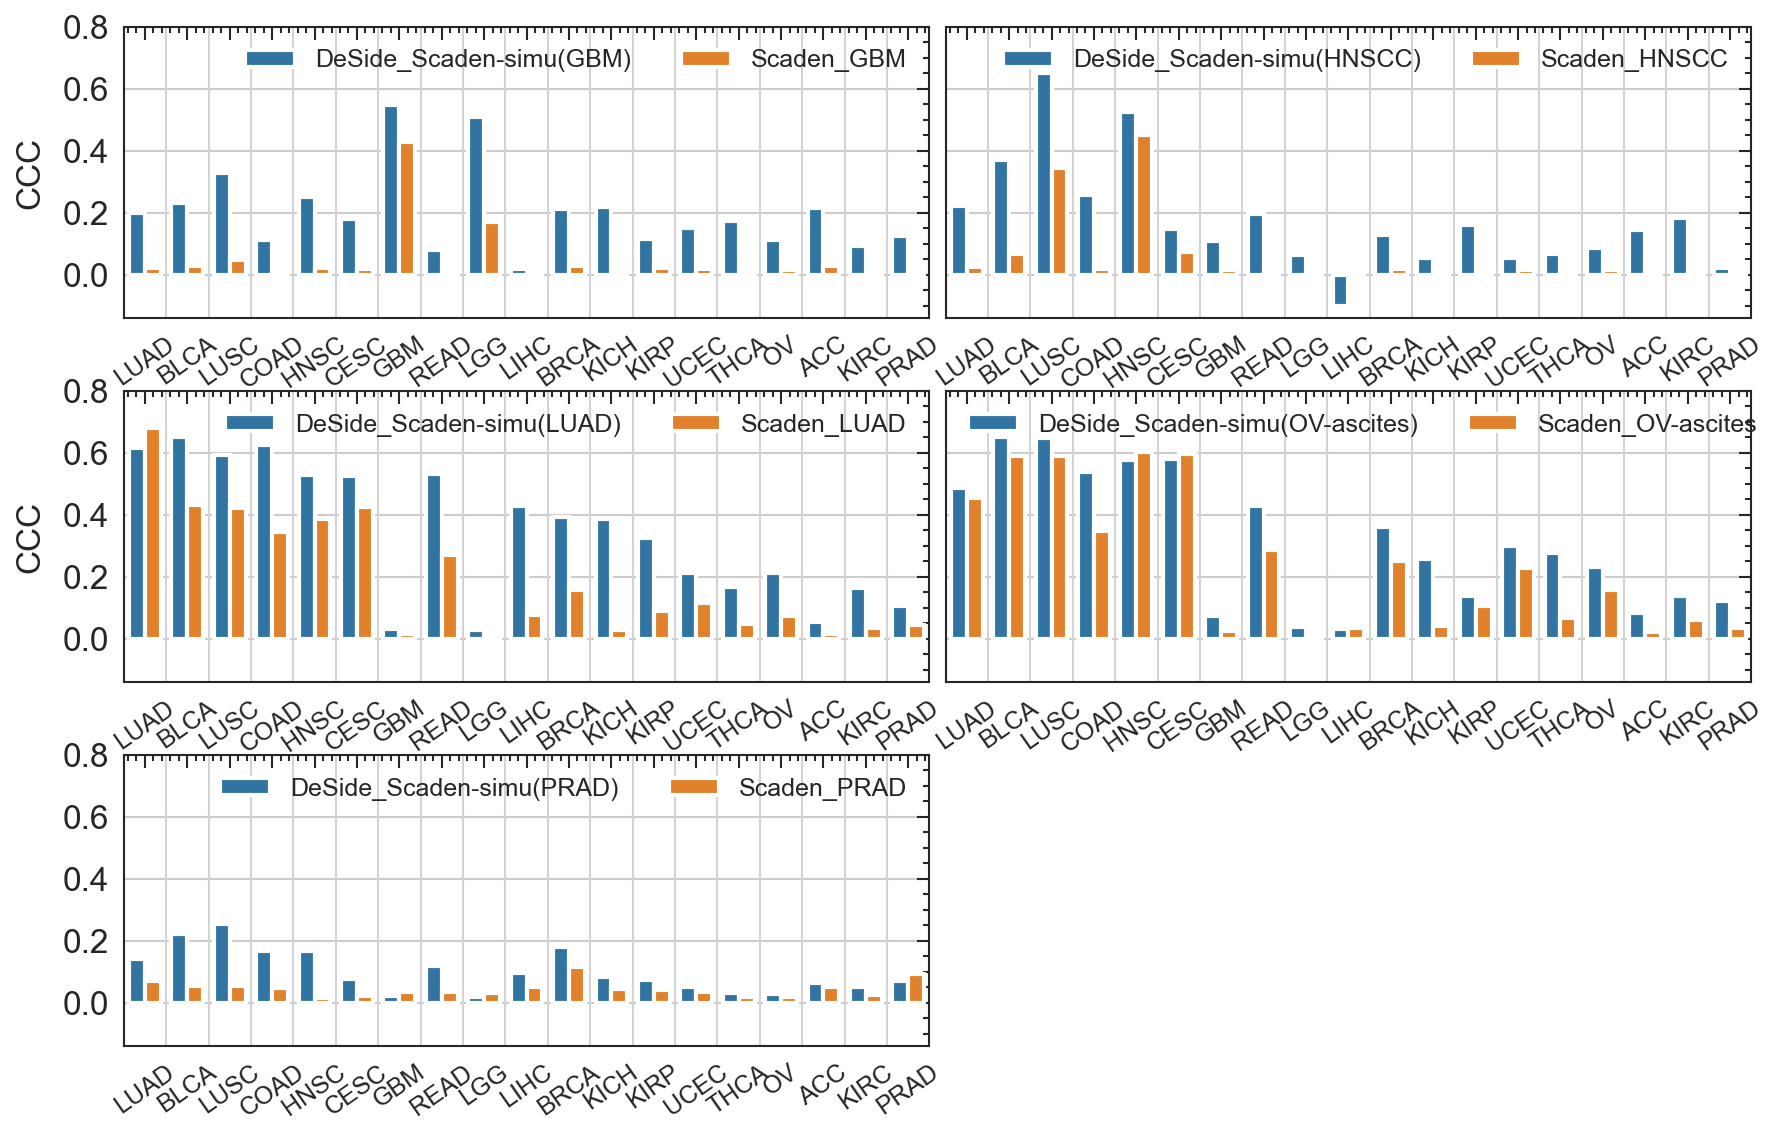

In [106]:
fig, axes = plt.subplots(figsize=(7, 4.5), nrows=3, ncols=2, sharey=True)
plt.subplots_adjust(# left=0.1, bottom=0.1,  right=0.9,  top=0.9, 
                    wspace=0.02, 
                    hspace=0.25)
width = 0.75
ct = 'GBM'
m1 = [f'DeSide_Scaden-simu({ct})', f'Scaden_{ct}']
g1 = sns.barplot(data=ccc_all2.loc[ccc_all2['model'].isin(m1), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[0, 0], width=width, order=cancer_types, palette=color_2, 
                 hue_order=m1)
g1.legend(fontsize=6, ncol=3)
# g1.legend([],[], frameon=False)
# sns.move_legend(g1, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes[0, 0].grid(axis='y')
for _x in range(19):
    axes[0, 0].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g1.get_xticklabels():
    item.set_rotation(35)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes[0, 0].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('CCC')

ct = 'HNSCC'
m2 = [f'DeSide_Scaden-simu({ct})', f'Scaden_{ct}']
g2 = sns.barplot(data=ccc_all2.loc[ccc_all2['model'].isin(m2), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[0, 1], width=width, order=cancer_types, palette=color_2, 
                 hue_order=m2)
g2.legend(fontsize=6, ncol=3)
# g2.legend([],[], frameon=False)
# sns.move_legend(g2, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes[0, 1].grid(axis='y')
for _x in range(19):
    axes[0, 1].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g2.get_xticklabels():
    item.set_rotation(35)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes[0, 1].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')

ct = 'LUAD'
m3 = [f'DeSide_Scaden-simu({ct})', f'Scaden_{ct}']
g3 = sns.barplot(data=ccc_all2.loc[ccc_all2['model'].isin(m3), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[1, 0], width=width, order=cancer_types, palette=color_2, 
                 hue_order=m3)
g3.legend(fontsize=6, ncol=3)
# g1.legend([],[], frameon=False)
# sns.move_legend(g1, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes[1, 0].grid(axis='y')
for _x in range(19):
    axes[1, 0].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g3.get_xticklabels():
    item.set_rotation(35)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes[1, 0].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('CCC')

ct = 'OV-ascites'
m4 = [f'DeSide_Scaden-simu({ct})', f'Scaden_{ct}']
g4 = sns.barplot(data=ccc_all2.loc[ccc_all2['model'].isin(m4), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[1, 1], width=width, order=cancer_types, palette=color_2, 
                 hue_order=m4)
g4.legend(fontsize=6, ncol=3)
# g2.legend([],[], frameon=False)
# sns.move_legend(g2, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes[1, 1].grid(axis='y')
for _x in range(19):
    axes[1, 1].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g4.get_xticklabels():
    item.set_rotation(35)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes[1, 1].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('')

ct = 'PRAD'
m5 = [f'DeSide_Scaden-simu({ct})', f'Scaden_{ct}']
g5 = sns.barplot(data=ccc_all2.loc[ccc_all2['model'].isin(m5), :].copy(), x='cancer_type', y='ccc', hue='model', ax=axes[2, 0], width=width, order=cancer_types, palette=color_2, 
                 hue_order=m5)
g5.legend(fontsize=6, ncol=3)
# g2.legend([],[], frameon=False)
# sns.move_legend(g2, "upper left", bbox_to_anchor=(0, 1.17), ncol=3, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
axes[2, 0].grid(axis='y')
for _x in range(19):
    axes[2, 0].axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g5.get_xticklabels():
    item.set_rotation(35)
    item.set_fontsize(6)
# ax.legend(fontsize=6, loc='best')
axes[2, 0].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
axes[2, 0].set_xlabel('')
axes[2, 0].set_ylabel('')

axes[2, 1].axis('off')
axes[2, 1].legend([], [])


plt.savefig(os.path.join(fig_dir, 'ccc_value_comparison_across_diff_2algo_5ds_same_training_set.svg'), dpi=300)